<a href="https://colab.research.google.com/github/navneetkrc/GenAI_Concepts/blob/main/Chunking_Strategies/Comparing_Naive_vs_Late_vs_Contextual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chunking Strategies Compared Version 4

*   Naive Chunking
*   Late Chunking
*   Contextual Chunking


**With Nomic AI Embed model for Late Chunking and real support docs for comparison with multiple queries list**

Chunking Strategy Analysis (v4)

**Compare RAG retrieval performance** across three document segmentation approaches using real Samsung Galaxy support documentation:

- **Naive Chunking**: Fixed-size text splitting  
- **Late Chunking**: Full-document embedding with [Nomic AI's nomic-embed-text-v1.5](https://nomic.ai/) followed by token pooling  
- **Contextual Chunking**: BART-summary augmented chunks  

**Key Features**  
- Processes S24/S25 PDF manuals with text cleaning/Markdown conversion  
- Tests 20+ real-world troubleshooting queries  
- Visualizes semantic relationships via PCA/UMAP/t-SNE  
- Quantifies strategy effectiveness through cosine similarity metrics  

**Output** generates interactive plots and PDF reports showing optimal chunking approaches for technical documentation retrieval.



---





*   **Purpose:** Compares the effectiveness of three text chunking strategies (Naive, Late, Contextual) for information retrieval.
*   **Embedding Model:** Uses the `nomic-ai/nomic-embed-text-v1.5` model for generating embeddings, specifically utilizing its token embedding capabilities for Late Chunking.
*   **Data:** Processes text extracted from real-world PDF documents (Samsung Galaxy S24 and S25 user manuals) using `pymupdf4llm`.
*   **Evaluation:** Tests the chunking strategies against a list of diverse user queries (`query_list`).
*   **Methodology:**
    *   Loads and cleans text from PDFs.
    *   Applies each chunking strategy to both documents.
    *   Embeds the query and calculates cosine similarity against all generated chunks.
    *   Identifies the top `N` most similar chunks for each strategy/document combination per query.
*   **Visualization:**
    *   Generates violin plots showing the distribution of similarity scores for top results.
    *   Creates 2D spatial plots (using PCA, UMAP, or t-SNE) to visualize the relationships between chunks, strategies, documents, and the query in the embedding space.
*   **Output:** Saves analysis results, including data tables and plots, into a structured Markdown report (`query_analysis_report.md`) with an optional PDF conversion and image download.

In [86]:
# Cell 1: Install necessary libraries (adding kaleido, markdown-pdf)
!pip install sentence-transformers transformers torch plotly scikit-learn numpy pandas pymupdf4llm kaleido markdown-pdf -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00


In [52]:
# Cell 2: Import libraries (UPDATED with CUDA_LAUNCH_BLOCKING)

import os
# Set environment variable for synchronous CUDA calls - HELPS DEBUGGING GPU ERRORS
# MUST BE SET BEFORE TORCH IMPORT AND REQUIRES KERNEL RESTART
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print(f"Set CUDA_LAUNCH_BLOCKING=1: {os.environ.get('CUDA_LAUNCH_BLOCKING')}")
print("!!! IMPORTANT: You MUST restart the Jupyter Kernel now for CUDA_LAUNCH_BLOCKING to take effect !!!")

# Proceed with imports after restarting kernel
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import torch
import pymupdf4llm # Added
# import os # Already imported

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Re-checking device after potential restart
print(f"Using device: {DEVICE}")
if DEVICE == "cuda":
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

Set CUDA_LAUNCH_BLOCKING=1: 1
!!! IMPORTANT: You MUST restart the Jupyter Kernel now for CUDA_LAUNCH_BLOCKING to take effect !!!
Using device: cpu


In [53]:
# Cell 3: Initialize models (No functional change, added print)
# Initialize the embedding model
model_name = 'nomic-ai/nomic-embed-text-v1.5'
print(f"Initializing embedding model: {model_name}")
# Nomic requires trusting remote code
embedding_model = SentenceTransformer(model_name, device=DEVICE, trust_remote_code=True)

# Initialize summarizer pipeline
summarizer_device = 0 if DEVICE == "cuda" else -1
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=summarizer_device)

print("Models Initialized.")
print(f"Using Embedding Model: {model_name} (Supports 8192 sequence length)")

Initializing embedding model: nomic-ai/nomic-embed-text-v1.5


Device set to use cpu


Models Initialized.
Using Embedding Model: nomic-ai/nomic-embed-text-v1.5 (Supports 8192 sequence length)


In [54]:
# Cell 3.1: Basic Encoding Test (UPDATED to handle list output)

print("Testing basic encoding with the loaded model...")
test_sentences = ["This is a test sentence.", "Dies ist ein Testsatz."]
try:
    # Standard pooled embedding
    print("  Testing pooled embeddings...")
    embeddings_pooled = embedding_model.encode(test_sentences, convert_to_numpy=True)
    print(f"  Successfully generated POOLED embeddings. Type: {type(embeddings_pooled)}, Shape: {embeddings_pooled.shape}")

    # Token embeddings
    print("  Testing token embeddings...")
    with torch.no_grad():
      # Request tensor output, but be prepared for a list of tensors
      embeddings_token_output = embedding_model.encode(test_sentences, output_value='token_embeddings', convert_to_tensor=True)

    # --- Check the output type ---
    if isinstance(embeddings_token_output, list):
        print(f"  Successfully generated TOKEN embeddings.")
        print(f"  Output type: list (Length: {len(embeddings_token_output)})")
        if embeddings_token_output: # Check if list is not empty
             first_item = embeddings_token_output[0]
             print(f"  Type of first item: {type(first_item)}")
             if hasattr(first_item, 'shape'):
                 print(f"  Shape of first item (token embeddings for first sentence): {first_item.shape}")
             else:
                 print("  First item does not have a shape attribute.")
        else:
            print("  Token embedding list is empty.")

    elif hasattr(embeddings_token_output, 'shape'): # Check if it's a tensor/array with shape
         print(f"  Successfully generated TOKEN embeddings.")
         print(f"  Output type: {type(embeddings_token_output)}, Shape: {embeddings_token_output.shape}")

    else:
        print(f"  Generated TOKEN embeddings, but output type is unexpected: {type(embeddings_token_output)}")


    print("\nBasic encoding test passed.")
except Exception as e:
    print(f"ERROR during basic encoding test: {e}")
    # If this fails, the problem is fundamental to model loading or basic use on your GPU.
    raise e

Testing basic encoding with the loaded model...
  Testing pooled embeddings...
  Successfully generated POOLED embeddings. Type: <class 'numpy.ndarray'>, Shape: (2, 768)
  Testing token embeddings...
  Successfully generated TOKEN embeddings.
  Output type: list (Length: 2)
  Type of first item: <class 'torch.Tensor'>
  Shape of first item (token embeddings for first sentence): torch.Size([8, 768])

Basic encoding test passed.


In [55]:
# Cell 4: Define Naive Chunking function (UPDATED with debugging print)
def naive_chunking(document, chunk_size=512, source_label=""):
    """
    Split the document into chunks first, then embed each chunk individually.
    Includes a source label and debug print.
    """
    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
    results = []
    print(f"  Naive Chunking ({source_label}): Processing {len(chunks)} potential chunks...")
    count = 0
    for i, chunk in enumerate(chunks): # Add index for debugging
        if chunk.strip():
            # --- DEBUG PRINT ---
            print(f"  Naive Chunking ({source_label}) - Encoding chunk {i+1}/{len(chunks)} (len={len(chunk)}): '{chunk[:50]}...'")
            # --- END DEBUG PRINT ---
            try:
                embedding = embedding_model.encode(chunk, convert_to_numpy=True)
                results.append({
                    'text': chunk,
                    'embedding': embedding,
                    'strategy': 'Naive',
                    'source': source_label
                })
                count += 1
            except Exception as e:
                print(f"  ERROR encoding chunk {i+1} ('{chunk[:50]}...'): {e}")
                # Optionally continue to the next chunk or re-raise
                # continue
                raise e # Re-raise by default to see the error immediately

    print(f"  Naive Chunking ({source_label}): Generated {count} embeddings.")
    return results

In [56]:
# Cell 5: Define Late Chunking function (UPDATED with source_label)
def late_chunking(document, chunk_size=512, target_max_length=8192, source_label=""): # Add source_label
    """
    Implements Late Chunking by embedding the full document to get token embeddings,
    then pooling token embeddings corresponding to each chunk. Includes a source label.
    """
    print(f"  Late Chunking ({source_label}): Attempting token pooling with target_max_length={target_max_length}...")
    # 1. Tokenization and Embedding (keep internal logic same as before)
    if not hasattr(embedding_model, 'tokenizer') or not hasattr(embedding_model, 'encode'):
         print(f"  Late Chunking Error ({source_label}): Embedding model missing 'tokenizer' or 'encode'.")
         raise AttributeError("Embedding model must have a 'tokenizer' attribute and 'encode' method.")
    effective_max_length = target_max_length
    try:
        print(f"  Late Chunking ({source_label}): Tokenizing document...")
        tokenized_full = embedding_model.tokenizer(
            document, return_offsets_mapping=True, return_tensors='pt',
            truncation=True, max_length=effective_max_length
        ).to(embedding_model.device)
        num_tokens = tokenized_full['input_ids'].shape[1]
        print(f"  Late Chunking ({source_label}): Document tokenized into {num_tokens} tokens.")
        print(f"  Late Chunking ({source_label}): Encoding document...")
        with torch.no_grad():
             outputs = embedding_model.encode(
                 document, output_value='token_embeddings', convert_to_tensor=True, batch_size=1
                ).to(embedding_model.device)
        print(f"  Late Chunking ({source_label}): Raw token embedding output shape: {outputs.shape}")
        if len(outputs.shape) == 3 and outputs.shape[0] == 1: token_embeddings = outputs[0]
        elif len(outputs.shape) == 2:
             if outputs.shape[0] != num_tokens: print(f"  Late Chunking Warning ({source_label}): Token count mismatch.")
             token_embeddings = outputs
        else: raise ValueError(f"Unexpected shape for token embeddings: {outputs.shape}")
        print(f"  Late Chunking ({source_label}): Processed token embedding shape: {token_embeddings.shape}")
        offset_mapping = tokenized_full['offset_mapping'][0,:token_embeddings.shape[0]].cpu().numpy()
    except Exception as e:
        # Fallback logic (keep same as before)
        print(f"  Late Chunking Error ({source_label}): Failed getting token embeddings: {e}. Falling back.")
        fallback_max_len = 512
        truncated_document = document[:fallback_max_len * 4]
        document_embedding = embedding_model.encode(truncated_document, convert_to_numpy=True)
        chunks_text = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
        results = [{'text': chunk, 'embedding': document_embedding, 'strategy': 'Late', 'source': source_label} for chunk in chunks_text if chunk.strip()] # Add source
        print(f"  Late Chunking ({source_label}) (Fallback): Generated {len(results)} embeddings.")
        return results

    # 2. Define chunk boundaries (keep same as before)
    chunks_text_boundaries = []
    for i in range(0, len(document), chunk_size):
        start_char = i
        end_char = i + chunk_size
        chunk_text = document[start_char:end_char]
        if chunk_text.strip():
            chunks_text_boundaries.append({'text': chunk_text, 'start_char': start_char, 'end_char': end_char})
    print(f"  Late Chunking ({source_label}): Defined {len(chunks_text_boundaries)} text chunk boundaries.")

    # 3. Map boundaries and pool (modify to add source_label)
    results = []
    token_embeddings_np = token_embeddings.cpu().numpy()
    for chunk_info in chunks_text_boundaries:
        start_char = chunk_info['start_char']
        end_char = chunk_info['end_char']
        token_indices = []
        for idx, (token_start, token_end) in enumerate(offset_mapping):
            if token_start == 0 and token_end == 0: continue
            if token_start < end_char and token_end > start_char:
                 if idx < token_embeddings_np.shape[0]: token_indices.append(idx)
        if token_indices:
            chunk_token_embeddings = token_embeddings_np[token_indices]
            chunk_embedding = np.mean(chunk_token_embeddings, axis=0)
            results.append({
                'text': chunk_info['text'],
                'embedding': chunk_embedding,
                'strategy': 'Late',
                'source': source_label # Added source
            })

    # Fallback if pooling failed (modify to add source_label)
    if not results and chunks_text_boundaries:
         print(f"  Late Chunking Warning ({source_label}): Pooling failed. Falling back.")
         fallback_max_len = 512
         truncated_document = document[:fallback_max_len * 4]
         document_embedding = embedding_model.encode(truncated_document, convert_to_numpy=True)
         chunks_text = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
         results = [{'text': chunk, 'embedding': document_embedding, 'strategy': 'Late', 'source': source_label} for chunk in chunks_text if chunk.strip()] # Add source
         print(f"  Late Chunking ({source_label}) (Fallback): Generated {len(results)} embeddings.")
    else:
        print(f"  Late Chunking ({source_label}) (Token Pooling): Generated {len(results)} embeddings.")
    return results

In [57]:
# Cell 6: Define Contextual Chunking function (UPDATED with source_label)
def contextual_chunking(document, chunk_size=512, source_label=""):
    """
    Generate context-aware chunks by summarizing the document and appending
    the summary to each chunk *before* embedding. Includes a source label.
    """
    print(f"  Contextual Chunking ({source_label}): Generating summary...")
    max_summary_input_length = 1024 * 4
    truncated_for_summary = document[:max_summary_input_length]
    if len(document) > len(truncated_for_summary):
        print(f"  Contextual Chunking Warning ({source_label}): Doc truncated for summary.")
    try:
        summary = summarizer(truncated_for_summary, max_length=130, min_length=20, do_sample=False)[0]['summary_text']
        print(f"  Contextual Chunking ({source_label}): Summary generated.")
    except Exception as e:
        print(f"  Contextual Chunking Error ({source_label}) during summarization: {e}. Using empty summary.")
        summary = ""

    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
    print(f"  Contextual Chunking ({source_label}): Processing {len(chunks)} potential chunks...")
    results = []
    count = 0
    for chunk in chunks:
       if chunk.strip():
            enriched_chunk_for_embedding = chunk + f" [CONTEXT_SUMMARY_{source_label}] " + summary
            embedding = embedding_model.encode(enriched_chunk_for_embedding, convert_to_numpy=True)
            results.append({
                'text': chunk,
                'embedding': embedding,
                'strategy': 'Contextual',
                'source': source_label # Added source
            })
            count += 1
    print(f"  Contextual Chunking ({source_label}): Generated {count} embeddings.")
    return results

In [58]:
import requests

url = "https://downloadcenter.samsung.com/content/UM/202501/20250124163913655/SM-S93X_UG_EU_15_Eng_Rev.1.0_250123.pdf"
response = requests.get(url)

with open("s25_support_doc_input.pdf", "wb") as f:
    f.write(response.content)
print("PDF downloaded successfully as s25_support_doc.pdf")


url = "https://downloadcenter.samsung.com/content/UM/202409/20240913104143006/SM-S92X_UG_EU_UU_Eng_Rev.1.3_240912.pdf"
response = requests.get(url)

with open("s24_support_doc_input.pdf", "wb") as f:
    f.write(response.content)
print("PDF downloaded successfully as s24_support_doc.pdf")

PDF downloaded successfully as s25_support_doc.pdf
PDF downloaded successfully as s24_support_doc.pdf


In [59]:
# Cell 7: Load Documents from PDFs using pymupdf4llm (UPDATED with basic cleaning)

# ---!!! USER ACTION REQUIRED: SET PDF FILE PATHS !!!---
pdf_path_s24 = "s24_support_doc_input.pdf"  # <--- CHANGE THIS AS NEEDED
pdf_path_s25 = "s25_support_doc_input.pdf"  # <--- CHANGE THIS AS NEEDED
# ---!!! END USER ACTION REQUIRED !!!---

def clean_text(text):
    """Basic cleaning: remove null chars, replace multiple spaces/newlines."""
    if not text: return ""
    text = text.replace('\x00', '') # Remove null characters
    text = ' '.join(text.split()) # Replace multiple whitespace chars with single space
    return text

def load_with_pymupdf(pdf_path, doc_label=""):
     print(f"Extracting text from {doc_label} PDF: {pdf_path}")
     if not os.path.exists(pdf_path):
        print(f"  Error: File not found at {pdf_path}")
        raise FileNotFoundError(f"Please ensure '{os.path.basename(pdf_path)}' is uploaded.")
     try:
        md_text = pymupdf4llm.to_markdown(pdf_path)
        cleaned_text = clean_text(md_text) # Apply cleaning
        print(f"  Successfully extracted & cleaned text from {doc_label} PDF (length: {len(cleaned_text)}).")
        return cleaned_text
     except Exception as e:
         print(f"  Error loading {doc_label} PDF with pymupdf4llm: {e}")
         return ""

# Load the documents separately
s24_text = load_with_pymupdf(pdf_path_s24, "S24")
s25_text = load_with_pymupdf(pdf_path_s25, "S25")

# --- Verification ---
if not s24_text: print("Warning: No text extracted/loaded from S24 PDF.")
if not s25_text: print("Warning: No text extracted/loaded from S25 PDF.")
if not s24_text or not s25_text: raise ValueError("Failed to load text. Stopping.")

print("\nTexts for S24 and S25 loaded separately.")
print(f"S24 Text Length: {len(s24_text)}")
print(f"S25 Text Length: {len(s25_text)}")

Extracting text from S24 PDF: s24_support_doc_input.pdf
  Successfully extracted & cleaned text from S24 PDF (length: 244053).
Extracting text from S25 PDF: s25_support_doc_input.pdf
  Successfully extracted & cleaned text from S25 PDF (length: 227968).

Texts for S24 and S25 loaded separately.
S24 Text Length: 244053
S25 Text Length: 227968


In [60]:
# Cell 8: Define Sample Query and Chunk Size
sample_query = "How to fix overheating on Galaxy S25?"
chunk_size = 512 # Adjust as needed, smaller makes visualization denser

print(f"Sample query: '{sample_query}'")
print(f"Chunk size: {chunk_size} characters")

Sample query: 'How to fix overheating on Galaxy S25?'
Chunk size: 512 characters


In [61]:
# Cell 9: Run all chunking methods for EACH document (Ensure this runs successfully)
all_results = []
docs_to_process = {
    "S24": s24_text,
    "S25": s25_text
}

for doc_label, doc_text in docs_to_process.items():
    print(f"\n--- Processing Document: {doc_label} ---")
    if not doc_text:
        print(f"Skipping {doc_label} due to empty text.")
        continue

    print(f"Running Naive Chunking for {doc_label}...")
    results_naive = naive_chunking(doc_text, chunk_size, source_label=doc_label)
    all_results.extend(results_naive)
    print(f"Completed Naive Chunking for {doc_label}.\n")

    print(f"Running Late Chunking for {doc_label}...")
    results_late = late_chunking(doc_text, chunk_size, source_label=doc_label) # Nomic used here
    all_results.extend(results_late)
    print(f"Completed Late Chunking for {doc_label}.\n")

    print(f"Running Contextual Chunking for {doc_label}...")
    results_contextual = contextual_chunking(doc_text, chunk_size, source_label=doc_label)
    all_results.extend(results_contextual)
    print(f"Completed Contextual Chunking for {doc_label}.\n")

# Create the main DataFrame containing ALL chunks
if all_results:
    df_results = pd.DataFrame(all_results)
    print(f"\n--- Initial Processing Complete ---")
    print(f"Total chunks collected across all documents: {len(df_results)}")
    if not df_results.empty:
        print("Chunk Counts per Strategy and Source:")
        print(df_results.groupby(['source', 'strategy']).size())
else:
    raise ValueError("No results were generated from the chunking steps. Cannot proceed.")

# Clean up intermediate results if needed
del all_results, results_naive, results_late, results_contextual


--- Processing Document: S24 ---
Running Naive Chunking for S24...
  Naive Chunking (S24): Processing 477 potential chunks...
  Naive Chunking (S24) - Encoding chunk 1/477 (len=512): '# USER GUIDE ###### SM-S921B/DS SM-S921B/DS UD SM-...'
  Naive Chunking (S24) - Encoding chunk 2/477 (len=512): ' 37 Entering text 39 Extracting text #### Apps and...'
  Naive Chunking (S24) - Encoding chunk 3/477 (len=512): 'alaxy S24 Ultra) 113 Calendar 114 Reminder (Receiv...'
  Naive Chunking (S24) - Encoding chunk 4/477 (len=512): 'uction 132 Samsung account 132 Connections 134 Wi-...'
  Naive Chunking (S24) - Encoding chunk 5/477 (len=512): 'hemes 150 Home screen 150 Lock screen and AOD 151 ...'
  Naive Chunking (S24) - Encoding chunk 6/477 (len=512): 'rols 171 Device care 172 Apps 173 General manageme...'
  Naive Chunking (S24) - Encoding chunk 7/477 (len=512): 'S24 Ultra: Speaker Front camera Proximity/Light se...'
  Naive Chunking (S24) - Encoding chunk 8/477 (len=512): 'tton Fingerprint recogni

In [63]:
# Cell 10A: Define Helper Functions for Query Processing and Visualization

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE # Uncomment if using t-SNE
# import umap # Uncomment if using UMAP
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

N_TOP_RESULTS = 20 # How many top results to retrieve per group
DIM_REDUCTION_METHOD = 'pca' # Choose 'pca', 'umap', or 'tsne'

# --- Function to Calculate Top Results ---
def calculate_top_results(query, query_embedding, all_chunks_df):
    """Calculates cosine similarity and returns top N results per group."""
    query_vec = query_embedding.reshape(1, -1)
    top_results_list = []
    unique_sources = all_chunks_df['source'].unique()
    unique_strategies = all_chunks_df['strategy'].unique()

    print(f"  Calculating Top {N_TOP_RESULTS} similarities for query: '{query}'")
    for source in unique_sources:
        for strategy in unique_strategies:
            # print(f"    Processing: Source='{source}', Strategy='{strategy}'")
            group_df = all_chunks_df[(all_chunks_df['source'] == source) & (all_chunks_df['strategy'] == strategy)].copy()
            if group_df.empty: continue

            group_embeddings = np.stack(group_df['embedding'].values)
            if group_embeddings.ndim != 2:
                 print(f"    Warning: Skipping {source}/{strategy} due to unexpected embedding shape {group_embeddings.shape}")
                 continue

            try:
                similarities = cosine_similarity(query_vec, group_embeddings)[0]
                group_df['similarity'] = similarities
                top_n_group = group_df.nlargest(N_TOP_RESULTS, 'similarity')
                top_results_list.append(top_n_group)
            except ValueError as ve:
                 print(f"    Error calculating similarity for {source}/{strategy}: {ve}. Check embedding dimensions.")
                 continue # Skip this group if similarity fails

    if top_results_list:
        return pd.concat(top_results_list, ignore_index=True)
    else:
        return pd.DataFrame() # Return empty df if nothing found

# --- Function to Prepare Visualization Data (Dim Reduction) ---
def prepare_visualization_data(top_results_df, query, query_embedding, s24_ref_emb, s25_ref_emb, method='pca'):
    """Performs dim reduction on top results + refs."""
    print(f"  Preparing visualization data using {method.upper()}...")
    if top_results_df.empty: return None, None, None, None, None # Return None if no data

    top_embeddings_list = list(top_results_df['embedding'].values)
    top_strategies = list(top_results_df['strategy'].values)
    top_sources = list(top_results_df['source'].values)
    top_texts = list(top_results_df['text'].values)
    top_chunk_embeddings = np.array(top_embeddings_list)

    # Stack with query and doc refs
    embeddings_for_viz = np.vstack([
        top_chunk_embeddings,
        query_embedding.reshape(1, -1),
        s24_ref_emb.reshape(1, -1),
        s25_ref_emb.reshape(1, -1)
    ]).astype(np.float32) # Ensure float32

    # Create labels, sources, hover texts
    viz_labels = top_strategies + ['Query', 'S24 Doc Ref', 'S25 Doc Ref']
    viz_sources = top_sources + ['Special', 'S24', 'S25']
    viz_hover_texts = [f"[{s}] {t[:100]}..." if len(t) > 100 else f"[{s}] {t}" for s, t in zip(top_sources, top_texts)] + \
                      [query, 'S24 Full Document (Pooled)', 'S25 Full Document (Pooled)']

    # Perform Dimensionality Reduction
    dim1_label, dim2_label = "", ""
    if method == 'pca':
        reducer_viz = PCA(n_components=2)
        embeddings_2d_viz = reducer_viz.fit_transform(embeddings_for_viz)
        dim1_label = f"PC 1 ({reducer_viz.explained_variance_ratio_[0]:.2%})"
        dim2_label = f"PC 2 ({reducer_viz.explained_variance_ratio_[1]:.2%})"
    elif method == 'umap':
        try:
            import umap
        except ImportError:
            print("Error: UMAP selected but 'umap-learn' is not installed. Run !pip install umap-learn")
            return None, None, None, None, None
        reducer_viz = umap.UMAP(n_components=2, n_neighbors=min(15, embeddings_for_viz.shape[0]-1), min_dist=0.1, metric='cosine', random_state=42)
        embeddings_2d_viz = reducer_viz.fit_transform(embeddings_for_viz)
        dim1_label = "UMAP Dimension 1"
        dim2_label = "UMAP Dimension 2"
    elif method == 'tsne':
        try:
             from sklearn.manifold import TSNE
        except ImportError:
             print("Error: t-SNE selected but scikit-learn is not available.")
             return None, None, None, None, None
        reducer_viz = TSNE(n_components=2, perplexity=min(30, embeddings_for_viz.shape[0]-1), learning_rate='auto', n_iter=1000, init='pca', random_state=42, n_jobs=-1)
        embeddings_2d_viz = reducer_viz.fit_transform(embeddings_for_viz)
        dim1_label = "t-SNE Dimension 1"
        dim2_label = "t-SNE Dimension 2"
    else:
        raise ValueError("Invalid dim_reduction_method specified.")

    print(f"  {method.upper()} complete.")
    return embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts, dim1_label, dim2_label

# --- Function to Create Spatial Plot ---
def create_spatial_plot(embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts, query, n_top, method_name, dim1_label, dim2_label):
    """Creates the subplot figure using Plotly."""
    print(f"  Creating {method_name.upper()} spatial plot...")
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=('Naive', 'Late', 'Contextual'), # Simplified titles
        shared_xaxes=True, shared_yaxes=True
    )
    color_map = {'S24': 'blue', 'S25': 'red', 'Special': 'black'}
    strategy_marker_map = {'Naive': 'circle', 'Late': 'square', 'Contextual': 'triangle-up'}
    special_marker_map = { 'Query': 'star', 'S24 Doc Ref': 'diamond', 'S25 Doc Ref': 'diamond'}
    special_marker_size = { 'Query': 16, 'S24 Doc Ref': 12, 'S25 Doc Ref': 12}
    special_labels_in_viz = ['Query', 'S24 Doc Ref', 'S25 Doc Ref']
    unique_sources_in_viz = list(np.unique([s for s in viz_sources if s != 'Special']))
    strategy_list = ['Naive', 'Late', 'Contextual']
    num_chunk_embeddings_viz = embeddings_2d_viz.shape[0] - len(special_labels_in_viz)

    show_legend_flags = {src: True for src in unique_sources_in_viz}

    # Plot chunks
    for col_idx, strategy in enumerate(strategy_list):
        subplot_col = col_idx + 1
        for source in unique_sources_in_viz:
            indices = [i for i, (s, strat) in enumerate(zip(viz_sources[:num_chunk_embeddings_viz], viz_labels[:num_chunk_embeddings_viz])) if s == source and strat == strategy]
            if not indices: continue
            plot_name = f"{source} {strategy}"
            legend_group = f"{source}"
            marker_symbol = strategy_marker_map[strategy]
            fig.add_trace(go.Scatter(
                x=embeddings_2d_viz[indices, 0], y=embeddings_2d_viz[indices, 1], mode='markers',
                name=source, legendgroup=legend_group, showlegend=show_legend_flags[source],
                marker=dict(color=color_map[source], symbol=marker_symbol, size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                text=[viz_hover_texts[i] for i in indices], hoverinfo='text+name'
            ), row=1, col=subplot_col)
            show_legend_flags[source] = False

    # Plot special points
    show_special_legend = True
    for col_idx, strategy in enumerate(strategy_list):
        subplot_col = col_idx + 1
        for i, label in enumerate(special_labels_in_viz):
            point_index = num_chunk_embeddings_viz + i
            if point_index >= embeddings_2d_viz.shape[0]: continue
            point_source = viz_sources[point_index]
            fig.add_trace(go.Scatter(
                x=[embeddings_2d_viz[point_index, 0]], y=[embeddings_2d_viz[point_index, 1]], mode='markers+text',
                name=label, legendgroup='SpecialPoints', showlegend=show_special_legend,
                text=[f'<b>{label.replace(" Doc Ref", "")}</b>'], textposition="top center",
                marker=dict(color=color_map[point_source], symbol=special_marker_map[label], size=special_marker_size[label], opacity=0.95),
                hoverinfo='text+name', hovertext=[viz_hover_texts[point_index]]
            ), row=1, col=subplot_col)
        show_special_legend = False

    # Layout
    fig.update_layout(
        title_text=f"Top {n_top} Results for Query '{query[:50]}...' ({method_name.upper()} Visualization)",
        width=1500, height=600,
        legend=dict(title="Legend", orientation="v", yanchor="top", y=1.0, xanchor="left", x=1.01),
        margin=dict(l=60, r=200, t=100, b=80), hovermode='closest', showlegend=True
    )
    fig.update_xaxes(title_text=dim1_label)
    fig.update_yaxes(title_text=dim2_label)
    print(f"  {method_name.upper()} spatial plot created.")
    return fig

# --- Function to Create Similarity Violin Plot ---
def create_similarity_violin_plot(top_results_df, query, n_top):
    """Creates the violin plot figure using Matplotlib/Seaborn."""
    print("  Creating similarity violin plot...")
    if top_results_df.empty:
        print("    Cannot generate violin plot: DataFrame is empty.")
        return None # Return None if no data

    num_strategies = len(top_results_df['strategy'].unique())
    figsize_height = 1.5 * num_strategies
    figsize_width = 10
    fig, ax = plt.subplots(figsize=(figsize_width, figsize_height)) # Get fig and ax objects

    sns.violinplot(data=top_results_df, x='similarity', y='strategy', hue='source',
                   inner='stick', palette='viridis', split=True, linewidth=1, ax=ax) # Pass ax

    ax.set_title(f'Top {n_top} Similarities for Query: "{query[:50]}..."', fontsize=14)
    ax.set_xlabel('Cosine Similarity to Query', fontsize=12)
    ax.set_ylabel('Chunking Strategy', fontsize=12)
    sns.despine(top=True, right=True, bottom=False, left=True, ax=ax)
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.legend(title='Source Document', loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    print("  Similarity violin plot created.")
    return fig # Return the figure object

print("Helper functions defined.")

Helper functions defined.


In [89]:
# Cell 10B: Define Query List and Embed Document References

query_list = [
    # General Troubleshooting
    "How to fix overheating?",
    "Phone battery draining quickly",
    "Screen is flickering or lagging",
    "Camera autofocus not working",
    "Apps are crashing frequently",
    "Cannot connect to Wi-Fi",
    "Bluetooth pairing issues",
    "Android Auto not connecting",
    "Notifications are delayed",
    # Specific Features / How-To
    "How to use the S Pen?", # Relevant if S25 Ultra info is in PDF
    "Take macro photos",
    "Record 8K video",
    "Enable power saving mode",
    "Adjust screen vividness",
    "How to factory reset the phone?",
    "Enter safe mode",
    "Clear app cache",
    # Setup / Basic Info
    "How to insert SIM card?",
    "Wireless charging guide",
    "Find IMEI number"
    # Add more queries as desired
]

# Ensure source texts are loaded from Cell 7
if 's24_text' not in locals() or 's25_text' not in locals():
    raise NameError("Ensure s24_text and s25_text are loaded from PDF in Cell 7.")

# Embed document references ONCE
print("Embedding Document References...")
s24_doc_ref_embedding = embedding_model.encode(sentences=s24_text, convert_to_numpy=True)
s25_doc_ref_embedding = embedding_model.encode(sentences=s25_text, convert_to_numpy=True)
print("Document Reference embeddings created.")

# List to store all top results DataFrames
all_query_top_results_dfs = []

print(f"\nDefined {len(query_list)} queries.")

Embedding Document References...
Document Reference embeddings created.

Defined 20 queries.


  Calculating Top 20 similarities for query: 'Find IMEI number'

Top 20 Results DataFrame for Query 20:


source    strategy  similarity  \
40    S24  Contextual    0.507353   
41    S24  Contextual    0.483312   
42    S24  Contextual    0.482213   
43    S24  Contextual    0.481028   
44    S24  Contextual    0.480743   
..    ...         ...         ...   
75    S25       Naive    0.461590   
76    S25       Naive    0.460241   
77    S25       Naive    0.459318   
78    S25       Naive    0.458647   
79    S25       Naive    0.457807   

                                                                               text  \
40  IM ###### Insert the SIM or USIM card or download the eSIM provided by your ...   
41  o call. More options Add the number to the contacts list. Search for a conta...   
42  ings and tap the Sync with Samsung Cloud switch to turn it on. Creating an A...   
43  urity.samsungmobile.com. The website supports only some languages. ### About...   
44  icle’s digital key app or using the guide message, such as an email or text ...   
..                                                                              ...   
75  n services your device is using. • Recent access : Check which apps request ...   
76  pan or performance. If the battery gets hotter than usual, the charger may s...   
77  ideos. - Settings to keep : Keep the last settings you used, such as the sho...   
78   to Samsung Pass and verify your identity when using services which require ...   
79  mation, the payment will be processed. - Payments may not be processed depen...   

               query  
40  Find IMEI number  
41  Find IMEI number  
42  Find IMEI number  
43  Find IMEI number  
44  Find IMEI number  
..               ...  
75  Find IMEI number  
76  Find IMEI number  
77  Find IMEI number  
78  Find IMEI number  
79  Find IMEI number  

[120 rows x 5 columns]

  Creating similarity violin plot...
  Similarity violin plot created.


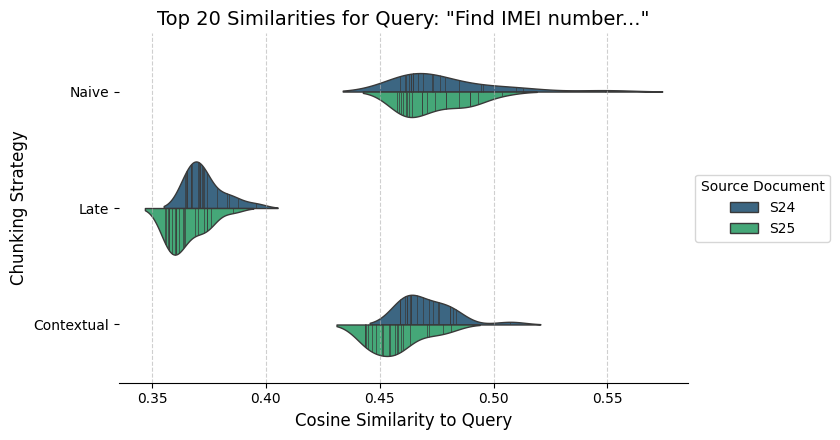

  Preparing visualization data using PCA...
  PCA complete.
  Creating PCA spatial plot...
  PCA spatial plot created.



--- Query Processing Loop Finished ---


In [85]:
# Cell 10C: Main Processing Loop for Queries

print(f"\n--- Starting Query Processing Loop ({len(query_list)} Queries) ---")

for i, query in enumerate(query_list):
    print(f"\n--- Processing Query {i+1}/{len(query_list)}: '{query}' ---")
    clear_output(wait=True) # Clear previous output for cleaner display per query

    # 1. Embed Query
    query_embedding = embedding_model.encode(query, convert_to_numpy=True)

    # 2. Calculate Top Results
    # Ensure df_results (containing ALL chunks) exists
    if 'df_results' not in locals() or df_results.empty:
         print("Error: df_results not found or empty. Run Cell 9 first.")
         break # Stop the loop if base data is missing
    current_query_top_df = calculate_top_results(query, query_embedding, df_results)

    # 3. Append results
    if not current_query_top_df.empty:
        current_query_top_df['query'] = query # Add query column for context
        all_query_top_results_dfs.append(current_query_top_df)
    else:
        print(f"  No similar results found for query '{query}'. Skipping plots.")
        continue # Skip to next query if no results

    # 4. Display Top Results DF for this query
    print(f"\nTop {N_TOP_RESULTS} Results DataFrame for Query {i+1}:")
    display_df = current_query_top_df.sort_values(by=['source', 'strategy', 'similarity'], ascending=[True, True, False])
    display_df = display_df[['source', 'strategy', 'similarity', 'text', 'query']] # Include query
    with pd.option_context('display.max_rows', N_TOP_RESULTS*2, 'display.max_colwidth', 80): # Show reasonable amount
        display(display_df)

    # 5. Generate and Display Violin Plot
    violin_fig = create_similarity_violin_plot(current_query_top_df, query, N_TOP_RESULTS)
    if violin_fig:
        plt.show() # Display matplotlib plot
        plt.close(violin_fig) # Close the figure to free memory

    # 6. Prepare Data for Spatial Plot
    viz_data = prepare_visualization_data(
        current_query_top_df,
        query, query_embedding,
        s24_doc_ref_embedding, s25_doc_ref_embedding,
        method=DIM_REDUCTION_METHOD
    )

    # 7. Generate and Display Spatial Plot
    if viz_data[0] is not None: # Check if prepare_visualization_data returned valid data
        embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts, dim1_label, dim2_label = viz_data
        spatial_fig = create_spatial_plot(
            embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts,
            query, N_TOP_RESULTS, DIM_REDUCTION_METHOD, dim1_label, dim2_label
        )
        if spatial_fig:
            spatial_fig.show() # Display plotly plot
    else:
        print("  Skipping spatial plot due to issues in data preparation.")

    # Optional: Add a small delay or prompt to continue if output is overwhelming
    # import time
    # time.sleep(2)
    # input("Press Enter to process next query...")


print("\n--- Query Processing Loop Finished ---")

In [66]:
# Cell 10D: Combine All Query Results (Optional)

if all_query_top_results_dfs:
    print("\n--- Aggregating Top Results Across All Queries ---")
    final_aggregated_df = pd.concat(all_query_top_results_dfs, ignore_index=True)
    print(f"Final aggregated DataFrame shape: {final_aggregated_df.shape}")
    print("Sample of aggregated data:")
    with pd.option_context('display.max_rows', 10, 'display.max_colwidth', 50):
      display(final_aggregated_df.head())

    # You can now save this DataFrame or perform further analysis
    # final_aggregated_df.to_csv("all_query_top_results.csv", index=False)
else:
    print("\nNo results were collected across queries to aggregate.")


--- Aggregating Top Results Across All Queries ---
Final aggregated DataFrame shape: (2400, 6)
Sample of aggregated data:


text  \
0  erheating ###### If you begin to feel uncomfor...   
1  the device may feel hotter to the touch. This ...   
2  orarily heat up because of increased battery c...   
3  device. - Turn off the Wi-Fi, GPS, and Bluetoo...   
4  turbed. - Game optimisation : Change the perfo...   

                                           embedding strategy source  \
0  [1.7556968, 1.1124961, -3.124593, 0.3630319, 1...    Naive    S24   
1  [2.292959, 0.667489, -3.1826441, 0.42750573, 1...    Naive    S24   
2  [2.1718588, 0.8374576, -3.5134013, 0.4611271, ...    Naive    S24   
3  [0.84546185, -0.10014602, -2.836687, 0.0244393...    Naive    S24   
4  [0.30159813, 0.6432628, -3.7750056, -0.0035530...    Naive    S24   

   similarity                    query  
0    0.734406  How to fix overheating?  
1    0.720344  How to fix overheating?  
2    0.720023  How to fix overheating?  
3    0.663139  How to fix overheating?  
4    0.649524  How to fix overheating?

In [88]:
# Cell 10A: Define Helper Functions for Query Processing and Visualization (UPDATED Plot Functions)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE # Uncomment if using t-SNE
# import umap # Uncomment if using UMAP
from plotly.subplots import make_subplots
import plotly.graph_objects as go # Ensure go is imported
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Keep for potential debugging displays
import os # Keep os import
import numpy as np # Keep numpy
import pandas as pd # Keep pandas

N_TOP_RESULTS = 20
DIM_REDUCTION_METHOD = 'pca' # Or 'umap', 'tsne'

# --- Function to Calculate Top Results (No changes needed) ---
def calculate_top_results(query, query_embedding, all_chunks_df):
    query_vec = query_embedding.reshape(1, -1)
    top_results_list = []
    unique_sources = all_chunks_df['source'].unique()
    unique_strategies = all_chunks_df['strategy'].unique()
    print(f"  Calculating Top {N_TOP_RESULTS} similarities for query: '{query}'")
    for source in unique_sources:
        for strategy in unique_strategies:
            group_df = all_chunks_df[(all_chunks_df['source'] == source) & (all_chunks_df['strategy'] == strategy)].copy()
            if group_df.empty: continue
            group_embeddings = np.stack(group_df['embedding'].values)
            if group_embeddings.ndim != 2: continue
            try:
                similarities = cosine_similarity(query_vec, group_embeddings)[0]
                group_df['similarity'] = similarities
                top_n_group = group_df.nlargest(N_TOP_RESULTS, 'similarity')
                top_results_list.append(top_n_group)
            except ValueError as ve: continue
    if top_results_list: return pd.concat(top_results_list, ignore_index=True)
    else: return pd.DataFrame()

# --- Function to Prepare Visualization Data (No changes needed) ---
def prepare_visualization_data(top_results_df, query, query_embedding, s24_ref_emb, s25_ref_emb, method='pca'):
    print(f"  Preparing visualization data using {method.upper()}...")
    if top_results_df.empty: return None, None, None, None, None
    top_embeddings_list = list(top_results_df['embedding'].values)
    top_strategies = list(top_results_df['strategy'].values)
    top_sources = list(top_results_df['source'].values)
    top_texts = list(top_results_df['text'].values)
    top_chunk_embeddings = np.array(top_embeddings_list)
    embeddings_for_viz = np.vstack([
        top_chunk_embeddings, query_embedding.reshape(1, -1),
        s24_ref_emb.reshape(1, -1), s25_ref_emb.reshape(1, -1)
    ]).astype(np.float32)
    viz_labels = top_strategies + ['Query', 'S24 Doc Ref', 'S25 Doc Ref']
    viz_sources = top_sources + ['Special', 'S24', 'S25']
    viz_hover_texts = [f"[{s}] {t[:100]}..." if len(t) > 100 else f"[{s}] {t}" for s, t in zip(top_sources, top_texts)] + \
                      [query, 'S24 Full Document (Pooled)', 'S25 Full Document (Pooled)']
    dim1_label, dim2_label = "", ""
    if method == 'pca':
        reducer_viz = PCA(n_components=2); embeddings_2d_viz = reducer_viz.fit_transform(embeddings_for_viz)
        dim1_label = f"PC 1 ({reducer_viz.explained_variance_ratio_[0]:.2%})"; dim2_label = f"PC 2 ({reducer_viz.explained_variance_ratio_[1]:.2%})"
    elif method == 'umap':
        try: import umap
        except ImportError: print("Error: UMAP requires 'umap-learn'."); return None, None, None, None, None
        reducer_viz = umap.UMAP(n_components=2, n_neighbors=min(15, embeddings_for_viz.shape[0]-1), min_dist=0.1, metric='cosine', random_state=42)
        embeddings_2d_viz = reducer_viz.fit_transform(embeddings_for_viz); dim1_label = "UMAP Dim 1"; dim2_label = "UMAP Dim 2"
    elif method == 'tsne':
        try: from sklearn.manifold import TSNE
        except ImportError: print("Error: t-SNE requires 'scikit-learn'."); return None, None, None, None, None
        reducer_viz = TSNE(n_components=2, perplexity=min(30, embeddings_for_viz.shape[0]-1), learning_rate='auto', n_iter=1000, init='pca', random_state=42, n_jobs=-1)
        embeddings_2d_viz = reducer_viz.fit_transform(embeddings_for_viz); dim1_label = "t-SNE Dim 1"; dim2_label = "t-SNE Dim 2"
    else: raise ValueError("Invalid dim_reduction_method.")
    print(f"  {method.upper()} complete.")
    return embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts, dim1_label, dim2_label

# --- Function to Create Spatial Plot (RETURNS FIG) --- ### MODIFIED ###
def create_spatial_plot(embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts, query, n_top, method_name, dim1_label, dim2_label):
    """Creates the subplot figure using Plotly. Returns the figure.""" ## MODIFIED ##
    print(f"  Creating {method_name.upper()} spatial plot object...")
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Naive', 'Late', 'Contextual'), shared_xaxes=True, shared_yaxes=True)
    # ... (keep the plotting logic inside the function exactly the same as before) ...
    color_map = {'S24': 'blue', 'S25': 'red', 'Special': 'black'}
    strategy_marker_map = {'Naive': 'circle', 'Late': 'square', 'Contextual': 'triangle-up'}
    special_marker_map = { 'Query': 'star', 'S24 Doc Ref': 'diamond', 'S25 Doc Ref': 'diamond'}
    special_marker_size = { 'Query': 16, 'S24 Doc Ref': 12, 'S25 Doc Ref': 12}
    special_labels_in_viz = ['Query', 'S24 Doc Ref', 'S25 Doc Ref']
    unique_sources_in_viz = list(np.unique([s for s in viz_sources if s != 'Special']))
    strategy_list = ['Naive', 'Late', 'Contextual']
    num_chunk_embeddings_viz = embeddings_2d_viz.shape[0] - len(special_labels_in_viz)
    show_legend_flags = {src: True for src in unique_sources_in_viz}
    for col_idx, strategy in enumerate(strategy_list):
        subplot_col = col_idx + 1
        for source in unique_sources_in_viz:
            indices = [i for i, (s, strat) in enumerate(zip(viz_sources[:num_chunk_embeddings_viz], viz_labels[:num_chunk_embeddings_viz])) if s == source and strat == strategy]
            if not indices: continue
            plot_name = f"{source} {strategy}"; legend_group = f"{source}"; marker_symbol = strategy_marker_map[strategy]
            fig.add_trace(go.Scatter(
                x=embeddings_2d_viz[indices, 0], y=embeddings_2d_viz[indices, 1], mode='markers', name=source, legendgroup=legend_group, showlegend=show_legend_flags[source],
                marker=dict(color=color_map[source], symbol=marker_symbol, size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                text=[viz_hover_texts[i] for i in indices], hoverinfo='text+name'
            ), row=1, col=subplot_col)
            show_legend_flags[source] = False
    show_special_legend = True
    for col_idx, strategy in enumerate(strategy_list):
        subplot_col = col_idx + 1
        for i, label in enumerate(special_labels_in_viz):
            point_index = num_chunk_embeddings_viz + i
            if point_index >= embeddings_2d_viz.shape[0]: continue
            point_source = viz_sources[point_index]
            fig.add_trace(go.Scatter(
                x=[embeddings_2d_viz[point_index, 0]], y=[embeddings_2d_viz[point_index, 1]], mode='markers+text', name=label, legendgroup='SpecialPoints', showlegend=show_special_legend,
                text=[f'<b>{label.replace(" Doc Ref", "")}</b>'], textposition="top center",
                marker=dict(color=color_map[point_source], symbol=special_marker_map[label], size=special_marker_size[label], opacity=0.95),
                hoverinfo='text+name', hovertext=[viz_hover_texts[point_index]]
            ), row=1, col=subplot_col)
        show_special_legend = False

    # Layout Application (Moved to loop for customization per query) ## MODIFIED ##
    fig.update_layout(
        title_text=f"Top {n_top} Results for Query '{query[:50]}...' ({method_name.upper()} Visualization)",
        width=1500, height=600,
        legend=dict(title="Legend", orientation="v", yanchor="top", y=1.0, xanchor="left", x=1.01),
        margin=dict(l=60, r=200, t=100, b=80), hovermode='closest', showlegend=True
    )
    fig.update_xaxes(title_text=dim1_label)
    fig.update_yaxes(title_text=dim2_label)
    print(f"  {method_name.upper()} spatial plot object created.")
    return fig # Return the figure object

# --- Function to Create Similarity Violin Plot (RETURNS FIG) --- ### MODIFIED ###
def create_similarity_violin_plot(top_results_df, query, n_top):
    """Creates the violin plot figure using Matplotlib/Seaborn. Returns the figure.""" ## MODIFIED ##
    print("  Creating similarity violin plot object...")
    if top_results_df.empty: return None
    num_strategies = len(top_results_df['strategy'].unique())
    figsize_height = 1.5 * num_strategies; figsize_width = 10
    fig, ax = plt.subplots(figsize=(figsize_width, figsize_height)) # Create figure and axes
    sns.violinplot(data=top_results_df, x='similarity', y='strategy', hue='source',
                   inner='stick', palette='viridis', split=True, linewidth=1, ax=ax)
    ax.set_title(f'Top {n_top} Similarities for Query: "{query[:50]}..."', fontsize=14)
    ax.set_xlabel('Cosine Similarity to Query', fontsize=12); ax.set_ylabel('Chunking Strategy', fontsize=12)
    sns.despine(top=True, right=True, bottom=False, left=True, ax=ax); ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.legend(title='Source Document', loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    print("  Similarity violin plot object created.")
    return fig # Return the figure object

print("Helper functions defined (plots now return figure objects).")

Helper functions defined (plots now return figure objects).


In [ ]:
# Cell 10B: Define Query List and Embed Document References

query_list = [
    # General Troubleshooting
    "How to fix overheating?",
    "Phone battery draining quickly",
    "Screen is flickering or lagging",
    "Camera autofocus not working",
    "Apps are crashing frequently",
    "Cannot connect to Wi-Fi",
    "Bluetooth pairing issues",
    "Android Auto not connecting",
    "Notifications are delayed",
    # Specific Features / How-To
    "How to use the S Pen?", # Relevant if S25 Ultra info is in PDF
    "Take macro photos",
    "Record 8K video",
    "Enable power saving mode",
    "Adjust screen vividness",
    "How to factory reset the phone?",
    "Enter safe mode",
    "Clear app cache",
    # Setup / Basic Info
    "How to insert SIM card?",
    "Wireless charging guide",
    "Find IMEI number"
    # Add more queries as desired
]

# Ensure source texts are loaded from Cell 7
if 's24_text' not in locals() or 's25_text' not in locals():
    raise NameError("Ensure s24_text and s25_text are loaded from PDF in Cell 7.")

# Embed document references ONCE
print("Embedding Document References...")
s24_doc_ref_embedding = embedding_model.encode(sentences=s24_text, convert_to_numpy=True)
s25_doc_ref_embedding = embedding_model.encode(sentences=s25_text, convert_to_numpy=True)
print("Document Reference embeddings created.")

# List to store all top results DataFrames
all_query_top_results_dfs = []

print(f"\nDefined {len(query_list)} queries.")

Embedding Document References...
Document Reference embeddings created.

Defined 20 queries.


In [99]:
# @title Prepare Markdown to save with text and images
# Cell 10C: Main Processing Loop for Queries (UPDATED for Saving Results)

import re # For slugify
import os # Added back just in case it was missed elsewhere

# --- Configuration ---
OUTPUT_DIR = "query_results"
IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
MARKDOWN_FILE = os.path.join(OUTPUT_DIR, "query_analysis_report.md")
# --- End Configuration ---

# Create directories if they don't exist
os.makedirs(IMAGES_DIR, exist_ok=True)
print(f"Output directory: '{OUTPUT_DIR}'")
print(f"Images directory: '{IMAGES_DIR}'")

# Simple function to create safe filenames from queries
def slugify(text, max_len=40):
    text = re.sub(r'[^\w\s-]', '', text).strip().lower() # Remove non-alphanumeric (keep space, hyphen)
    text = re.sub(r'[-\s]+', '-', text) # Replace space/hyphen runs with single hyphen
    return text[:max_len]

# Ensure base data and references are ready
if 'df_results' not in locals() or df_results.empty: raise ValueError("Base df_results is missing or empty.")
if 's24_doc_ref_embedding' not in locals() or 's25_doc_ref_embedding' not in locals(): raise ValueError("Doc reference embeddings missing.")
if 'query_list' not in locals() or not query_list: raise ValueError("query_list is missing or empty.")
# Ensure model_name from Cell 3 is available
if 'model_name' not in locals(): raise NameError("Variable 'model_name' not found. Ensure Cell 3 was run.")


# List to store all top results DataFrames (still useful)
all_query_top_results_dfs = []

print(f"\n--- Starting Query Processing & Saving Loop ({len(query_list)} Queries) ---")
print(f"Results will be saved to: {MARKDOWN_FILE}")

# Open the markdown file in append mode
with open(MARKDOWN_FILE, "w", encoding="utf-8") as md_file: # Start with 'w' to overwrite previous runs
    md_file.write(f"# Query Analysis Report ({pd.Timestamp.now()})\n\n")
    # --- FIX HERE: Use the 'model_name' variable from Cell 3 ---
    md_file.write(f"Embedding Model: `{model_name}`\n")
    # --- END FIX ---
    md_file.write(f"Dimensionality Reduction for Spatial Plots: `{DIM_REDUCTION_METHOD.upper()}`\n")
    md_file.write(f"Number of Top Results per Group: `{N_TOP_RESULTS}`\n\n")

    for i, query in enumerate(query_list):
        print(f"\n--- Processing Query {i+1}/{len(query_list)}: '{query}' ---")

        query_slug = slugify(query) # Create filename-safe version of query

        # 1. Embed Query
        query_embedding = embedding_model.encode(query, convert_to_numpy=True)

        # 2. Calculate Top Results
        current_query_top_df = calculate_top_results(query, query_embedding, df_results)

        # 3. Append to overall list and check if empty
        if not current_query_top_df.empty:
            current_query_top_df['query'] = query
            all_query_top_results_dfs.append(current_query_top_df)
        else:
            print(f"  No similar results found for query '{query}'. Skipping plots and table.")
            md_file.write(f"## Query {i+1}: {query}\n\n")
            md_file.write("*No similar results found.*\n\n")
            md_file.write("---\n\n")
            continue # Skip to next query

        # --- Append Results to Markdown File ---
        md_file.write(f"## Query {i+1}: `{query}`\n\n")

        # 4. Append Top Results Table
        print("  Appending results table to Markdown...")
        md_file.write("### Top Results Dataframe\n\n")
        display_df = current_query_top_df.sort_values(by=['source', 'strategy', 'similarity'], ascending=[True, True, False])
        display_df_md = display_df[['source', 'strategy', 'similarity', 'text']] # Select columns
        try:
          md_table = display_df_md.to_markdown(index=False, floatfmt=".4f") # Format similarity
          md_file.write(md_table)
          md_file.write("\n\n")
        except Exception as table_err:
            print(f"  Error converting table to markdown: {table_err}")
            md_file.write("*Error generating results table.*\n\n")


        # 5. Generate, Save, and Append Violin Plot
        print("  Generating and saving violin plot...")
        violin_fig_obj = create_similarity_violin_plot(current_query_top_df, query, N_TOP_RESULTS)
        if violin_fig_obj:
            violin_img_filename = f"violin_q{i+1}_{query_slug}.png"
            violin_img_path_rel = os.path.join("images", violin_img_filename) # Relative path for MD
            violin_img_path_abs = os.path.join(IMAGES_DIR, violin_img_filename) # Absolute path for saving
            try:
                violin_fig_obj.savefig(violin_img_path_abs, bbox_inches='tight')
                md_file.write("### Similarity Distribution\n\n")
                md_file.write(f"![Similarity Violin Plot]({violin_img_path_rel})\n\n")
                plt.close(violin_fig_obj) # Close plot to free memory
                print(f"  Saved violin plot to: {violin_img_path_abs}")
            except Exception as plot_err:
                print(f"  Error saving violin plot: {plot_err}")
                md_file.write("*Error generating/saving similarity plot.*\n\n")
        else:
             md_file.write("*Could not generate similarity plot.*\n\n")


        # 6. Prepare Data for Spatial Plot
        viz_data = prepare_visualization_data(
            current_query_top_df, query, query_embedding,
            s24_doc_ref_embedding, s25_doc_ref_embedding, method=DIM_REDUCTION_METHOD
        )

        # 7. Generate, Save, and Append Spatial Plot
        if viz_data[0] is not None:
            print(f"  Generating and saving {DIM_REDUCTION_METHOD.upper()} spatial plot...")
            embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts, dim1_label, dim2_label = viz_data
            spatial_fig_obj = create_spatial_plot(
                embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts,
                query, N_TOP_RESULTS, DIM_REDUCTION_METHOD, dim1_label, dim2_label
            )
            if spatial_fig_obj:
                spatial_img_filename = f"{DIM_REDUCTION_METHOD}_q{i+1}_{query_slug}.png"
                spatial_img_path_rel = os.path.join("images", spatial_img_filename) # Relative path
                spatial_img_path_abs = os.path.join(IMAGES_DIR, spatial_img_filename) # Absolute path
                try:
                    spatial_fig_obj.write_image(spatial_img_path_abs, scale=2) # Use scale for better resolution
                    md_file.write(f"### {DIM_REDUCTION_METHOD.upper()} Spatial Visualization\n\n")
                    md_file.write(f"![{DIM_REDUCTION_METHOD.upper()} Spatial Plot]({spatial_img_path_rel})\n\n")
                    print(f"  Saved {DIM_REDUCTION_METHOD.upper()} plot to: {spatial_img_path_abs}")
                except Exception as plot_err:
                    print(f"  Error saving {DIM_REDUCTION_METHOD.upper()} plot: {plot_err}")
                    print("  Ensure 'kaleido' is installed and potentially restart kernel.")
                    md_file.write(f"*Error generating/saving {DIM_REDUCTION_METHOD.upper()} plot.*\n\n")
            else:
                 md_file.write(f"*Could not generate {DIM_REDUCTION_METHOD.upper()} plot object.*\n\n")
        else:
            print("  Skipping spatial plot due to issues in data preparation.")
            md_file.write(f"*Skipping {DIM_REDUCTION_METHOD.upper()} plot - data prep failed.*\n\n")

        # Add separator for next query
        md_file.write("---\n\n")
        print(f"  Finished saving results for query {i+1}.")


print("\n--- Query Processing Loop Finished ---")
print(f"Markdown report saved to: {MARKDOWN_FILE}")

Output directory: 'query_results'
Images directory: 'query_results/images'

--- Starting Query Processing & Saving Loop (20 Queries) ---
Results will be saved to: query_results/query_analysis_report.md

--- Processing Query 1/20: 'How to fix overheating?' ---
  Calculating Top 20 similarities for query: 'How to fix overheating?'
  Appending results table to Markdown...
  Generating and saving violin plot...
  Creating similarity violin plot object...
  Similarity violin plot object created.
  Saved violin plot to: query_results/images/violin_q1_how-to-fix-overheating.png
  Preparing visualization data using PCA...
  PCA complete.
  Generating and saving PCA spatial plot...
  Creating PCA spatial plot object...
  PCA spatial plot object created.
  Error saving PCA plot: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

  Ensure 'kaleido' is installed and potentially restart kernel.
  Finished saving res

In [104]:
# Cell 10C: Main Processing Loop for Queries (UPDATED for Saving & Simplified DF Display)

import re # For slugify
import os # Keep os import
import pandas as pd # Keep pandas import
import matplotlib.pyplot as plt # Keep plt import
from IPython.display import display, clear_output # Keep display imports

# --- Configuration ---
OUTPUT_DIR = "query_results"
IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
MARKDOWN_FILE = os.path.join(OUTPUT_DIR, "query_analysis_report.md")
# --- End Configuration ---

# Create directories if they don't exist
os.makedirs(IMAGES_DIR, exist_ok=True)
print(f"Output directory: '{OUTPUT_DIR}'")
print(f"Images directory: '{IMAGES_DIR}'")

# Simple function to create safe filenames from queries
def slugify(text, max_len=40):
    text = re.sub(r'[^\w\s-]', '', text).strip().lower() # Remove non-alphanumeric (keep space, hyphen)
    text = re.sub(r'[-\s]+', '-', text) # Replace space/hyphen runs with single hyphen
    return text[:max_len]

# Ensure base data and references are ready
if 'df_results' not in locals() or df_results.empty: raise ValueError("Base df_results is missing or empty.")
if 's24_doc_ref_embedding' not in locals() or 's25_doc_ref_embedding' not in locals(): raise ValueError("Doc reference embeddings missing.")
if 'query_list' not in locals() or not query_list: raise ValueError("query_list is missing or empty.")
if 'model_name' not in locals(): raise NameError("Variable 'model_name' not found. Ensure Cell 3 was run.")


# List to store all top results DataFrames (still useful)
all_query_top_results_dfs = []

print(f"\n--- Starting Query Processing & Saving Loop ({len(query_list)} Queries) ---")
print(f"Results will be saved to: {MARKDOWN_FILE}")

# Open the markdown file in append mode
with open(MARKDOWN_FILE, "w", encoding="utf-8") as md_file: # Start with 'w' to overwrite previous runs
    md_file.write(f"# Query Analysis Report ({pd.Timestamp.now()})\n\n")
    md_file.write(f"Embedding Model: `{model_name}`\n")
    md_file.write(f"Dimensionality Reduction for Spatial Plots: `{DIM_REDUCTION_METHOD.upper()}`\n")
    md_file.write(f"Number of Top Results per Group (before final sort): `{N_TOP_RESULTS}`\n\n") # Clarify N refers to per-group retrieval

    for i, query in enumerate(query_list):
        print(f"\n--- Processing Query {i+1}/{len(query_list)}: '{query}' ---")
        # clear_output(wait=True) # Keep this commented out unless output becomes too much

        query_slug = slugify(query) # Create filename-safe version of query

        # 1. Embed Query
        query_embedding = embedding_model.encode(query, convert_to_numpy=True)

        # 2. Calculate Top Results (gets top N per source/strategy group)
        current_query_top_df = calculate_top_results(query, query_embedding, df_results)

        # 3. Append to overall list and check if empty
        if not current_query_top_df.empty:
            current_query_top_df['query'] = query
            all_query_top_results_dfs.append(current_query_top_df)
        else:
            print(f"  No similar results found for query '{query}'. Skipping plots and table.")
            md_file.write(f"## Query {i+1}: {query}\n\n")
            md_file.write("*No similar results found.*\n\n")
            md_file.write("---\n\n")
            continue # Skip to next query

        # --- Append Results to Markdown File ---
        md_file.write(f"## Query {i+1}: `{query}`\n\n")

        # 4. Append Top Results Table (SORTED BY OVERALL SIMILARITY) ### MODIFIED ###
        print("  Appending top results table (sorted by similarity) to Markdown...")
        md_file.write(f"### Top {len(current_query_top_df)} Overall Results (from Top {N_TOP_RESULTS} per Group)\n\n") # Clarified title
        # Sort the combined top results by similarity descending
        display_df = current_query_top_df.sort_values(by='similarity', ascending=False)
        # Select columns for display
        display_df_md = display_df[['similarity', 'source', 'strategy', 'text']] # Reordered for clarity
        try:
          # Convert to markdown
          md_table = display_df_md.to_markdown(index=False, floatfmt=".4f") # Format similarity
          md_file.write(md_table)
          md_file.write("\n\n")
        except Exception as table_err:
            print(f"  Error converting table to markdown: {table_err}")
            md_file.write("*Error generating results table.*\n\n")


        # 5. Generate, Save, and Append Violin Plot (No change needed here - operates on the same df)
        print("  Generating and saving violin plot...")
        violin_fig_obj = create_similarity_violin_plot(current_query_top_df, query, N_TOP_RESULTS)
        # ... (saving logic remains the same) ...
        if violin_fig_obj:
            violin_img_filename = f"violin_q{i+1}_{query_slug}.png"
            violin_img_path_rel = os.path.join("images", violin_img_filename)
            violin_img_path_abs = os.path.join(IMAGES_DIR, violin_img_filename)
            try:
                violin_fig_obj.savefig(violin_img_path_abs, bbox_inches='tight')
                md_file.write("### Similarity Distribution by Strategy & Source\n\n") # Keep title specific
                md_file.write(f"![Similarity Violin Plot]({violin_img_path_rel})\n\n")
                plt.close(violin_fig_obj)
                print(f"  Saved violin plot to: {violin_img_path_abs}")
            except Exception as plot_err:
                print(f"  Error saving violin plot: {plot_err}")
                md_file.write("*Error generating/saving similarity plot.*\n\n")
        else:
             md_file.write("*Could not generate similarity plot.*\n\n")


        # 6. Prepare Data for Spatial Plot (No change needed here - operates on the same df)
        viz_data = prepare_visualization_data(
            current_query_top_df, query, query_embedding,
            s24_doc_ref_embedding, s25_doc_ref_embedding, method=DIM_REDUCTION_METHOD
        )

        # 7. Generate, Save, and Append Spatial Plot (No change needed here)
        if viz_data[0] is not None:
            print(f"  Generating and saving {DIM_REDUCTION_METHOD.upper()} spatial plot...")
            embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts, dim1_label, dim2_label = viz_data
            spatial_fig_obj = create_spatial_plot(
                embeddings_2d_viz, viz_labels, viz_sources, viz_hover_texts,
                query, N_TOP_RESULTS, DIM_REDUCTION_METHOD, dim1_label, dim2_label
            )
            # ... (saving logic remains the same) ...
            if spatial_fig_obj:
                spatial_img_filename = f"{DIM_REDUCTION_METHOD}_q{i+1}_{query_slug}.png"
                spatial_img_path_rel = os.path.join("images", spatial_img_filename)
                spatial_img_path_abs = os.path.join(IMAGES_DIR, spatial_img_filename)
                try:
                    spatial_fig_obj.write_image(spatial_img_path_abs, scale=2)
                    md_file.write(f"### {DIM_REDUCTION_METHOD.upper()} Spatial Visualization (Top Results)\n\n")
                    md_file.write(f"![{DIM_REDUCTION_METHOD.upper()} Spatial Plot]({spatial_img_path_rel})\n\n")
                    print(f"  Saved {DIM_REDUCTION_METHOD.upper()} plot to: {spatial_img_path_abs}")
                except Exception as plot_err:
                    print(f"  Error saving {DIM_REDUCTION_METHOD.upper()} plot: {plot_err}")
                    md_file.write(f"*Error generating/saving {DIM_REDUCTION_METHOD.upper()} plot.*\n\n")
            else:
                 md_file.write(f"*Could not generate {DIM_REDUCTION_METHOD.upper()} plot object.*\n\n")
        else:
            print("  Skipping spatial plot due to issues in data preparation.")
            md_file.write(f"*Skipping {DIM_REDUCTION_METHOD.upper()} plot - data prep failed.*\n\n")

        # Add separator for next query
        md_file.write("---\n\n")
        print(f"  Finished saving results for query {i+1}.")


print("\n--- Query Processing Loop Finished ---")
print(f"Markdown report saved to: {MARKDOWN_FILE}")

Output directory: 'query_results'
Images directory: 'query_results/images'

--- Starting Query Processing & Saving Loop (20 Queries) ---
Results will be saved to: query_results/query_analysis_report.md

--- Processing Query 1/20: 'How to fix overheating?' ---
  Calculating Top 20 similarities for query: 'How to fix overheating?'
  Appending top results table (sorted by similarity) to Markdown...
  Generating and saving violin plot...
  Creating similarity violin plot object...
  Similarity violin plot object created.
  Saved violin plot to: query_results/images/violin_q1_how-to-fix-overheating.png
  Preparing visualization data using PCA...
  PCA complete.
  Generating and saving PCA spatial plot...
  Creating PCA spatial plot object...
  PCA spatial plot object created.
  Error saving PCA plot: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

  Finished saving results for query 1.

--- Processing Que

In [96]:
# Cell 10D: Optional PDF Conversion (Corrected Method Call)

import markdown_pdf
import os # Ensure os is imported

# Check if the Markdown file was created
if 'MARKDOWN_FILE' not in locals() or not os.path.exists(MARKDOWN_FILE):
     print("\nSkipping PDF Conversion: Markdown report file variable not found or file does not exist.")
elif 'OUTPUT_DIR' not in locals():
     print("\nSkipping PDF Conversion: OUTPUT_DIR variable not found.")
else:
    PDF_FILE = os.path.join(OUTPUT_DIR, "query_analysis_report.pdf")
    print(f"\n--- Attempting Markdown to PDF Conversion ---")
    print(f"Source: {MARKDOWN_FILE}")
    print(f"Output: {PDF_FILE}")
    try:
        # Configure options during instantiation
        converter = markdown_pdf.MarkdownPdf(toc_level=2)

        # Add PDF metadata BEFORE conversion
        converter.meta['title'] = 'Query Analysis Report'
        converter.meta['author'] = 'Chunking Analysis Script' # Optional author

        # Convert the file using the correct method name
        converter.from_markdown_file( # <--- FIX HERE: Use from_markdown_file
            markdown_file=MARKDOWN_FILE,
            output_file=PDF_FILE
            # You can add other options here if needed, e.g., css_file_path=...
        )

        print(f"Successfully converted Markdown to PDF: {PDF_FILE}")
    except ImportError:
        print("\nPDF Conversion skipped: 'markdown-pdf' library not found.")
        print("Install it using: !pip install markdown-pdf")
    except FileNotFoundError as fnf_err:
         print(f"\nPDF Conversion failed: Could not find file - {fnf_err}")
         print("Ensure the markdown file was generated correctly.")
    except AttributeError as ae:
         print(f"\nPDF Conversion failed: {ae}")
         print("Ensure the 'markdown-pdf' library is installed correctly and check its version/usage.")
    except Exception as pdf_err:
        print(f"\nPDF Conversion failed: {pdf_err}")
        print("Ensure required dependencies (like WeasyPrint via 'pip install markdown-pdf[all]') might be needed if errors persist.")


--- Attempting Markdown to PDF Conversion ---
Source: query_results/query_analysis_report.md
Output: query_results/query_analysis_report.pdf

PDF Conversion failed: 'MarkdownPdf' object has no attribute 'from_markdown_file'
Ensure the 'markdown-pdf' library is installed correctly and check its version/usage.


In [100]:
# Cell 10D: Optional PDF Conversion (Revised Method Call Pattern - Attempt 3)

import markdown_pdf
import os # Ensure os is imported

# Check if the Markdown file was created
if 'MARKDOWN_FILE' not in locals() or not os.path.exists(MARKDOWN_FILE):
     print("\nSkipping PDF Conversion: Markdown report file variable not found or file does not exist.")
elif 'OUTPUT_DIR' not in locals():
     print("\nSkipping PDF Conversion: OUTPUT_DIR variable not found.")
else:
    PDF_FILE = os.path.join(OUTPUT_DIR, "query_analysis_report.pdf")
    print(f"\n--- Attempting Markdown to PDF Conversion ---")
    print(f"Source: {MARKDOWN_FILE}")
    print(f"Output: {PDF_FILE}")
    try:
        # 1. Read the Markdown content from the file
        print("  Reading Markdown file content...")
        with open(MARKDOWN_FILE, 'r', encoding='utf-8') as f:
            md_content = f.read()
        print("  Markdown content read.")

        # 2. Instantiate the converter, passing content as the first argument
        # Assuming the first argument is the markdown source text
        # Pass other options as keyword arguments
        print("  Instantiating converter, passing content positionally...")
        converter = markdown_pdf.MarkdownPdf(md_content, toc_level=2)

        # 3. Add metadata (Try setting attributes or using meta dict if available)
        if hasattr(converter, 'meta'):
             converter.meta['title'] = 'Query Analysis Report'
             converter.meta['author'] = 'Chunking Analysis Script'
        # else: # Try direct attributes if meta doesn't exist
        #    if hasattr(converter, 'title'): converter.title = 'Query Analysis Report'
        #    if hasattr(converter, 'author'): converter.author = 'Chunking Analysis Script'


        # 4. Save the PDF using the .save() method (Assuming this exists based on common patterns)
        print("  Calling 'save' method...")
        converter.save(PDF_FILE)

        print(f"Successfully converted Markdown to PDF: {PDF_FILE}")

    except ImportError:
        print("\nPDF Conversion skipped: 'markdown-pdf' library not found.")
        print("Install it using: !pip install markdown-pdf")
    except FileNotFoundError as fnf_err:
         print(f"\nPDF Conversion failed: Could not find file - {fnf_err}")
         print("Ensure the markdown file was generated correctly.")
    except TypeError as te:
         print(f"\nPDF Conversion failed due to TypeError: {te}")
         print("This likely means the arguments passed during instantiation (MarkdownPdf(...)) are incorrect.")
         print("Check the library's expected __init__ signature.")
    except AttributeError as ae:
         print(f"\nPDF Conversion failed due to AttributeError: {ae}")
         print("This likely means the method used (e.g., 'save') does not exist.")
         print("Please check the specific documentation or examples for the installed 'markdown-pdf' version.")
    except Exception as pdf_err:
        print(f"\nPDF Conversion failed: {pdf_err}")
        print("Ensure required dependencies (like WeasyPrint via 'pip install markdown-pdf[all]') might be needed if errors persist.")
        # You might need to check WeasyPrint installation and its dependencies (Pango, Cairo, etc.)


--- Attempting Markdown to PDF Conversion ---
Source: query_results/query_analysis_report.md
Output: query_results/query_analysis_report.pdf
  Reading Markdown file content...
  Markdown content read.
  Instantiating converter, passing content positionally...

PDF Conversion failed due to TypeError: MarkdownPdf.__init__() got multiple values for argument 'toc_level'
This likely means the arguments passed during instantiation (MarkdownPdf(...)) are incorrect.
Check the library's expected __init__ signature.


In [94]:
# Cell 10E: Combine All Query Results (Optional - Keep as before)

if all_query_top_results_dfs:
    print("\n--- Aggregating Top Results Across All Queries ---")
    final_aggregated_df = pd.concat(all_query_top_results_dfs, ignore_index=True)
    print(f"Final aggregated DataFrame shape: {final_aggregated_df.shape}")
    print("Sample of aggregated data:")
    with pd.option_context('display.max_rows', 10, 'display.max_colwidth', 50):
      display(final_aggregated_df.head())
    # Optional: Save aggregated results
    # aggregated_csv_path = os.path.join(OUTPUT_DIR, "all_queries_aggregated_top_results.csv")
    # final_aggregated_df.to_csv(aggregated_csv_path, index=False)
    # print(f"Saved aggregated results to: {aggregated_csv_path}")
else:
    print("\nNo results were collected across queries to aggregate.")


--- Aggregating Top Results Across All Queries ---
Final aggregated DataFrame shape: (2400, 6)
Sample of aggregated data:


text  \
0  erheating ###### If you begin to feel uncomfor...   
1  the device may feel hotter to the touch. This ...   
2  orarily heat up because of increased battery c...   
3  device. - Turn off the Wi-Fi, GPS, and Bluetoo...   
4  turbed. - Game optimisation : Change the perfo...   

                                           embedding strategy source  \
0  [1.7556968, 1.1124961, -3.124593, 0.3630319, 1...    Naive    S24   
1  [2.292959, 0.667489, -3.1826441, 0.42750573, 1...    Naive    S24   
2  [2.1718588, 0.8374576, -3.5134013, 0.4611271, ...    Naive    S24   
3  [0.84546185, -0.10014602, -2.836687, 0.0244393...    Naive    S24   
4  [0.30159813, 0.6432628, -3.7750056, -0.0035530...    Naive    S24   

   similarity                    query  
0    0.734406  How to fix overheating?  
1    0.720344  How to fix overheating?  
2    0.720023  How to fix overheating?  
3    0.663139  How to fix overheating?  
4    0.649524  How to fix overheating?

In [101]:
# Cell: Zip and Download the Images Folder

import os
from google.colab import files

# --- Define Paths ---
folder_to_download = "/content/query_results/images"
zip_filename = "query_results_images.zip"
# ---

# Check if the source folder exists
if not os.path.exists(folder_to_download):
    print(f"ERROR: Source folder not found at '{folder_to_download}'")
    print("Ensure the previous cells ran correctly and created the folder.")
else:
    print(f"Zipping folder: '{folder_to_download}'...")
    # Use the 'zip' command available in the Colab environment
    # -r : recursive (include subdirectories and their contents)
    # -q : quiet (suppress normal zip output messages)
    !zip -r -q {zip_filename} {folder_to_download}

    # Check if zip file was created
    if os.path.exists(zip_filename):
        print(f"Folder successfully zipped to '{zip_filename}'.")
        print("Starting download...")
        # Trigger browser download
        files.download(zip_filename)
        print(f"Download initiated for '{zip_filename}'. Check your browser's downloads.")
        # Optional: Clean up the zip file after download starts
        # print(f"Removing temporary zip file '{zip_filename}'...")
        # !rm {zip_filename}
    else:
        print(f"ERROR: Failed to create zip file '{zip_filename}'.")

Zipping folder: '/content/query_results/images'...
Folder successfully zipped to 'query_results_images.zip'.
Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for 'query_results_images.zip'. Check your browser's downloads.


In [67]:
# Cell 11: Perform PCA
print("Performing PCA...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings_for_pca)
print(f"PCA executed. Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Shape of 2D embeddings: {embeddings_2d.shape}")

Performing PCA...
PCA executed. Explained variance ratio: [0.09257517 0.06944329]
Shape of 2D embeddings: (1993, 2)


In [68]:
# Cell 12: Create Visualization with Plotly (UPDATED for Source Colors & Strategy Shapes)
print("Creating Plotly visualization...")
fig = go.Figure()

# Define COLOR map based on SOURCE document
color_map = {
    'S24': 'blue',     # S24 will use blue
    'S25': 'red',      # S25 will use red
    'Special': 'black' # For Query
}

# Define MARKER SYMBOL map based on STRATEGY
strategy_marker_map = {
    'Naive': 'circle',
    'Late': 'square',
    'Contextual': 'triangle-up'
}

# Define marker properties for special points
special_marker_map = {
    'Query': 'star',
    'S24 Doc Ref': 'diamond',
    'S25 Doc Ref': 'diamond' # Same shape for doc refs, color distinguishes
}
special_marker_size = {
     'Query': 16,
     'S24 Doc Ref': 12,
     'S25 Doc Ref': 12
}

unique_sources = ['S24', 'S25']
unique_strategies = ['Naive', 'Late', 'Contextual']

# 1. Plot Chunks (iterating through source and strategy)
for source in unique_sources:
    for strategy in unique_strategies:
        # Find indices matching BOTH source and strategy
        # Use the original separate lists 'sources' and 'strategies' here
        indices = [i for i, (s, strat) in enumerate(zip(sources, strategies))
                   if s == source and strat == strategy]

        if not indices:
            # print(f"  No points found for: {source} {strategy}") # Optional debug
            continue

        plot_name = f"{source} {strategy}"
        print(f"  Plotting {len(indices)} points for: {plot_name}")
        fig.add_trace(go.Scatter(
            x=embeddings_2d[indices, 0],
            y=embeddings_2d[indices, 1],
            mode='markers',
            name=plot_name, # Legend entry combines source and strategy
            marker=dict(
                color=color_map[source],            # Color by source
                symbol=strategy_marker_map[strategy], # Shape by strategy
                size=8,
                opacity=0.7,
                line=dict(width=1, color='DarkSlateGrey') # Add outline for clarity
            ),
            text=[combined_hover_texts[i] for i in indices], # Use combined list for hover text index
            hoverinfo='text+name'
        ))

# 2. Plot Special Points (Query, Doc Refs)
num_chunk_embeddings = embeddings.shape[0] # Number of actual chunk embeddings before special points
for i, label in enumerate(special_labels):
    point_index = num_chunk_embeddings + i # Calculate index in the PCA data
    point_source = special_sources[i] # Get source ('Special', 'S24', 'S25') for color

    print(f"  Plotting Special Point: {label} at index {point_index}")
    fig.add_trace(go.Scatter(
        x=[embeddings_2d[point_index, 0]],
        y=[embeddings_2d[point_index, 1]],
        mode='markers+text',
        name=label,
        text=[f'<b>{label.replace(" Doc Ref", "")}</b>'], # Short label on plot
        textposition="top center",
        marker=dict(
            color=color_map[point_source],       # Use source for color (black for Query)
            symbol=special_marker_map[label],    # Unique shape
            size=special_marker_size[label],
            opacity=0.95
        ),
        hoverinfo='text+name',
        hovertext=[combined_hover_texts[point_index]] # Get hover text by index
    ))


print("Plot object created.")

Creating Plotly visualization...
  Plotting 477 points for: S24 Naive
  Plotting 72 points for: S24 Late
  Plotting 477 points for: S24 Contextual
  Plotting 446 points for: S25 Naive
  Plotting 72 points for: S25 Late
  Plotting 446 points for: S25 Contextual
  Plotting Special Point: Query at index 1990
  Plotting Special Point: S24 Doc Ref at index 1991
  Plotting Special Point: S25 Doc Ref at index 1992
Plot object created.


In [69]:
# Cell 13: Update layout and show plot
print("Updating plot layout and displaying...")
fig.update_layout(
    title=f"PCA Visualization: S24 (Blue) vs S25 (Red) Embeddings by Strategy", # Updated title
    xaxis_title=f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})",
    yaxis_title=f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})",
    width=1100, # Slightly wider for potentially more legend items
    height=800,
    legend=dict(
        orientation="v", # Vertical legend might be better
        yanchor="top", y=1.0,
        xanchor="left", x=1.01 # Place legend outside plot area
        ),
    margin=dict(l=50, r=180, t=100, b=50), # Adjust right margin for legend
    hovermode='closest'
)
fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


**Cell 14: Interpretation (Updated for Two Documents)**

**Interpreting the Visualization (S24 vs S25):**

**Color indicates the source document (Blue=S24, Red=S25).**
**Marker shape indicates the chunking strategy (Circle=Naive, Square=Late, Triangle=Contextual).**

1.  **Document Separation:** Observe the overall placement of blue points (S24) versus red points (S25). Do the two documents form distinct clusters in the embedding space, suggesting they discuss different topics or use different language? Or do they overlap significantly?
2.  **Strategy Comparison *Within* a Document:**
    *   For S24 (Blue): How does the scatter of Naive circles compare to the Late squares and Contextual triangles? Are Late/Contextual more clustered? Where are they relative to the blue S24 Doc Ref diamond?
    *   For S25 (Red): Perform the same comparison using the red points and the red S25 Doc Ref diamond.
3.  **Strategy Comparison *Between* Documents:**
    *   Does Naive chunking (circles) show similar levels of scatter for both S24 (blue) and S25 (red)?
    *   Does Late chunking (squares) create similarly tight clusters for both documents? Are these clusters located similarly relative to their respective document references (diamonds)?
    *   How does Contextual chunking (triangles) behave for S24 vs S25? Does the LLM summary have a similar effect on both?
4.  **Proximity to Query (Black Star):**
    *   Which document's chunks (blue or red) are generally closer to the query?
    *   Within the closer document, which chunking strategy (shape) yields points nearest the query? This suggests the best combination for this specific query.
5.  **Document Reference Points (Diamonds):** The blue diamond represents the overall S24 document, and the red diamond represents S25. Their proximity indicates the semantic similarity *between the two full documents* according to the embedding model. The location of chunk clusters relative to *their own* document reference is key.

**Key Considerations:**
*   **Content Difference:** The primary driver of separation between blue and red clusters will be the actual content difference between the S24 and S25 support documents.
*   **Model Behavior:** The Nomic model determines the overall structure of the embedding space.
*   **Late Chunking (Token Pooling):** Should show distinct clusters for S24 (blue squares) and S25 (red squares), reflecting context awareness within each document.

In [70]:
# Cell 12: Create Visualization with Plotly (UPDATED with Subplots/Faceting)
from plotly.subplots import make_subplots

print("Creating Plotly visualization with Subplots...")

# Create subplots: 1 row, 3 columns for Naive, Late, Contextual
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Naive Chunking', 'Late Chunking (Token Pool)', 'Contextual Chunking'),
    shared_xaxes=True, # Share axes if desired, or set to False
    shared_yaxes=True
)

# Define COLOR map based on SOURCE document (same as before)
color_map = {
    'S24': 'blue',
    'S25': 'red',
    'Special': 'black' # For Query
}

# Define MARKER SYMBOL map based on STRATEGY (only used for lookup, not direct plotting now)
strategy_marker_map = {
    'Naive': 'circle',
    'Late': 'square',
    'Contextual': 'triangle-up'
}
strategy_list = ['Naive', 'Late', 'Contextual'] # For iterating cols

# Define marker properties for special points (same as before)
special_marker_map = { 'Query': 'star', 'S24 Doc Ref': 'diamond', 'S25 Doc Ref': 'diamond'}
special_marker_size = { 'Query': 16, 'S24 Doc Ref': 12, 'S25 Doc Ref': 12}
special_labels = ['Query', 'S24 Doc Ref', 'S25 Doc Ref']
special_sources = ['Special', 'S24', 'S25']

unique_sources = ['S24', 'S25']

# --- Plot Chunks in Subplots ---
show_legend_flags = {'S24': True, 'S25': True} # Control legend entry creation

for col_idx, strategy in enumerate(strategy_list):
    print(f"  Processing subplot for: {strategy}")
    subplot_col = col_idx + 1 # Subplot columns are 1-indexed

    for source in unique_sources:
        # Find indices matching BOTH source and strategy
        indices = [i for i, (s, strat) in enumerate(zip(sources, strategies))
                   if s == source and strat == strategy]

        if not indices: continue

        plot_name = f"{source} {strategy}" # Full name for hover/internal use
        legend_group = f"{source}" # Group legend items by source
        marker_symbol = strategy_marker_map[strategy] # Get shape for this strategy

        print(f"    Plotting {len(indices)} points for: {plot_name} in col {subplot_col}")
        fig.add_trace(go.Scatter(
            x=embeddings_2d[indices, 0],
            y=embeddings_2d[indices, 1],
            mode='markers',
            name=source, # Legend shows only the source ('S24' or 'S25')
            legendgroup=legend_group, # Group legend items by source
            showlegend=show_legend_flags[source], # Only show legend once per source
            marker=dict(
                color=color_map[source],
                symbol=marker_symbol, # Shape determined by subplot (strategy)
                size=6, # Smaller size
                opacity=0.6, # Slightly more transparent
                line=dict(width=1, color='DarkSlateGrey')
            ),
            text=[combined_hover_texts[i] for i in indices],
            hoverinfo='text+name'
        ), row=1, col=subplot_col)
        # After plotting once for a source, don't add it to legend again
        show_legend_flags[source] = False


# --- Plot Special Points (Query, Doc Refs) in EACH Subplot ---
num_chunk_embeddings = embeddings.shape[0]
show_special_legend = True # Show legend for first occurrence only

for col_idx, strategy in enumerate(strategy_list): # Add to all 3 subplots
    subplot_col = col_idx + 1
    print(f"  Adding Query/DocRefs to subplot for: {strategy}")

    for i, label in enumerate(special_labels):
        point_index = num_chunk_embeddings + i
        point_source = special_sources[i]

        # Check if index is valid before plotting
        if point_index >= embeddings_2d.shape[0]:
             print(f"Warning: Index {point_index} out of bounds for special point '{label}'. Skipping.")
             continue

        fig.add_trace(go.Scatter(
            x=[embeddings_2d[point_index, 0]],
            y=[embeddings_2d[point_index, 1]],
            mode='markers+text',
            name=label, # Unique name for legend
            legendgroup='SpecialPoints', # Group special points in legend
            showlegend=show_special_legend, # Show legend only for the first subplot's set
            text=[f'<b>{label.replace(" Doc Ref", "")}</b>'],
            textposition="top center",
            marker=dict(
                color=color_map[point_source],
                symbol=special_marker_map[label],
                size=special_marker_size[label],
                opacity=0.95
            ),
            hoverinfo='text+name',
            hovertext=[combined_hover_texts[point_index]]
        ), row=1, col=subplot_col)
    show_special_legend = False # Turn off legend after adding first set


print("Plot object created with subplots.")

Creating Plotly visualization with Subplots...
  Processing subplot for: Naive
    Plotting 477 points for: S24 Naive in col 1
    Plotting 446 points for: S25 Naive in col 1
  Processing subplot for: Late
    Plotting 72 points for: S24 Late in col 2
    Plotting 72 points for: S25 Late in col 2
  Processing subplot for: Contextual
    Plotting 477 points for: S24 Contextual in col 3
    Plotting 446 points for: S25 Contextual in col 3
  Adding Query/DocRefs to subplot for: Naive
  Adding Query/DocRefs to subplot for: Late
  Adding Query/DocRefs to subplot for: Contextual
Plot object created with subplots.


In [71]:
# @title PCA Plot
# Cell 13: Update layout and show plot (UPDATED for Subplots)
print("Updating plot layout and displaying...")
fig.update_layout(
    title_text="PCA Visualization by Strategy: S24 (Blue) vs S25 (Red)", # Main title
    width=1500, # Wider to accommodate 3 plots
    height=600, # Adjust height as needed
    legend=dict( # Keep single legend
        orientation="v",
        yanchor="top", y=1.0,
        xanchor="left", x=1.01
        ),
    margin=dict(l=50, r=180, t=100, b=50),
    hovermode='closest'
)

# Update axes labels for all subplots
fig.update_xaxes(title_text=f"PC 1 ({pca.explained_variance_ratio_[0]:.2%})")
fig.update_yaxes(title_text=f"PC 2 ({pca.explained_variance_ratio_[1]:.2%})")


fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


##use Umap/Tsne for better clustering

In [72]:
# # Cell 1: Install necessary libraries (Add umap-learn if using UMAP)
# !pip install sentence-transformers transformers torch plotly scikit-learn numpy pandas pymupdf4llm umap-learn -q

In [73]:
# Cell 11: Perform Dimensionality Reduction (UPDATED to use UMAP)
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
import umap # Use UMAP

print("Performing UMAP dimensionality reduction...")
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,  # Lower values focus more on local structure (try 5-10)
    min_dist=0.1,    # Lower values allow tighter clustering (try 0.0-0.2)
    metric='cosine', # Cosine distance is often good for embeddings
    random_state=42  # For reproducibility
)

embeddings_2d = reducer.fit_transform(all_embeddings_for_pca) # Use the same stacked data
print(f"UMAP executed.")
print(f"Shape of 2D embeddings: {embeddings_2d.shape}")

# Note: Explained variance is not directly applicable to UMAP/t-SNE

Performing UMAP dimensionality reduction...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP executed.
Shape of 2D embeddings: (1993, 2)


In [74]:
# Cell 13: Update layout and show plot (UPDATED for Subplots)
print("Updating plot layout and displaying...")

# Use the fig object created in the modified Cell 12 (with subplots)
fig.update_layout(
    title_text="PCA Visualization by Strategy: S24 (Blue) vs S25 (Red)", # Main title for the entire figure
    width=1500, # Adjusted width to accommodate 3 subplots side-by-side
    height=600, # Adjusted height for better subplot aspect ratio
    legend=dict(
        title="Legend", # Optional legend title
        orientation="v", # Vertical legend orientation
        yanchor="top", y=1.0, # Anchor legend to the top of the plot area
        xanchor="left", x=1.01, # Position legend slightly outside the right edge
        traceorder="normal", # Order legend items as they appear
        itemsizing='constant' # Ensure consistent marker size in legend
    ),
    margin=dict(l=60, r=200, t=100, b=80), # Adjust margins (especially right for legend)
    hovermode='closest', # Show hover info for the nearest point
    # Ensure consistent axis ranges if shared_xaxes/shared_yaxes were True in make_subplots
    # If axes were not shared, you might need to set ranges manually per subplot if desired
    # Example (if needed):
    # xaxis_range=[-8, 9],
    # yaxis_range=[-12, 8]
)

# Update axes labels for all subplots using update_xaxes/update_yaxes
# This applies the label to the respective axes of *all* subplots
fig.update_xaxes(title_text=f"PC 1 ({pca.explained_variance_ratio_[0]:.2%})") # Use percentage format
fig.update_yaxes(title_text=f"PC 2 ({pca.explained_variance_ratio_[1]:.2%})") # Use percentage format

# Ensure subplot titles (set in make_subplots) are visible
fig.update_layout(showlegend=True) # Make sure legend is explicitly shown

fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


In [75]:
# @title UMAP Plot
# Cell 13: Update layout and show plot (Updated for UMAP and Subplots)
print("Updating plot layout and displaying...")

# Assuming 'fig' is the Plotly Figure object created using make_subplots in Cell 12,
# and Cell 11 has calculated UMAP embeddings stored in 'embeddings_2d'.

# Update main title for UMAP
fig.update_layout(
    title_text="UMAP Visualization by Strategy: S24 (Blue) vs S25 (Red)", # UMAP specific title
    width=1500, # Same width for 3 plots
    height=600, # Same height
    legend=dict(
        title="Legend",
        orientation="v",
        yanchor="top", y=1.0,
        xanchor="left", x=1.01,
        traceorder="normal",
        itemsizing='constant'
    ),
    margin=dict(l=60, r=200, t=100, b=80),
    hovermode='closest'
)

# Update axes titles for UMAP for all relevant subplots
fig.update_xaxes(title_text="UMAP Dimension 1") # Change axis title
fig.update_yaxes(title_text="UMAP Dimension 2") # Change axis title

# Ensure subplot titles (set in make_subplots in Cell 12) are visible
fig.update_layout(showlegend=True) # Make sure legend is shown

fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


In [76]:
# Cell 11: Perform t-SNE Dimensionality Reduction (UPDATED)
from sklearn.manifold import TSNE # Import t-SNE

print("Performing t-SNE dimensionality reduction...")
# Note: t-SNE can be sensitive to hyperparameters and computationally intensive.
# Adjust perplexity based on dataset size (typically 5-50).
# n_iter can be increased if convergence isn't good.
tsne = TSNE(
    n_components=2,
    perplexity=30, # A common default, adjust based on density/number of points
    learning_rate='auto', # Uses a heuristic learning rate
    n_iter=1000, # Minimum recommended iterations
    init='pca', # PCA initialization is often faster and more stable
    random_state=42, # For reproducibility
    n_jobs=-1 # Use all available CPU cores
)

# Ensure data is float32 for t-SNE (usually already is, but good practice)
embeddings_for_tsne = all_embeddings_for_pca.astype(np.float32)

embeddings_2d = tsne.fit_transform(embeddings_for_tsne) # Use the same stacked data

print(f"t-SNE executed.")
print(f"Shape of 2D embeddings: {embeddings_2d.shape}")

# Note: Explained variance is not applicable to t-SNE.

Performing t-SNE dimensionality reduction...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



t-SNE executed.
Shape of 2D embeddings: (1993, 2)


In [77]:
# @title t-SNE Plot
# Cell 13: Update layout and show plot (Updated for t-SNE and Subplots)
print("Updating plot layout and displaying...")

# Assuming 'fig' is the Plotly Figure object created using make_subplots in Cell 12,
# and Cell 11 has calculated t-SNE embeddings stored in 'embeddings_2d'.

# Update main title for t-SNE
fig.update_layout(
    title_text="t-SNE Visualization by Strategy: S24 (Blue) vs S25 (Red)", # t-SNE specific title
    width=1500, # Same width for 3 plots
    height=600, # Same height
    legend=dict(
        title="Legend",
        orientation="v",
        yanchor="top", y=1.0,
        xanchor="left", x=1.01,
        traceorder="normal",
        itemsizing='constant'
    ),
    margin=dict(l=60, r=200, t=100, b=80),
    hovermode='closest'
)

# Update axes titles for t-SNE for all relevant subplots
fig.update_xaxes(title_text="t-SNE Dimension 1") # Change axis title
fig.update_yaxes(title_text="t-SNE Dimension 2") # Change axis title

# Ensure subplot titles (set in make_subplots in Cell 12) are visible
fig.update_layout(showlegend=True) # Make sure legend is shown

fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


In [78]:
# Cell 15: Calculate Cosine Similarities and Identify Top N Results

from sklearn.metrics.pairwise import cosine_similarity

N_TOP_RESULTS = 20 # How many top results to retrieve per group

# Ensure df_results and query_embedding are available from previous cells
if 'df_results' not in locals() or 'query_embedding' not in locals():
    raise NameError("Ensure 'df_results' and 'query_embedding' are defined from previous cells.")
if df_results.empty:
     raise ValueError("'df_results' is empty. Check previous chunking steps.")

# Reshape query embedding for cosine_similarity function
query_vec = query_embedding.reshape(1, -1)

top_results_list = []
unique_sources = df_results['source'].unique()
unique_strategies = df_results['strategy'].unique()

print(f"Calculating Top {N_TOP_RESULTS} cosine similarities for query: '{sample_query}'")

for source in unique_sources:
    for strategy in unique_strategies:
        print(f"  Processing: Source='{source}', Strategy='{strategy}'")

        # Filter DataFrame for the current group
        group_df = df_results[(df_results['source'] == source) & (df_results['strategy'] == strategy)].copy() # Use copy to avoid SettingWithCopyWarning

        if group_df.empty:
            print(f"    No data found for this group. Skipping.")
            continue

        # Extract embeddings for this group
        group_embeddings = np.stack(group_df['embedding'].values) # Stack embeddings into a 2D array

        # Calculate cosine similarity
        similarities = cosine_similarity(query_vec, group_embeddings)[0] # Get the 1D array of similarities

        # Add similarities to the group DataFrame
        group_df['similarity'] = similarities

        # Get the top N results for this group
        top_n_group = group_df.nlargest(N_TOP_RESULTS, 'similarity')

        print(f"    Found {len(top_n_group)} results for this group.")
        top_results_list.append(top_n_group)

# Concatenate all top results into a single DataFrame
if top_results_list:
    top_results_df = pd.concat(top_results_list, ignore_index=True)
    print(f"\nCombined top results. Total entries: {len(top_results_df)}")
else:
    print("\nNo top results found across all groups.")
    top_results_df = pd.DataFrame() # Create empty df if nothing found

Calculating Top 20 cosine similarities for query: 'How to fix overheating on Galaxy S25?'
  Processing: Source='S24', Strategy='Naive'
    Found 20 results for this group.
  Processing: Source='S24', Strategy='Late'
    Found 20 results for this group.
  Processing: Source='S24', Strategy='Contextual'
    Found 20 results for this group.
  Processing: Source='S25', Strategy='Naive'
    Found 20 results for this group.
  Processing: Source='S25', Strategy='Late'
    Found 20 results for this group.
  Processing: Source='S25', Strategy='Contextual'
    Found 20 results for this group.

Combined top results. Total entries: 120


In [79]:
# Cell 16: Display Top Results DataFrame

print(f"Top {N_TOP_RESULTS} Results per Source/Strategy (Sorted):")

if not top_results_df.empty:
    # Sort for better readability
    display_df = top_results_df.sort_values(by=['source', 'strategy', 'similarity'], ascending=[True, True, False])
    # Select and reorder columns for display
    display_df = display_df[['source', 'strategy', 'similarity', 'text']]
    # Display the DataFrame (use display in Jupyter environments)
    from IPython.display import display
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', 100): # Show more rows/text
        display(display_df)
else:
    print("DataFrame of top results is empty.")

Top 20 Results per Source/Strategy (Sorted):


source    strategy  similarity  \
40     S24  Contextual    0.507353   
41     S24  Contextual    0.483312   
42     S24  Contextual    0.482213   
43     S24  Contextual    0.481028   
44     S24  Contextual    0.480743   
45     S24  Contextual    0.476080   
46     S24  Contextual    0.475753   
47     S24  Contextual    0.473588   
48     S24  Contextual    0.471558   
49     S24  Contextual    0.469022   
50     S24  Contextual    0.466437   
51     S24  Contextual    0.463828   
52     S24  Contextual    0.463595   
53     S24  Contextual    0.463406   
54     S24  Contextual    0.461955   
55     S24  Contextual    0.461883   
56     S24  Contextual    0.461125   
57     S24  Contextual    0.459065   
58     S24  Contextual    0.458902   
59     S24  Contextual    0.458800   
20     S24        Late    0.395874   
21     S24        Late    0.387831   
22     S24        Late    0.383714   
23     S24        Late    0.382869   
24     S24        Late    0.378789   
25     S24        Late    0.374356   
26     S24        Late    0.372926   
27     S24        Late    0.372592   
28     S24        Late    0.371797   
29     S24        Late    0.371247   
30     S24        Late    0.370980   
31     S24        Late    0.370634   
32     S24        Late    0.370029   
33     S24        Late    0.367376   
34     S24        Late    0.367307   
35     S24        Late    0.367145   
36     S24        Late    0.365378   
37     S24        Late    0.365261   
38     S24        Late    0.365092   
39     S24        Late    0.364470   
0      S24       Naive    0.548834   
1      S24       Naive    0.512776   
2      S24       Naive    0.509913   
3      S24       Naive    0.495521   
4      S24       Naive    0.494585   
5      S24       Naive    0.484953   
6      S24       Naive    0.478544   
7      S24       Naive    0.476344   
8      S24       Naive    0.473427   
9      S24       Naive    0.472853   
10     S24       Naive    0.468863   
11     S24       Naive    0.466730   
12     S24       Naive    0.464770   
13     S24       Naive    0.464531   
14     S24       Naive    0.463882   
15     S24       Naive    0.463627   
16     S24       Naive    0.462856   
17     S24       Naive    0.461352   
18     S24       Naive    0.461032   
19     S24       Naive    0.459015   
100    S25  Contextual    0.481485   
101    S25  Contextual    0.477614   
102    S25  Contextual    0.471567   
103    S25  Contextual    0.470885   
104    S25  Contextual    0.463247   
105    S25  Contextual    0.460418   
106    S25  Contextual    0.459385   
107    S25  Contextual    0.458225   
108    S25  Contextual    0.457826   
109    S25  Contextual    0.456722   
110    S25  Contextual    0.454725   
111    S25  Contextual    0.454130   
112    S25  Contextual    0.451584   
113    S25  Contextual    0.450816   
114    S25  Contextual    0.448396   
115    S25  Contextual    0.446818   
116    S25  Contextual    0.444699   
117    S25  Contextual    0.444007   
118    S25  Contextual    0.443499   
119    S25  Contextual    0.443477   
80     S25        Late    0.385538   
81     S25        Late    0.376053   
82     S25        Late    0.374273   
83     S25        Late    0.374027   
84     S25        Late    0.372727   
85     S25        Late    0.370088   
86     S25        Late    0.368851   
87     S25        Late    0.364494   
88     S25        Late    0.364144   
89     S25        Late    0.363721   
90     S25        Late    0.361722   
91     S25        Late    0.360675   
92     S25        Late    0.360640   
93     S25        Late    0.360153   
94     S25        Late    0.358890   
95     S25        Late    0.357606   
96     S25        Late    0.357473   
97     S25        Late    0.356893   
98     S25        Late    0.356132   
99     S25        Late    0.355863   
60     S25       Naive    0.503784   
61     S25       Naive    0.492988   
62     S25       Naive    0.489582   
63     S25       Naive    0.489490   
64     S25    

In [80]:
# Cell 17: Prepare Data for Top Results Visualization

if top_results_df.empty:
    print("Skipping visualization preparation as top_results_df is empty.")
else:
    print("Preparing data for TOP RESULTS visualization...")

    # --- Extract data from the top results ---
    top_embeddings_list = list(top_results_df['embedding'].values)
    top_strategies = list(top_results_df['strategy'].values)
    top_sources = list(top_results_df['source'].values)
    top_texts = list(top_results_df['text'].values)

    top_chunk_embeddings = np.array(top_embeddings_list)

    # --- Add Query and Doc Refs back for context ---
    # Ensure query_embedding, s24_doc_ref_embedding, s25_doc_ref_embedding exist
    if 'query_embedding' not in locals() or 's24_doc_ref_embedding' not in locals() or 's25_doc_ref_embedding' not in locals():
         raise NameError("Query or document reference embeddings not found.")

    embeddings_for_viz = np.vstack([
        top_chunk_embeddings,
        query_embedding.reshape(1, -1),
        s24_doc_ref_embedding.reshape(1, -1),
        s25_doc_ref_embedding.reshape(1, -1)
    ])

    # --- Create corresponding labels, sources, hover texts for the viz data ---
    viz_labels = top_strategies + ['Query', 'S24 Doc Ref', 'S25 Doc Ref']
    viz_sources = top_sources + ['Special', 'S24', 'S25'] # Assign sources to special points
    viz_hover_texts = [f"[{s}] {t[:100]}..." if len(t) > 100 else f"[{s}] {t}" for s, t in zip(top_sources, top_texts)] + \
                      [sample_query, 'S24 Full Document (Pooled)', 'S25 Full Document (Pooled)']

    print(f"Total points for visualization: {embeddings_for_viz.shape[0]}")
    if embeddings_for_viz.shape[0] != len(viz_labels): print("ERROR: Label length mismatch!")
    if embeddings_for_viz.shape[0] != len(viz_sources): print("ERROR: Source length mismatch!")
    if embeddings_for_viz.shape[0] != len(viz_hover_texts): print("ERROR: Hover text length mismatch!")


    # --- Perform Dimensionality Reduction on the SUBSET ---
    print("Performing PCA on the selected top results + references...")
    pca_viz = PCA(n_components=2)
    embeddings_2d_viz = pca_viz.fit_transform(embeddings_for_viz)
    dim_reduction_method = "PCA"
    dim1_label = f"PC 1 ({pca_viz.explained_variance_ratio_[0]:.2%})"
    dim2_label = f"PC 2 ({pca_viz.explained_variance_ratio_[1]:.2%})"

    # # --- OR --- Use UMAP (Uncomment below and comment PCA above) ---
    # import umap
    # print("Performing UMAP on the selected top results + references...")
    # reducer_viz = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42) # Adjust neighbors based on smaller N*6 points
    # embeddings_2d_viz = reducer_viz.fit_transform(embeddings_for_viz)
    # dim_reduction_method = "UMAP"
    # dim1_label = "UMAP Dimension 1"
    # dim2_label = "UMAP Dimension 2"
    # print("UMAP complete.")

    # # --- OR --- Use t-SNE (Uncomment below and comment PCA/UMAP above) ---
    # from sklearn.manifold import TSNE
    # print("Performing t-SNE on the selected top results + references...")
    # tsne_viz = TSNE(n_components=2, perplexity=min(30, embeddings_for_viz.shape[0]-1), learning_rate='auto', n_iter=1000, init='pca', random_state=42, n_jobs=-1) # Adjust perplexity
    # embeddings_2d_viz = tsne_viz.fit_transform(embeddings_for_viz.astype(np.float32))
    # dim_reduction_method = "t-SNE"
    # dim1_label = "t-SNE Dimension 1"
    # dim2_label = "t-SNE Dimension 2"
    # print("t-SNE complete.")

    print("Data preparation for visualization complete.")

Preparing data for TOP RESULTS visualization...
Total points for visualization: 123
Performing PCA on the selected top results + references...
Data preparation for visualization complete.


In [81]:
# Cell 18: Create Visualization Plot for Top Results

if 'embeddings_2d_viz' not in locals():
     print("Skipping plot creation as visualization data was not prepared.")
else:
    print("Creating Plotly visualization for TOP RESULTS...")
    fig_top = make_subplots(
        rows=1, cols=3,
        subplot_titles=('Naive Chunking', 'Late Chunking', 'Contextual Chunking'),
        shared_xaxes=True,
        shared_yaxes=True
    )

    # Define COLOR map based on SOURCE document (same as before)
    color_map = {'S24': 'blue', 'S25': 'red', 'Special': 'black'}
    # Define MARKER SYMBOL map based on STRATEGY (same as before)
    strategy_marker_map = {'Naive': 'circle', 'Late': 'square', 'Contextual': 'triangle-up'}
    strategy_list = ['Naive', 'Late', 'Contextual']

    # Define marker properties for special points (same as before)
    special_marker_map = { 'Query': 'star', 'S24 Doc Ref': 'diamond', 'S25 Doc Ref': 'diamond'}
    special_marker_size = { 'Query': 16, 'S24 Doc Ref': 12, 'S25 Doc Ref': 12}
    # Special point labels *as they appear in viz_labels*
    special_labels_in_viz = ['Query', 'S24 Doc Ref', 'S25 Doc Ref']

    unique_sources_in_viz = list(np.unique([s for s in viz_sources if s != 'Special'])) # S24, S25

    # --- Plot Top Chunks in Subplots ---
    show_legend_flags = {src: True for src in unique_sources_in_viz} # Control legend entry creation

    for col_idx, strategy in enumerate(strategy_list):
        print(f"  Processing subplot for: {strategy}")
        subplot_col = col_idx + 1

        for source in unique_sources_in_viz:
            # Find indices matching BOTH source and strategy in the viz data
            indices = [i for i, (s, strat) in enumerate(zip(viz_sources, viz_labels))
                       if s == source and strat == strategy] # Match based on viz lists

            if not indices: continue

            plot_name = f"{source} {strategy}" # Full name for hover/internal use
            legend_group = f"{source}"
            marker_symbol = strategy_marker_map[strategy]

            print(f"    Plotting {len(indices)} points for: {plot_name} in col {subplot_col}")
            fig_top.add_trace(go.Scatter(
                x=embeddings_2d_viz[indices, 0], # Use viz 2D data
                y=embeddings_2d_viz[indices, 1],
                mode='markers',
                name=source, # Legend shows only the source
                legendgroup=legend_group,
                showlegend=show_legend_flags[source],
                marker=dict(
                    color=color_map[source],
                    symbol=marker_symbol,
                    size=8, # Slightly larger since fewer points
                    opacity=0.8, # Slightly less transparent
                    line=dict(width=1, color='DarkSlateGrey')
                ),
                text=[viz_hover_texts[i] for i in indices], # Use viz hover texts
                hoverinfo='text+name'
            ), row=1, col=subplot_col)
            show_legend_flags[source] = False


    # --- Plot Special Points (Query, Doc Refs) in EACH Subplot ---
    num_top_chunk_embeddings = top_chunk_embeddings.shape[0]
    show_special_legend = True

    for col_idx, strategy in enumerate(strategy_list):
        subplot_col = col_idx + 1
        print(f"  Adding Query/DocRefs to subplot for: {strategy}")

        for i, label in enumerate(special_labels_in_viz):
            point_index = num_top_chunk_embeddings + i # Index in embeddings_for_viz and embeddings_2d_viz
            point_source = viz_sources[point_index] # Get source for color

            if point_index >= embeddings_2d_viz.shape[0]:
                 print(f"Warning: Index {point_index} out of bounds for special point '{label}'. Skipping.")
                 continue

            fig_top.add_trace(go.Scatter(
                x=[embeddings_2d_viz[point_index, 0]], # Use viz 2D data
                y=[embeddings_2d_viz[point_index, 1]],
                mode='markers+text',
                name=label,
                legendgroup='SpecialPoints',
                showlegend=show_special_legend,
                text=[f'<b>{label.replace(" Doc Ref", "")}</b>'],
                textposition="top center",
                marker=dict(
                    color=color_map[point_source],
                    symbol=special_marker_map[label],
                    size=special_marker_size[label],
                    opacity=0.95
                ),
                hoverinfo='text+name',
                hovertext=[viz_hover_texts[point_index]] # Use viz hover text
            ), row=1, col=subplot_col)
        show_special_legend = False # Turn off legend after adding first set


    print("Plot object created for top results.")

Creating Plotly visualization for TOP RESULTS...
  Processing subplot for: Naive
    Plotting 20 points for: S24 Naive in col 1
    Plotting 20 points for: S25 Naive in col 1
  Processing subplot for: Late
    Plotting 20 points for: S24 Late in col 2
    Plotting 20 points for: S25 Late in col 2
  Processing subplot for: Contextual
    Plotting 20 points for: S24 Contextual in col 3
    Plotting 20 points for: S25 Contextual in col 3
  Adding Query/DocRefs to subplot for: Naive
  Adding Query/DocRefs to subplot for: Late
  Adding Query/DocRefs to subplot for: Contextual
Plot object created for top results.


In [82]:
# Cell 19: Update Layout and Show Top Results Plot

if 'fig_top' not in locals():
     print("Skipping final plot display as fig_top was not created.")
else:
    print("Updating TOP RESULTS plot layout and displaying...")
    fig_top.update_layout(
        title_text=f"Top {N_TOP_RESULTS} Results for Query '{sample_query}' ({dim_reduction_method} Visualization)", # Title reflects top N and method
        width=1500,
        height=600,
        legend=dict(
            title="Legend",
            orientation="v",
            yanchor="top", y=1.0,
            xanchor="left", x=1.01,
            traceorder="normal",
            itemsizing='constant'
        ),
        margin=dict(l=60, r=200, t=100, b=80),
        hovermode='closest'
    )

    # Update axes titles based on the method used in Cell 17
    fig_top.update_xaxes(title_text=dim1_label)
    fig_top.update_yaxes(title_text=dim2_label)

    fig_top.update_layout(showlegend=True)

    fig_top.show()
    print("Top results plot displayed.")

Updating TOP RESULTS plot layout and displaying...


Top results plot displayed.


<ipython-input-83-827f73357ef0>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




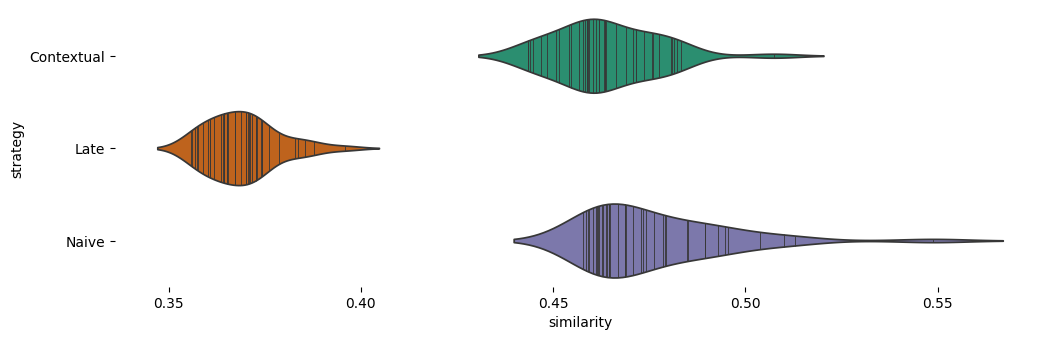

In [83]:
# @title strategy vs similarity

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(display_df['strategy'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(display_df, x='similarity', y='strategy', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


Generating Violin Plot of Similarity Scores...


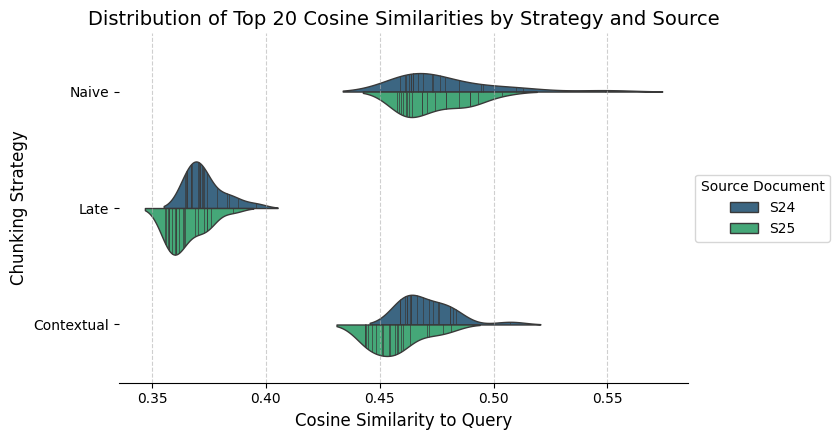

Violin plot displayed.


In [84]:
# Cell 20: Violin Plot - Similarity Distribution by Strategy

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # To ensure plot displays in relevant environments

print("\nGenerating Violin Plot of Similarity Scores...")

if top_results_df.empty:
    print("Cannot generate plot: top_results_df is empty.")
else:
    # Calculate figsize dynamically based on number of strategies
    num_strategies = len(top_results_df['strategy'].unique())
    figsize_height = 1.5 * num_strategies # Adjust multiplier as needed for aesthetics
    figsize_width = 10 # Fixed width, or adjust as needed

    plt.figure(figsize=(figsize_width, figsize_height))

    # Create the violin plot
    # 'y' is the categorical variable (strategy)
    # 'x' is the numerical variable (similarity)
    # 'data' is the dataframe containing the top N results
    # 'inner'='stick' shows individual data points inside the violin
    # 'palette' sets the color scheme
    # 'hue' can be used to further split by 'source' if desired (might get busy)
    sns.violinplot(data=top_results_df, x='similarity', y='strategy', hue='source', # Added hue='source'
                   inner='stick', palette='viridis', # Changed palette, 'viridis' often looks good
                   split=True, # Split violins for comparing sources within a strategy
                   linewidth=1 # Thinner lines for sticks
                   )

    # Add titles and labels
    plt.title(f'Distribution of Top {N_TOP_RESULTS} Cosine Similarities by Strategy and Source', fontsize=14)
    plt.xlabel('Cosine Similarity to Query', fontsize=12)
    plt.ylabel('Chunking Strategy', fontsize=12)

    # Improve aesthetics
    sns.despine(top=True, right=True, bottom=False, left=True) # Keep bottom axis line
    plt.grid(axis='x', linestyle='--', alpha=0.6) # Add faint grid lines on x-axis
    plt.legend(title='Source Document', loc='center left', bbox_to_anchor=(1, 0.5)) # Move legend outside

    # Adjust layout to prevent clipping
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust right boundary for legend space

    # Show the plot
    plt.show()
    print("Violin plot displayed.")

#Chunking Strategies Compared Version 3



*   Naive Chunking
*   Late Chunking
*   Contextual Chunking


**With Nomic AI Embed model for Late Chunking and real support docs for comparison**

In [ ]:

# Cell 1: Install necessary libraries (Add umap-learn if using UMAP)
!pip install sentence-transformers transformers torch plotly scikit-learn numpy pandas pymupdf4llm umap-learn -q

In [22]:
# Cell 2: Import libraries (UPDATED with CUDA_LAUNCH_BLOCKING)

import os
# Set environment variable for synchronous CUDA calls - HELPS DEBUGGING GPU ERRORS
# MUST BE SET BEFORE TORCH IMPORT AND REQUIRES KERNEL RESTART
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print(f"Set CUDA_LAUNCH_BLOCKING=1: {os.environ.get('CUDA_LAUNCH_BLOCKING')}")
print("!!! IMPORTANT: You MUST restart the Jupyter Kernel now for CUDA_LAUNCH_BLOCKING to take effect !!!")

# Proceed with imports after restarting kernel
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import torch
import pymupdf4llm # Added
# import os # Already imported

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Re-checking device after potential restart
print(f"Using device: {DEVICE}")
if DEVICE == "cuda":
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

Set CUDA_LAUNCH_BLOCKING=1: 1
!!! IMPORTANT: You MUST restart the Jupyter Kernel now for CUDA_LAUNCH_BLOCKING to take effect !!!
Using device: cpu


In [23]:
# Cell 3: Initialize models (No functional change, added print)
# Initialize the embedding model
model_name = 'nomic-ai/nomic-embed-text-v1.5'
print(f"Initializing embedding model: {model_name}")
# Nomic requires trusting remote code
embedding_model = SentenceTransformer(model_name, device=DEVICE, trust_remote_code=True)

# Initialize summarizer pipeline
summarizer_device = 0 if DEVICE == "cuda" else -1
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=summarizer_device)

print("Models Initialized.")
print(f"Using Embedding Model: {model_name} (Supports 8192 sequence length)")

Initializing embedding model: nomic-ai/nomic-embed-text-v1.5


Device set to use cpu


Models Initialized.
Using Embedding Model: nomic-ai/nomic-embed-text-v1.5 (Supports 8192 sequence length)


In [24]:
# Cell 3.1: Basic Encoding Test (UPDATED to handle list output)

print("Testing basic encoding with the loaded model...")
test_sentences = ["This is a test sentence.", "Dies ist ein Testsatz."]
try:
    # Standard pooled embedding
    print("  Testing pooled embeddings...")
    embeddings_pooled = embedding_model.encode(test_sentences, convert_to_numpy=True)
    print(f"  Successfully generated POOLED embeddings. Type: {type(embeddings_pooled)}, Shape: {embeddings_pooled.shape}")

    # Token embeddings
    print("  Testing token embeddings...")
    with torch.no_grad():
      # Request tensor output, but be prepared for a list of tensors
      embeddings_token_output = embedding_model.encode(test_sentences, output_value='token_embeddings', convert_to_tensor=True)

    # --- Check the output type ---
    if isinstance(embeddings_token_output, list):
        print(f"  Successfully generated TOKEN embeddings.")
        print(f"  Output type: list (Length: {len(embeddings_token_output)})")
        if embeddings_token_output: # Check if list is not empty
             first_item = embeddings_token_output[0]
             print(f"  Type of first item: {type(first_item)}")
             if hasattr(first_item, 'shape'):
                 print(f"  Shape of first item (token embeddings for first sentence): {first_item.shape}")
             else:
                 print("  First item does not have a shape attribute.")
        else:
            print("  Token embedding list is empty.")

    elif hasattr(embeddings_token_output, 'shape'): # Check if it's a tensor/array with shape
         print(f"  Successfully generated TOKEN embeddings.")
         print(f"  Output type: {type(embeddings_token_output)}, Shape: {embeddings_token_output.shape}")

    else:
        print(f"  Generated TOKEN embeddings, but output type is unexpected: {type(embeddings_token_output)}")


    print("\nBasic encoding test passed.")
except Exception as e:
    print(f"ERROR during basic encoding test: {e}")
    # If this fails, the problem is fundamental to model loading or basic use on your GPU.
    raise e

Testing basic encoding with the loaded model...
  Testing pooled embeddings...
  Successfully generated POOLED embeddings. Type: <class 'numpy.ndarray'>, Shape: (2, 768)
  Testing token embeddings...
  Successfully generated TOKEN embeddings.
  Output type: list (Length: 2)
  Type of first item: <class 'torch.Tensor'>
  Shape of first item (token embeddings for first sentence): torch.Size([8, 768])

Basic encoding test passed.


In [25]:
# Cell 4: Define Naive Chunking function (UPDATED with debugging print)
def naive_chunking(document, chunk_size=512, source_label=""):
    """
    Split the document into chunks first, then embed each chunk individually.
    Includes a source label and debug print.
    """
    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
    results = []
    print(f"  Naive Chunking ({source_label}): Processing {len(chunks)} potential chunks...")
    count = 0
    for i, chunk in enumerate(chunks): # Add index for debugging
        if chunk.strip():
            # --- DEBUG PRINT ---
            print(f"  Naive Chunking ({source_label}) - Encoding chunk {i+1}/{len(chunks)} (len={len(chunk)}): '{chunk[:50]}...'")
            # --- END DEBUG PRINT ---
            try:
                embedding = embedding_model.encode(chunk, convert_to_numpy=True)
                results.append({
                    'text': chunk,
                    'embedding': embedding,
                    'strategy': 'Naive',
                    'source': source_label
                })
                count += 1
            except Exception as e:
                print(f"  ERROR encoding chunk {i+1} ('{chunk[:50]}...'): {e}")
                # Optionally continue to the next chunk or re-raise
                # continue
                raise e # Re-raise by default to see the error immediately

    print(f"  Naive Chunking ({source_label}): Generated {count} embeddings.")
    return results

In [26]:
# Cell 5: Define Late Chunking function (UPDATED with source_label)
def late_chunking(document, chunk_size=512, target_max_length=8192, source_label=""): # Add source_label
    """
    Implements Late Chunking by embedding the full document to get token embeddings,
    then pooling token embeddings corresponding to each chunk. Includes a source label.
    """
    print(f"  Late Chunking ({source_label}): Attempting token pooling with target_max_length={target_max_length}...")
    # 1. Tokenization and Embedding (keep internal logic same as before)
    if not hasattr(embedding_model, 'tokenizer') or not hasattr(embedding_model, 'encode'):
         print(f"  Late Chunking Error ({source_label}): Embedding model missing 'tokenizer' or 'encode'.")
         raise AttributeError("Embedding model must have a 'tokenizer' attribute and 'encode' method.")
    effective_max_length = target_max_length
    try:
        print(f"  Late Chunking ({source_label}): Tokenizing document...")
        tokenized_full = embedding_model.tokenizer(
            document, return_offsets_mapping=True, return_tensors='pt',
            truncation=True, max_length=effective_max_length
        ).to(embedding_model.device)
        num_tokens = tokenized_full['input_ids'].shape[1]
        print(f"  Late Chunking ({source_label}): Document tokenized into {num_tokens} tokens.")
        print(f"  Late Chunking ({source_label}): Encoding document...")
        with torch.no_grad():
             outputs = embedding_model.encode(
                 document, output_value='token_embeddings', convert_to_tensor=True, batch_size=1
                ).to(embedding_model.device)
        print(f"  Late Chunking ({source_label}): Raw token embedding output shape: {outputs.shape}")
        if len(outputs.shape) == 3 and outputs.shape[0] == 1: token_embeddings = outputs[0]
        elif len(outputs.shape) == 2:
             if outputs.shape[0] != num_tokens: print(f"  Late Chunking Warning ({source_label}): Token count mismatch.")
             token_embeddings = outputs
        else: raise ValueError(f"Unexpected shape for token embeddings: {outputs.shape}")
        print(f"  Late Chunking ({source_label}): Processed token embedding shape: {token_embeddings.shape}")
        offset_mapping = tokenized_full['offset_mapping'][0,:token_embeddings.shape[0]].cpu().numpy()
    except Exception as e:
        # Fallback logic (keep same as before)
        print(f"  Late Chunking Error ({source_label}): Failed getting token embeddings: {e}. Falling back.")
        fallback_max_len = 512
        truncated_document = document[:fallback_max_len * 4]
        document_embedding = embedding_model.encode(truncated_document, convert_to_numpy=True)
        chunks_text = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
        results = [{'text': chunk, 'embedding': document_embedding, 'strategy': 'Late', 'source': source_label} for chunk in chunks_text if chunk.strip()] # Add source
        print(f"  Late Chunking ({source_label}) (Fallback): Generated {len(results)} embeddings.")
        return results

    # 2. Define chunk boundaries (keep same as before)
    chunks_text_boundaries = []
    for i in range(0, len(document), chunk_size):
        start_char = i
        end_char = i + chunk_size
        chunk_text = document[start_char:end_char]
        if chunk_text.strip():
            chunks_text_boundaries.append({'text': chunk_text, 'start_char': start_char, 'end_char': end_char})
    print(f"  Late Chunking ({source_label}): Defined {len(chunks_text_boundaries)} text chunk boundaries.")

    # 3. Map boundaries and pool (modify to add source_label)
    results = []
    token_embeddings_np = token_embeddings.cpu().numpy()
    for chunk_info in chunks_text_boundaries:
        start_char = chunk_info['start_char']
        end_char = chunk_info['end_char']
        token_indices = []
        for idx, (token_start, token_end) in enumerate(offset_mapping):
            if token_start == 0 and token_end == 0: continue
            if token_start < end_char and token_end > start_char:
                 if idx < token_embeddings_np.shape[0]: token_indices.append(idx)
        if token_indices:
            chunk_token_embeddings = token_embeddings_np[token_indices]
            chunk_embedding = np.mean(chunk_token_embeddings, axis=0)
            results.append({
                'text': chunk_info['text'],
                'embedding': chunk_embedding,
                'strategy': 'Late',
                'source': source_label # Added source
            })

    # Fallback if pooling failed (modify to add source_label)
    if not results and chunks_text_boundaries:
         print(f"  Late Chunking Warning ({source_label}): Pooling failed. Falling back.")
         fallback_max_len = 512
         truncated_document = document[:fallback_max_len * 4]
         document_embedding = embedding_model.encode(truncated_document, convert_to_numpy=True)
         chunks_text = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
         results = [{'text': chunk, 'embedding': document_embedding, 'strategy': 'Late', 'source': source_label} for chunk in chunks_text if chunk.strip()] # Add source
         print(f"  Late Chunking ({source_label}) (Fallback): Generated {len(results)} embeddings.")
    else:
        print(f"  Late Chunking ({source_label}) (Token Pooling): Generated {len(results)} embeddings.")
    return results

In [27]:
# Cell 6: Define Contextual Chunking function (UPDATED with source_label)
def contextual_chunking(document, chunk_size=512, source_label=""):
    """
    Generate context-aware chunks by summarizing the document and appending
    the summary to each chunk *before* embedding. Includes a source label.
    """
    print(f"  Contextual Chunking ({source_label}): Generating summary...")
    max_summary_input_length = 1024 * 4
    truncated_for_summary = document[:max_summary_input_length]
    if len(document) > len(truncated_for_summary):
        print(f"  Contextual Chunking Warning ({source_label}): Doc truncated for summary.")
    try:
        summary = summarizer(truncated_for_summary, max_length=130, min_length=20, do_sample=False)[0]['summary_text']
        print(f"  Contextual Chunking ({source_label}): Summary generated.")
    except Exception as e:
        print(f"  Contextual Chunking Error ({source_label}) during summarization: {e}. Using empty summary.")
        summary = ""

    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
    print(f"  Contextual Chunking ({source_label}): Processing {len(chunks)} potential chunks...")
    results = []
    count = 0
    for chunk in chunks:
       if chunk.strip():
            enriched_chunk_for_embedding = chunk + f" [CONTEXT_SUMMARY_{source_label}] " + summary
            embedding = embedding_model.encode(enriched_chunk_for_embedding, convert_to_numpy=True)
            results.append({
                'text': chunk,
                'embedding': embedding,
                'strategy': 'Contextual',
                'source': source_label # Added source
            })
            count += 1
    print(f"  Contextual Chunking ({source_label}): Generated {count} embeddings.")
    return results

In [28]:
import requests

url = "https://downloadcenter.samsung.com/content/UM/202501/20250124163913655/SM-S93X_UG_EU_15_Eng_Rev.1.0_250123.pdf"
response = requests.get(url)

with open("s25_support_doc_input.pdf", "wb") as f:
    f.write(response.content)
print("PDF downloaded successfully as s25_support_doc.pdf")


url = "https://downloadcenter.samsung.com/content/UM/202409/20240913104143006/SM-S92X_UG_EU_UU_Eng_Rev.1.3_240912.pdf"
response = requests.get(url)

with open("s24_support_doc_input.pdf", "wb") as f:
    f.write(response.content)
print("PDF downloaded successfully as s24_support_doc.pdf")

PDF downloaded successfully as s25_support_doc.pdf
PDF downloaded successfully as s24_support_doc.pdf


In [29]:
# Cell 7: Load Documents from PDFs using pymupdf4llm (UPDATED with basic cleaning)

# ---!!! USER ACTION REQUIRED: SET PDF FILE PATHS !!!---
pdf_path_s24 = "s24_support_doc_input.pdf"  # <--- CHANGE THIS AS NEEDED
pdf_path_s25 = "s25_support_doc_input.pdf"  # <--- CHANGE THIS AS NEEDED
# ---!!! END USER ACTION REQUIRED !!!---

def clean_text(text):
    """Basic cleaning: remove null chars, replace multiple spaces/newlines."""
    if not text: return ""
    text = text.replace('\x00', '') # Remove null characters
    text = ' '.join(text.split()) # Replace multiple whitespace chars with single space
    return text

def load_with_pymupdf(pdf_path, doc_label=""):
     print(f"Extracting text from {doc_label} PDF: {pdf_path}")
     if not os.path.exists(pdf_path):
        print(f"  Error: File not found at {pdf_path}")
        raise FileNotFoundError(f"Please ensure '{os.path.basename(pdf_path)}' is uploaded.")
     try:
        md_text = pymupdf4llm.to_markdown(pdf_path)
        cleaned_text = clean_text(md_text) # Apply cleaning
        print(f"  Successfully extracted & cleaned text from {doc_label} PDF (length: {len(cleaned_text)}).")
        return cleaned_text
     except Exception as e:
         print(f"  Error loading {doc_label} PDF with pymupdf4llm: {e}")
         return ""

# Load the documents separately
s24_text = load_with_pymupdf(pdf_path_s24, "S24")
s25_text = load_with_pymupdf(pdf_path_s25, "S25")

# --- Verification ---
if not s24_text: print("Warning: No text extracted/loaded from S24 PDF.")
if not s25_text: print("Warning: No text extracted/loaded from S25 PDF.")
if not s24_text or not s25_text: raise ValueError("Failed to load text. Stopping.")

print("\nTexts for S24 and S25 loaded separately.")
print(f"S24 Text Length: {len(s24_text)}")
print(f"S25 Text Length: {len(s25_text)}")

Extracting text from S24 PDF: s24_support_doc_input.pdf
  Successfully extracted & cleaned text from S24 PDF (length: 244053).
Extracting text from S25 PDF: s25_support_doc_input.pdf
  Successfully extracted & cleaned text from S25 PDF (length: 227975).

Texts for S24 and S25 loaded separately.
S24 Text Length: 244053
S25 Text Length: 227975


In [30]:
# Cell 8: Define Sample Query and Chunk Size
sample_query = "How to fix overheating on Galaxy S25?"
chunk_size = 512 # Adjust as needed, smaller makes visualization denser

print(f"Sample query: '{sample_query}'")
print(f"Chunk size: {chunk_size} characters")

Sample query: 'How to fix overheating on Galaxy S25?'
Chunk size: 512 characters


In [31]:
# Cell 9: Run all chunking methods for EACH document (UPDATED)
all_results = []
docs_to_process = {
    "S24": s24_text,
    "S25": s25_text
}

for doc_label, doc_text in docs_to_process.items():
    print(f"\n--- Processing Document: {doc_label} ---")
    if not doc_text:
        print(f"Skipping {doc_label} due to empty text.")
        continue

    print(f"Running Naive Chunking for {doc_label}...")
    results_naive = naive_chunking(doc_text, chunk_size, source_label=doc_label)
    all_results.extend(results_naive)
    print(f"Completed Naive Chunking for {doc_label}.\n")

    print(f"Running Late Chunking for {doc_label}...")
    results_late = late_chunking(doc_text, chunk_size, source_label=doc_label) # Nomic used here
    all_results.extend(results_late)
    print(f"Completed Late Chunking for {doc_label}.\n")

    print(f"Running Contextual Chunking for {doc_label}...")
    results_contextual = contextual_chunking(doc_text, chunk_size, source_label=doc_label)
    all_results.extend(results_contextual)
    print(f"Completed Contextual Chunking for {doc_label}.\n")

# Create a DataFrame (optional)
df_results = pd.DataFrame(all_results)
print(f"\n--- Processing Complete ---")
print(f"Total results collected across all documents: {len(df_results)}")
if not df_results.empty:
    print("Chunk Counts per Strategy and Source:")
    print(df_results.groupby(['source', 'strategy']).size())


--- Processing Document: S24 ---
Running Naive Chunking for S24...
  Naive Chunking (S24): Processing 477 potential chunks...
  Naive Chunking (S24) - Encoding chunk 1/477 (len=512): '# USER GUIDE ###### SM-S921B/DS SM-S921B/DS UD SM-...'
  Naive Chunking (S24) - Encoding chunk 2/477 (len=512): ' 37 Entering text 39 Extracting text #### Apps and...'
  Naive Chunking (S24) - Encoding chunk 3/477 (len=512): 'alaxy S24 Ultra) 113 Calendar 114 Reminder (Receiv...'
  Naive Chunking (S24) - Encoding chunk 4/477 (len=512): 'uction 132 Samsung account 132 Connections 134 Wi-...'
  Naive Chunking (S24) - Encoding chunk 5/477 (len=512): 'hemes 150 Home screen 150 Lock screen and AOD 151 ...'
  Naive Chunking (S24) - Encoding chunk 6/477 (len=512): 'rols 171 Device care 172 Apps 173 General manageme...'
  Naive Chunking (S24) - Encoding chunk 7/477 (len=512): 'S24 Ultra: Speaker Front camera Proximity/Light se...'
  Naive Chunking (S24) - Encoding chunk 8/477 (len=512): 'tton Fingerprint recogni

In [32]:
# Cell 10: Prepare data for Visualization (UPDATED for Source & Two Doc Refs)
print("Preparing data for visualization...")

# Filter out any results where embedding generation might have failed
valid_results = [res for res in all_results if 'embedding' in res and isinstance(res['embedding'], np.ndarray)]
print(f"Filtered results with valid embeddings: {len(valid_results)}")

if not valid_results:
    raise ValueError("No valid embeddings found. Check chunking functions.")

# Extract data including the source
chunk_texts = [res['text'] for res in valid_results]
embeddings_list = [res['embedding'] for res in valid_results]
strategies = [res['strategy'] for res in valid_results]
sources = [res['source'] for res in valid_results] # Added source extraction

embeddings = np.array(embeddings_list) # Stack valid chunk embeddings

# Embed the query
print("Embedding query...")
query_embedding = embedding_model.encode(sample_query, convert_to_numpy=True)

# Embed EACH source document for separate reference points
print("Generating Document Reference embedding for S24...")
s24_doc_ref_embedding = embedding_model.encode(sentences=s24_text, convert_to_numpy=True)
print("Generating Document Reference embedding for S25...")
s25_doc_ref_embedding = embedding_model.encode(sentences=s25_text, convert_to_numpy=True)
print("Generated Document Reference embeddings.")


# Stack all embeddings for PCA: Chunks + Query + S24 Ref + S25 Ref
print("Stacking embeddings for PCA...")
all_embeddings_for_pca = np.vstack([
    embeddings,
    query_embedding.reshape(1, -1),
    s24_doc_ref_embedding.reshape(1, -1), # Add S24 Ref
    s25_doc_ref_embedding.reshape(1, -1)  # Add S25 Ref
])
print(f"Shape of data for PCA: {all_embeddings_for_pca.shape}")

# Create corresponding labels and hover texts
# Add source info to chunk hover texts
chunk_hover_texts = [f"[{res['source']}] {res['text'][:100]}..." if len(res['text']) > 100 else f"[{res['source']}] {res['text']}"
                     for res in valid_results]
# Labels for PCA data
all_labels = strategies # Start with chunk strategies
all_sources = sources    # Keep sources separate for now (needed for plotting)
# Append labels for the non-chunk points added to PCA
special_labels = ['Query', 'S24 Doc Ref', 'S25 Doc Ref']
special_sources = ['Special', 'S24', 'S25'] # Assign sources to special points too
special_hover_texts = [sample_query, 'S24 Full Document (Pooled)', 'S25 Full Document (Pooled)']

print(f"Number of chunk labels: {len(all_labels)}")
print(f"Number of special labels: {len(special_labels)}")

# Verify lengths before combining for PCA checks
if embeddings.shape[0] != len(all_labels):
     print(f"ERROR: Mismatch between chunk embeddings ({embeddings.shape[0]}) and chunk labels ({len(all_labels)})")

# Combine labels and hover texts for PCA verification
combined_labels = all_labels + special_labels
combined_hover_texts = chunk_hover_texts + special_hover_texts

# Final verification
if all_embeddings_for_pca.shape[0] != len(combined_labels):
    print(f"ERROR: Mismatch PCA input rows ({all_embeddings_for_pca.shape[0]}) vs combined labels ({len(combined_labels)})")
if all_embeddings_for_pca.shape[0] != len(combined_hover_texts):
     print(f"ERROR: Mismatch PCA input rows ({all_embeddings_for_pca.shape[0]}) vs combined hover texts ({len(combined_hover_texts)})")


print("Data preparation complete.")

Preparing data for visualization...
Filtered results with valid embeddings: 1990
Embedding query...
Generating Document Reference embedding for S24...
Generating Document Reference embedding for S25...
Generated Document Reference embeddings.
Stacking embeddings for PCA...
Shape of data for PCA: (1993, 768)
Number of chunk labels: 1990
Number of special labels: 3
Data preparation complete.


In [33]:
# Cell 11: Perform PCA
print("Performing PCA...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings_for_pca)
print(f"PCA executed. Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Shape of 2D embeddings: {embeddings_2d.shape}")

Performing PCA...
PCA executed. Explained variance ratio: [0.0925753  0.06944339]
Shape of 2D embeddings: (1993, 2)


In [34]:
# Cell 12: Create Visualization with Plotly (UPDATED for Source Colors & Strategy Shapes)
print("Creating Plotly visualization...")
fig = go.Figure()

# Define COLOR map based on SOURCE document
color_map = {
    'S24': 'blue',     # S24 will use blue
    'S25': 'red',      # S25 will use red
    'Special': 'black' # For Query
}

# Define MARKER SYMBOL map based on STRATEGY
strategy_marker_map = {
    'Naive': 'circle',
    'Late': 'square',
    'Contextual': 'triangle-up'
}

# Define marker properties for special points
special_marker_map = {
    'Query': 'star',
    'S24 Doc Ref': 'diamond',
    'S25 Doc Ref': 'diamond' # Same shape for doc refs, color distinguishes
}
special_marker_size = {
     'Query': 16,
     'S24 Doc Ref': 12,
     'S25 Doc Ref': 12
}

unique_sources = ['S24', 'S25']
unique_strategies = ['Naive', 'Late', 'Contextual']

# 1. Plot Chunks (iterating through source and strategy)
for source in unique_sources:
    for strategy in unique_strategies:
        # Find indices matching BOTH source and strategy
        # Use the original separate lists 'sources' and 'strategies' here
        indices = [i for i, (s, strat) in enumerate(zip(sources, strategies))
                   if s == source and strat == strategy]

        if not indices:
            # print(f"  No points found for: {source} {strategy}") # Optional debug
            continue

        plot_name = f"{source} {strategy}"
        print(f"  Plotting {len(indices)} points for: {plot_name}")
        fig.add_trace(go.Scatter(
            x=embeddings_2d[indices, 0],
            y=embeddings_2d[indices, 1],
            mode='markers',
            name=plot_name, # Legend entry combines source and strategy
            marker=dict(
                color=color_map[source],            # Color by source
                symbol=strategy_marker_map[strategy], # Shape by strategy
                size=8,
                opacity=0.7,
                line=dict(width=1, color='DarkSlateGrey') # Add outline for clarity
            ),
            text=[combined_hover_texts[i] for i in indices], # Use combined list for hover text index
            hoverinfo='text+name'
        ))

# 2. Plot Special Points (Query, Doc Refs)
num_chunk_embeddings = embeddings.shape[0] # Number of actual chunk embeddings before special points
for i, label in enumerate(special_labels):
    point_index = num_chunk_embeddings + i # Calculate index in the PCA data
    point_source = special_sources[i] # Get source ('Special', 'S24', 'S25') for color

    print(f"  Plotting Special Point: {label} at index {point_index}")
    fig.add_trace(go.Scatter(
        x=[embeddings_2d[point_index, 0]],
        y=[embeddings_2d[point_index, 1]],
        mode='markers+text',
        name=label,
        text=[f'<b>{label.replace(" Doc Ref", "")}</b>'], # Short label on plot
        textposition="top center",
        marker=dict(
            color=color_map[point_source],       # Use source for color (black for Query)
            symbol=special_marker_map[label],    # Unique shape
            size=special_marker_size[label],
            opacity=0.95
        ),
        hoverinfo='text+name',
        hovertext=[combined_hover_texts[point_index]] # Get hover text by index
    ))


print("Plot object created.")

Creating Plotly visualization...
  Plotting 477 points for: S24 Naive
  Plotting 72 points for: S24 Late
  Plotting 477 points for: S24 Contextual
  Plotting 446 points for: S25 Naive
  Plotting 72 points for: S25 Late
  Plotting 446 points for: S25 Contextual
  Plotting Special Point: Query at index 1990
  Plotting Special Point: S24 Doc Ref at index 1991
  Plotting Special Point: S25 Doc Ref at index 1992
Plot object created.


In [35]:
# Cell 13: Update layout and show plot
print("Updating plot layout and displaying...")
fig.update_layout(
    title=f"PCA Visualization: S24 (Blue) vs S25 (Red) Embeddings by Strategy", # Updated title
    xaxis_title=f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})",
    yaxis_title=f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})",
    width=1100, # Slightly wider for potentially more legend items
    height=800,
    legend=dict(
        orientation="v", # Vertical legend might be better
        yanchor="top", y=1.0,
        xanchor="left", x=1.01 # Place legend outside plot area
        ),
    margin=dict(l=50, r=180, t=100, b=50), # Adjust right margin for legend
    hovermode='closest'
)
fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


**Cell 14: Interpretation (Updated for Two Documents)**

**Interpreting the Visualization (S24 vs S25):**

**Color indicates the source document (Blue=S24, Red=S25).**
**Marker shape indicates the chunking strategy (Circle=Naive, Square=Late, Triangle=Contextual).**

1.  **Document Separation:** Observe the overall placement of blue points (S24) versus red points (S25). Do the two documents form distinct clusters in the embedding space, suggesting they discuss different topics or use different language? Or do they overlap significantly?
2.  **Strategy Comparison *Within* a Document:**
    *   For S24 (Blue): How does the scatter of Naive circles compare to the Late squares and Contextual triangles? Are Late/Contextual more clustered? Where are they relative to the blue S24 Doc Ref diamond?
    *   For S25 (Red): Perform the same comparison using the red points and the red S25 Doc Ref diamond.
3.  **Strategy Comparison *Between* Documents:**
    *   Does Naive chunking (circles) show similar levels of scatter for both S24 (blue) and S25 (red)?
    *   Does Late chunking (squares) create similarly tight clusters for both documents? Are these clusters located similarly relative to their respective document references (diamonds)?
    *   How does Contextual chunking (triangles) behave for S24 vs S25? Does the LLM summary have a similar effect on both?
4.  **Proximity to Query (Black Star):**
    *   Which document's chunks (blue or red) are generally closer to the query?
    *   Within the closer document, which chunking strategy (shape) yields points nearest the query? This suggests the best combination for this specific query.
5.  **Document Reference Points (Diamonds):** The blue diamond represents the overall S24 document, and the red diamond represents S25. Their proximity indicates the semantic similarity *between the two full documents* according to the embedding model. The location of chunk clusters relative to *their own* document reference is key.

**Key Considerations:**
*   **Content Difference:** The primary driver of separation between blue and red clusters will be the actual content difference between the S24 and S25 support documents.
*   **Model Behavior:** The Nomic model determines the overall structure of the embedding space.
*   **Late Chunking (Token Pooling):** Should show distinct clusters for S24 (blue squares) and S25 (red squares), reflecting context awareness within each document.

In [36]:
# Cell 12: Create Visualization with Plotly (UPDATED with Subplots/Faceting)
from plotly.subplots import make_subplots

print("Creating Plotly visualization with Subplots...")

# Create subplots: 1 row, 3 columns for Naive, Late, Contextual
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Naive Chunking', 'Late Chunking (Token Pool)', 'Contextual Chunking'),
    shared_xaxes=True, # Share axes if desired, or set to False
    shared_yaxes=True
)

# Define COLOR map based on SOURCE document (same as before)
color_map = {
    'S24': 'blue',
    'S25': 'red',
    'Special': 'black' # For Query
}

# Define MARKER SYMBOL map based on STRATEGY (only used for lookup, not direct plotting now)
strategy_marker_map = {
    'Naive': 'circle',
    'Late': 'square',
    'Contextual': 'triangle-up'
}
strategy_list = ['Naive', 'Late', 'Contextual'] # For iterating cols

# Define marker properties for special points (same as before)
special_marker_map = { 'Query': 'star', 'S24 Doc Ref': 'diamond', 'S25 Doc Ref': 'diamond'}
special_marker_size = { 'Query': 16, 'S24 Doc Ref': 12, 'S25 Doc Ref': 12}
special_labels = ['Query', 'S24 Doc Ref', 'S25 Doc Ref']
special_sources = ['Special', 'S24', 'S25']

unique_sources = ['S24', 'S25']

# --- Plot Chunks in Subplots ---
show_legend_flags = {'S24': True, 'S25': True} # Control legend entry creation

for col_idx, strategy in enumerate(strategy_list):
    print(f"  Processing subplot for: {strategy}")
    subplot_col = col_idx + 1 # Subplot columns are 1-indexed

    for source in unique_sources:
        # Find indices matching BOTH source and strategy
        indices = [i for i, (s, strat) in enumerate(zip(sources, strategies))
                   if s == source and strat == strategy]

        if not indices: continue

        plot_name = f"{source} {strategy}" # Full name for hover/internal use
        legend_group = f"{source}" # Group legend items by source
        marker_symbol = strategy_marker_map[strategy] # Get shape for this strategy

        print(f"    Plotting {len(indices)} points for: {plot_name} in col {subplot_col}")
        fig.add_trace(go.Scatter(
            x=embeddings_2d[indices, 0],
            y=embeddings_2d[indices, 1],
            mode='markers',
            name=source, # Legend shows only the source ('S24' or 'S25')
            legendgroup=legend_group, # Group legend items by source
            showlegend=show_legend_flags[source], # Only show legend once per source
            marker=dict(
                color=color_map[source],
                symbol=marker_symbol, # Shape determined by subplot (strategy)
                size=6, # Smaller size
                opacity=0.6, # Slightly more transparent
                line=dict(width=1, color='DarkSlateGrey')
            ),
            text=[combined_hover_texts[i] for i in indices],
            hoverinfo='text+name'
        ), row=1, col=subplot_col)
        # After plotting once for a source, don't add it to legend again
        show_legend_flags[source] = False


# --- Plot Special Points (Query, Doc Refs) in EACH Subplot ---
num_chunk_embeddings = embeddings.shape[0]
show_special_legend = True # Show legend for first occurrence only

for col_idx, strategy in enumerate(strategy_list): # Add to all 3 subplots
    subplot_col = col_idx + 1
    print(f"  Adding Query/DocRefs to subplot for: {strategy}")

    for i, label in enumerate(special_labels):
        point_index = num_chunk_embeddings + i
        point_source = special_sources[i]

        # Check if index is valid before plotting
        if point_index >= embeddings_2d.shape[0]:
             print(f"Warning: Index {point_index} out of bounds for special point '{label}'. Skipping.")
             continue

        fig.add_trace(go.Scatter(
            x=[embeddings_2d[point_index, 0]],
            y=[embeddings_2d[point_index, 1]],
            mode='markers+text',
            name=label, # Unique name for legend
            legendgroup='SpecialPoints', # Group special points in legend
            showlegend=show_special_legend, # Show legend only for the first subplot's set
            text=[f'<b>{label.replace(" Doc Ref", "")}</b>'],
            textposition="top center",
            marker=dict(
                color=color_map[point_source],
                symbol=special_marker_map[label],
                size=special_marker_size[label],
                opacity=0.95
            ),
            hoverinfo='text+name',
            hovertext=[combined_hover_texts[point_index]]
        ), row=1, col=subplot_col)
    show_special_legend = False # Turn off legend after adding first set


print("Plot object created with subplots.")

Creating Plotly visualization with Subplots...
  Processing subplot for: Naive
    Plotting 477 points for: S24 Naive in col 1
    Plotting 446 points for: S25 Naive in col 1
  Processing subplot for: Late
    Plotting 72 points for: S24 Late in col 2
    Plotting 72 points for: S25 Late in col 2
  Processing subplot for: Contextual
    Plotting 477 points for: S24 Contextual in col 3
    Plotting 446 points for: S25 Contextual in col 3
  Adding Query/DocRefs to subplot for: Naive
  Adding Query/DocRefs to subplot for: Late
  Adding Query/DocRefs to subplot for: Contextual
Plot object created with subplots.


In [37]:
# Cell 13: Update layout and show plot (UPDATED for Subplots)
print("Updating plot layout and displaying...")
fig.update_layout(
    title_text="PCA Visualization by Strategy: S24 (Blue) vs S25 (Red)", # Main title
    width=1500, # Wider to accommodate 3 plots
    height=600, # Adjust height as needed
    legend=dict( # Keep single legend
        orientation="v",
        yanchor="top", y=1.0,
        xanchor="left", x=1.01
        ),
    margin=dict(l=50, r=180, t=100, b=50),
    hovermode='closest'
)

# Update axes labels for all subplots
fig.update_xaxes(title_text=f"PC 1 ({pca.explained_variance_ratio_[0]:.2%})")
fig.update_yaxes(title_text=f"PC 2 ({pca.explained_variance_ratio_[1]:.2%})")


fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


##use Umap/Tsne for better clustering

In [39]:
# Cell 11: Perform Dimensionality Reduction (UPDATED to use UMAP)
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
import umap # Use UMAP

print("Performing UMAP dimensionality reduction...")
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,  # Lower values focus more on local structure (try 5-10)
    min_dist=0.1,    # Lower values allow tighter clustering (try 0.0-0.2)
    metric='cosine', # Cosine distance is often good for embeddings
    random_state=42  # For reproducibility
)

embeddings_2d = reducer.fit_transform(all_embeddings_for_pca) # Use the same stacked data
print(f"UMAP executed.")
print(f"Shape of 2D embeddings: {embeddings_2d.shape}")

# Note: Explained variance is not directly applicable to UMAP/t-SNE

Performing UMAP dimensionality reduction...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP executed.
Shape of 2D embeddings: (1993, 2)


In [40]:
# @title PCA Plot
# Cell 13: Update layout and show plot (UPDATED for Subplots)
print("Updating plot layout and displaying...")

# Use the fig object created in the modified Cell 12 (with subplots)
fig.update_layout(
    title_text="PCA Visualization by Strategy: S24 (Blue) vs S25 (Red)", # Main title for the entire figure
    width=1500, # Adjusted width to accommodate 3 subplots side-by-side
    height=600, # Adjusted height for better subplot aspect ratio
    legend=dict(
        title="Legend", # Optional legend title
        orientation="v", # Vertical legend orientation
        yanchor="top", y=1.0, # Anchor legend to the top of the plot area
        xanchor="left", x=1.01, # Position legend slightly outside the right edge
        traceorder="normal", # Order legend items as they appear
        itemsizing='constant' # Ensure consistent marker size in legend
    ),
    margin=dict(l=60, r=200, t=100, b=80), # Adjust margins (especially right for legend)
    hovermode='closest', # Show hover info for the nearest point
    # Ensure consistent axis ranges if shared_xaxes/shared_yaxes were True in make_subplots
    # If axes were not shared, you might need to set ranges manually per subplot if desired
    # Example (if needed):
    # xaxis_range=[-8, 9],
    # yaxis_range=[-12, 8]
)

# Update axes labels for all subplots using update_xaxes/update_yaxes
# This applies the label to the respective axes of *all* subplots
fig.update_xaxes(title_text=f"PC 1 ({pca.explained_variance_ratio_[0]:.2%})") # Use percentage format
fig.update_yaxes(title_text=f"PC 2 ({pca.explained_variance_ratio_[1]:.2%})") # Use percentage format

# Ensure subplot titles (set in make_subplots) are visible
fig.update_layout(showlegend=True) # Make sure legend is explicitly shown

fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


In [41]:
# @title UMAP Plot
# Cell 13: Update layout and show plot (Updated for UMAP and Subplots)
print("Updating plot layout and displaying...")

# Assuming 'fig' is the Plotly Figure object created using make_subplots in Cell 12,
# and Cell 11 has calculated UMAP embeddings stored in 'embeddings_2d'.

# Update main title for UMAP
fig.update_layout(
    title_text="UMAP Visualization by Strategy: S24 (Blue) vs S25 (Red)", # UMAP specific title
    width=1500, # Same width for 3 plots
    height=600, # Same height
    legend=dict(
        title="Legend",
        orientation="v",
        yanchor="top", y=1.0,
        xanchor="left", x=1.01,
        traceorder="normal",
        itemsizing='constant'
    ),
    margin=dict(l=60, r=200, t=100, b=80),
    hovermode='closest'
)

# Update axes titles for UMAP for all relevant subplots
fig.update_xaxes(title_text="UMAP Dimension 1") # Change axis title
fig.update_yaxes(title_text="UMAP Dimension 2") # Change axis title

# Ensure subplot titles (set in make_subplots in Cell 12) are visible
fig.update_layout(showlegend=True) # Make sure legend is shown

fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


In [42]:
# Cell 11: Perform t-SNE Dimensionality Reduction (UPDATED)
from sklearn.manifold import TSNE # Import t-SNE

print("Performing t-SNE dimensionality reduction...")
# Note: t-SNE can be sensitive to hyperparameters and computationally intensive.
# Adjust perplexity based on dataset size (typically 5-50).
# n_iter can be increased if convergence isn't good.
tsne = TSNE(
    n_components=2,
    perplexity=30, # A common default, adjust based on density/number of points
    learning_rate='auto', # Uses a heuristic learning rate
    n_iter=1000, # Minimum recommended iterations
    init='pca', # PCA initialization is often faster and more stable
    random_state=42, # For reproducibility
    n_jobs=-1 # Use all available CPU cores
)

# Ensure data is float32 for t-SNE (usually already is, but good practice)
embeddings_for_tsne = all_embeddings_for_pca.astype(np.float32)

embeddings_2d = tsne.fit_transform(embeddings_for_tsne) # Use the same stacked data

print(f"t-SNE executed.")
print(f"Shape of 2D embeddings: {embeddings_2d.shape}")

# Note: Explained variance is not applicable to t-SNE.

Performing t-SNE dimensionality reduction...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



t-SNE executed.
Shape of 2D embeddings: (1993, 2)


In [43]:
# @title t-SNE Plot
# Cell 13: Update layout and show plot (Updated for t-SNE and Subplots)
print("Updating plot layout and displaying...")

# Assuming 'fig' is the Plotly Figure object created using make_subplots in Cell 12,
# and Cell 11 has calculated t-SNE embeddings stored in 'embeddings_2d'.

# Update main title for t-SNE
fig.update_layout(
    title_text="t-SNE Visualization by Strategy: S24 (Blue) vs S25 (Red)", # t-SNE specific title
    width=1500, # Same width for 3 plots
    height=600, # Same height
    legend=dict(
        title="Legend",
        orientation="v",
        yanchor="top", y=1.0,
        xanchor="left", x=1.01,
        traceorder="normal",
        itemsizing='constant'
    ),
    margin=dict(l=60, r=200, t=100, b=80),
    hovermode='closest'
)

# Update axes titles for t-SNE for all relevant subplots
fig.update_xaxes(title_text="t-SNE Dimension 1") # Change axis title
fig.update_yaxes(title_text="t-SNE Dimension 2") # Change axis title

# Ensure subplot titles (set in make_subplots in Cell 12) are visible
fig.update_layout(showlegend=True) # Make sure legend is shown

fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


In [44]:
# Cell 15: Calculate Cosine Similarities and Identify Top N Results

from sklearn.metrics.pairwise import cosine_similarity

N_TOP_RESULTS = 20 # How many top results to retrieve per group

# Ensure df_results and query_embedding are available from previous cells
if 'df_results' not in locals() or 'query_embedding' not in locals():
    raise NameError("Ensure 'df_results' and 'query_embedding' are defined from previous cells.")
if df_results.empty:
     raise ValueError("'df_results' is empty. Check previous chunking steps.")

# Reshape query embedding for cosine_similarity function
query_vec = query_embedding.reshape(1, -1)

top_results_list = []
unique_sources = df_results['source'].unique()
unique_strategies = df_results['strategy'].unique()

print(f"Calculating Top {N_TOP_RESULTS} cosine similarities for query: '{sample_query}'")

for source in unique_sources:
    for strategy in unique_strategies:
        print(f"  Processing: Source='{source}', Strategy='{strategy}'")

        # Filter DataFrame for the current group
        group_df = df_results[(df_results['source'] == source) & (df_results['strategy'] == strategy)].copy() # Use copy to avoid SettingWithCopyWarning

        if group_df.empty:
            print(f"    No data found for this group. Skipping.")
            continue

        # Extract embeddings for this group
        group_embeddings = np.stack(group_df['embedding'].values) # Stack embeddings into a 2D array

        # Calculate cosine similarity
        similarities = cosine_similarity(query_vec, group_embeddings)[0] # Get the 1D array of similarities

        # Add similarities to the group DataFrame
        group_df['similarity'] = similarities

        # Get the top N results for this group
        top_n_group = group_df.nlargest(N_TOP_RESULTS, 'similarity')

        print(f"    Found {len(top_n_group)} results for this group.")
        top_results_list.append(top_n_group)

# Concatenate all top results into a single DataFrame
if top_results_list:
    top_results_df = pd.concat(top_results_list, ignore_index=True)
    print(f"\nCombined top results. Total entries: {len(top_results_df)}")
else:
    print("\nNo top results found across all groups.")
    top_results_df = pd.DataFrame() # Create empty df if nothing found

Calculating Top 20 cosine similarities for query: 'How to fix overheating on Galaxy S25?'
  Processing: Source='S24', Strategy='Naive'
    Found 20 results for this group.
  Processing: Source='S24', Strategy='Late'
    Found 20 results for this group.
  Processing: Source='S24', Strategy='Contextual'
    Found 20 results for this group.
  Processing: Source='S25', Strategy='Naive'
    Found 20 results for this group.
  Processing: Source='S25', Strategy='Late'
    Found 20 results for this group.
  Processing: Source='S25', Strategy='Contextual'
    Found 20 results for this group.

Combined top results. Total entries: 120


In [45]:
# Cell 16: Display Top Results DataFrame

print(f"Top {N_TOP_RESULTS} Results per Source/Strategy (Sorted):")

if not top_results_df.empty:
    # Sort for better readability
    display_df = top_results_df.sort_values(by=['source', 'strategy', 'similarity'], ascending=[True, True, False])
    # Select and reorder columns for display
    display_df = display_df[['source', 'strategy', 'similarity', 'text']]
    # Display the DataFrame (use display in Jupyter environments)
    from IPython.display import display
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', 100): # Show more rows/text
        display(display_df)
else:
    print("DataFrame of top results is empty.")

Top 20 Results per Source/Strategy (Sorted):


source    strategy  similarity  \
40     S24  Contextual    0.777792   
41     S24  Contextual    0.774283   
42     S24  Contextual    0.755468   
43     S24  Contextual    0.745222   
44     S24  Contextual    0.732342   
45     S24  Contextual    0.717435   
46     S24  Contextual    0.710735   
47     S24  Contextual    0.698602   
48     S24  Contextual    0.693524   
49     S24  Contextual    0.685794   
50     S24  Contextual    0.675738   
51     S24  Contextual    0.671608   
52     S24  Contextual    0.665295   
53     S24  Contextual    0.664995   
54     S24  Contextual    0.664387   
55     S24  Contextual    0.663183   
56     S24  Contextual    0.658861   
57     S24  Contextual    0.654620   
58     S24  Contextual    0.652885   
59     S24  Contextual    0.652765   
20     S24        Late    0.461497   
21     S24        Late    0.454351   
22     S24        Late    0.449768   
23     S24        Late    0.447982   
24     S24        Late    0.447644   
25     S24        Late    0.446622   
26     S24        Late    0.445945   
27     S24        Late    0.444079   
28     S24        Late    0.442350   
29     S24        Late    0.442077   
30     S24        Late    0.438977   
31     S24        Late    0.437925   
32     S24        Late    0.437152   
33     S24        Late    0.435436   
34     S24        Late    0.433927   
35     S24        Late    0.433333   
36     S24        Late    0.430812   
37     S24        Late    0.429542   
38     S24        Late    0.427661   
39     S24        Late    0.425965   
0      S24       Naive    0.728570   
1      S24       Naive    0.728024   
2      S24       Naive    0.719111   
3      S24       Naive    0.712661   
4      S24       Naive    0.701602   
5      S24       Naive    0.667085   
6      S24       Naive    0.653660   
7      S24       Naive    0.649183   
8      S24       Naive    0.647493   
9      S24       Naive    0.646647   
10     S24       Naive    0.646526   
11     S24       Naive    0.641146   
12     S24       Naive    0.640131   
13     S24       Naive    0.638992   
14     S24       Naive    0.618966   
15     S24       Naive    0.615597   
16     S24       Naive    0.613347   
17     S24       Naive    0.610450   
18     S24       Naive    0.606892   
19     S24       Naive    0.605686   
100    S25  Contextual    0.804487   
101    S25  Contextual    0.780128   
102    S25  Contextual    0.772238   
103    S25  Contextual    0.768669   
104    S25  Contextual    0.762876   
105    S25  Contextual    0.731887   
106    S25  Contextual    0.724538   
107    S25  Contextual    0.713004   
108    S25  Contextual    0.709247   
109    S25  Contextual    0.708790   
110    S25  Contextual    0.707205   
111    S25  Contextual    0.701336   
112    S25  Contextual    0.700165   
113    S25  Contextual    0.699615   
114    S25  Contextual    0.697794   
115    S25  Contextual    0.694078   
116    S25  Contextual    0.693409   
117    S25  Contextual    0.693022   
118    S25  Contextual    0.687296   
119    S25  Contextual    0.684890   
80     S25        Late    0.445743   
81     S25        Late    0.441591   
82     S25        Late    0.439803   
83     S25        Late    0.436137   
84     S25        Late    0.435437   
85     S25        Late    0.433425   
86     S25        Late    0.430897   
87     S25        Late    0.428478   
88     S25        Late    0.426787   
89     S25        Late    0.424523   
90     S25        Late    0.423012   
91     S25        Late    0.421943   
92     S25        Late    0.420983   
93     S25        Late    0.420108   
94     S25        Late    0.419432   
95     S25        Late    0.419034   
96     S25        Late    0.418501   
97     S25        Late    0.413244   
98     S25        Late    0.413173   
99     S25        Late    0.413090   
60     S25       Naive    0.744251   
61     S25       Naive    0.710151   
62     S25       Naive    0.704501   
63     S25       Naive    0.695668   
64     S25    

In [46]:
# Cell 17: Prepare Data for Top Results Visualization

if top_results_df.empty:
    print("Skipping visualization preparation as top_results_df is empty.")
else:
    print("Preparing data for TOP RESULTS visualization...")

    # --- Extract data from the top results ---
    top_embeddings_list = list(top_results_df['embedding'].values)
    top_strategies = list(top_results_df['strategy'].values)
    top_sources = list(top_results_df['source'].values)
    top_texts = list(top_results_df['text'].values)

    top_chunk_embeddings = np.array(top_embeddings_list)

    # --- Add Query and Doc Refs back for context ---
    # Ensure query_embedding, s24_doc_ref_embedding, s25_doc_ref_embedding exist
    if 'query_embedding' not in locals() or 's24_doc_ref_embedding' not in locals() or 's25_doc_ref_embedding' not in locals():
         raise NameError("Query or document reference embeddings not found.")

    embeddings_for_viz = np.vstack([
        top_chunk_embeddings,
        query_embedding.reshape(1, -1),
        s24_doc_ref_embedding.reshape(1, -1),
        s25_doc_ref_embedding.reshape(1, -1)
    ])

    # --- Create corresponding labels, sources, hover texts for the viz data ---
    viz_labels = top_strategies + ['Query', 'S24 Doc Ref', 'S25 Doc Ref']
    viz_sources = top_sources + ['Special', 'S24', 'S25'] # Assign sources to special points
    viz_hover_texts = [f"[{s}] {t[:100]}..." if len(t) > 100 else f"[{s}] {t}" for s, t in zip(top_sources, top_texts)] + \
                      [sample_query, 'S24 Full Document (Pooled)', 'S25 Full Document (Pooled)']

    print(f"Total points for visualization: {embeddings_for_viz.shape[0]}")
    if embeddings_for_viz.shape[0] != len(viz_labels): print("ERROR: Label length mismatch!")
    if embeddings_for_viz.shape[0] != len(viz_sources): print("ERROR: Source length mismatch!")
    if embeddings_for_viz.shape[0] != len(viz_hover_texts): print("ERROR: Hover text length mismatch!")


    # --- Perform Dimensionality Reduction on the SUBSET ---
    print("Performing PCA on the selected top results + references...")
    pca_viz = PCA(n_components=2)
    embeddings_2d_viz = pca_viz.fit_transform(embeddings_for_viz)
    dim_reduction_method = "PCA"
    dim1_label = f"PC 1 ({pca_viz.explained_variance_ratio_[0]:.2%})"
    dim2_label = f"PC 2 ({pca_viz.explained_variance_ratio_[1]:.2%})"

    # # --- OR --- Use UMAP (Uncomment below and comment PCA above) ---
    # import umap
    # print("Performing UMAP on the selected top results + references...")
    # reducer_viz = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42) # Adjust neighbors based on smaller N*6 points
    # embeddings_2d_viz = reducer_viz.fit_transform(embeddings_for_viz)
    # dim_reduction_method = "UMAP"
    # dim1_label = "UMAP Dimension 1"
    # dim2_label = "UMAP Dimension 2"
    # print("UMAP complete.")

    # # --- OR --- Use t-SNE (Uncomment below and comment PCA/UMAP above) ---
    # from sklearn.manifold import TSNE
    # print("Performing t-SNE on the selected top results + references...")
    # tsne_viz = TSNE(n_components=2, perplexity=min(30, embeddings_for_viz.shape[0]-1), learning_rate='auto', n_iter=1000, init='pca', random_state=42, n_jobs=-1) # Adjust perplexity
    # embeddings_2d_viz = tsne_viz.fit_transform(embeddings_for_viz.astype(np.float32))
    # dim_reduction_method = "t-SNE"
    # dim1_label = "t-SNE Dimension 1"
    # dim2_label = "t-SNE Dimension 2"
    # print("t-SNE complete.")

    print("Data preparation for visualization complete.")

Preparing data for TOP RESULTS visualization...
Total points for visualization: 123
Performing PCA on the selected top results + references...
Data preparation for visualization complete.


In [47]:
# Cell 18: Create Visualization Plot for Top Results

if 'embeddings_2d_viz' not in locals():
     print("Skipping plot creation as visualization data was not prepared.")
else:
    print("Creating Plotly visualization for TOP RESULTS...")
    fig_top = make_subplots(
        rows=1, cols=3,
        subplot_titles=('Naive Chunking', 'Late Chunking', 'Contextual Chunking'),
        shared_xaxes=True,
        shared_yaxes=True
    )

    # Define COLOR map based on SOURCE document (same as before)
    color_map = {'S24': 'blue', 'S25': 'red', 'Special': 'black'}
    # Define MARKER SYMBOL map based on STRATEGY (same as before)
    strategy_marker_map = {'Naive': 'circle', 'Late': 'square', 'Contextual': 'triangle-up'}
    strategy_list = ['Naive', 'Late', 'Contextual']

    # Define marker properties for special points (same as before)
    special_marker_map = { 'Query': 'star', 'S24 Doc Ref': 'diamond', 'S25 Doc Ref': 'diamond'}
    special_marker_size = { 'Query': 16, 'S24 Doc Ref': 12, 'S25 Doc Ref': 12}
    # Special point labels *as they appear in viz_labels*
    special_labels_in_viz = ['Query', 'S24 Doc Ref', 'S25 Doc Ref']

    unique_sources_in_viz = list(np.unique([s for s in viz_sources if s != 'Special'])) # S24, S25

    # --- Plot Top Chunks in Subplots ---
    show_legend_flags = {src: True for src in unique_sources_in_viz} # Control legend entry creation

    for col_idx, strategy in enumerate(strategy_list):
        print(f"  Processing subplot for: {strategy}")
        subplot_col = col_idx + 1

        for source in unique_sources_in_viz:
            # Find indices matching BOTH source and strategy in the viz data
            indices = [i for i, (s, strat) in enumerate(zip(viz_sources, viz_labels))
                       if s == source and strat == strategy] # Match based on viz lists

            if not indices: continue

            plot_name = f"{source} {strategy}" # Full name for hover/internal use
            legend_group = f"{source}"
            marker_symbol = strategy_marker_map[strategy]

            print(f"    Plotting {len(indices)} points for: {plot_name} in col {subplot_col}")
            fig_top.add_trace(go.Scatter(
                x=embeddings_2d_viz[indices, 0], # Use viz 2D data
                y=embeddings_2d_viz[indices, 1],
                mode='markers',
                name=source, # Legend shows only the source
                legendgroup=legend_group,
                showlegend=show_legend_flags[source],
                marker=dict(
                    color=color_map[source],
                    symbol=marker_symbol,
                    size=8, # Slightly larger since fewer points
                    opacity=0.8, # Slightly less transparent
                    line=dict(width=1, color='DarkSlateGrey')
                ),
                text=[viz_hover_texts[i] for i in indices], # Use viz hover texts
                hoverinfo='text+name'
            ), row=1, col=subplot_col)
            show_legend_flags[source] = False


    # --- Plot Special Points (Query, Doc Refs) in EACH Subplot ---
    num_top_chunk_embeddings = top_chunk_embeddings.shape[0]
    show_special_legend = True

    for col_idx, strategy in enumerate(strategy_list):
        subplot_col = col_idx + 1
        print(f"  Adding Query/DocRefs to subplot for: {strategy}")

        for i, label in enumerate(special_labels_in_viz):
            point_index = num_top_chunk_embeddings + i # Index in embeddings_for_viz and embeddings_2d_viz
            point_source = viz_sources[point_index] # Get source for color

            if point_index >= embeddings_2d_viz.shape[0]:
                 print(f"Warning: Index {point_index} out of bounds for special point '{label}'. Skipping.")
                 continue

            fig_top.add_trace(go.Scatter(
                x=[embeddings_2d_viz[point_index, 0]], # Use viz 2D data
                y=[embeddings_2d_viz[point_index, 1]],
                mode='markers+text',
                name=label,
                legendgroup='SpecialPoints',
                showlegend=show_special_legend,
                text=[f'<b>{label.replace(" Doc Ref", "")}</b>'],
                textposition="top center",
                marker=dict(
                    color=color_map[point_source],
                    symbol=special_marker_map[label],
                    size=special_marker_size[label],
                    opacity=0.95
                ),
                hoverinfo='text+name',
                hovertext=[viz_hover_texts[point_index]] # Use viz hover text
            ), row=1, col=subplot_col)
        show_special_legend = False # Turn off legend after adding first set


    print("Plot object created for top results.")

Creating Plotly visualization for TOP RESULTS...
  Processing subplot for: Naive
    Plotting 20 points for: S24 Naive in col 1
    Plotting 20 points for: S25 Naive in col 1
  Processing subplot for: Late
    Plotting 20 points for: S24 Late in col 2
    Plotting 20 points for: S25 Late in col 2
  Processing subplot for: Contextual
    Plotting 20 points for: S24 Contextual in col 3
    Plotting 20 points for: S25 Contextual in col 3
  Adding Query/DocRefs to subplot for: Naive
  Adding Query/DocRefs to subplot for: Late
  Adding Query/DocRefs to subplot for: Contextual
Plot object created for top results.


In [48]:
# @title Top 20 results
# Cell 19: Update Layout and Show Top Results Plot

if 'fig_top' not in locals():
     print("Skipping final plot display as fig_top was not created.")
else:
    print("Updating TOP RESULTS plot layout and displaying...")
    fig_top.update_layout(
        title_text=f"Top {N_TOP_RESULTS} Results for Query '{sample_query}' ({dim_reduction_method} Visualization)", # Title reflects top N and method
        width=1500,
        height=600,
        legend=dict(
            title="Legend",
            orientation="v",
            yanchor="top", y=1.0,
            xanchor="left", x=1.01,
            traceorder="normal",
            itemsizing='constant'
        ),
        margin=dict(l=60, r=200, t=100, b=80),
        hovermode='closest'
    )

    # Update axes titles based on the method used in Cell 17
    fig_top.update_xaxes(title_text=dim1_label)
    fig_top.update_yaxes(title_text=dim2_label)

    fig_top.update_layout(showlegend=True)

    fig_top.show()
    print("Top results plot displayed.")

Updating TOP RESULTS plot layout and displaying...


Top results plot displayed.


<ipython-input-50-827f73357ef0>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




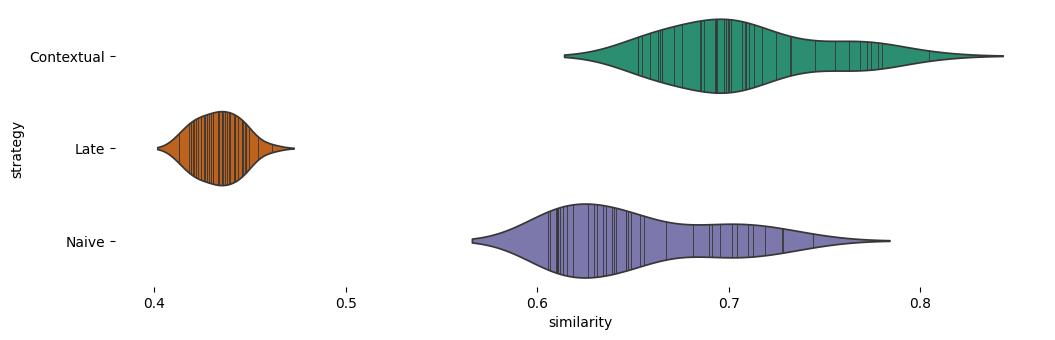

In [50]:
# @title strategy vs similarity

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(display_df['strategy'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(display_df, x='similarity', y='strategy', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


Generating Violin Plot of Similarity Scores...


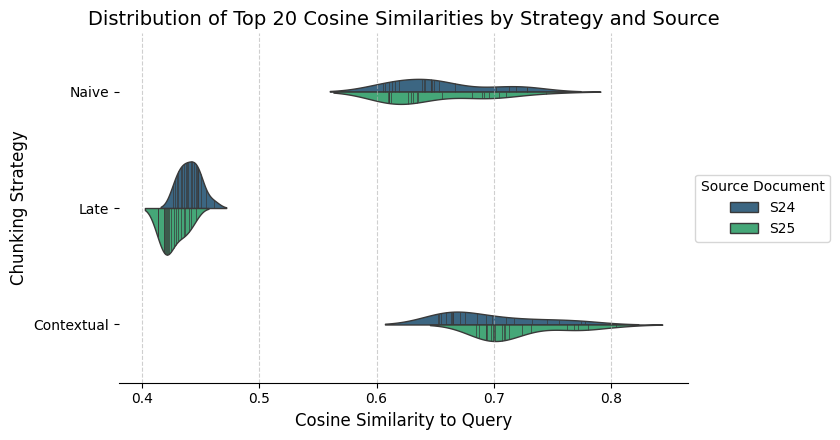

Violin plot displayed.


In [51]:
# @title Violin Plot
# Cell 20: Violin Plot - Similarity Distribution by Strategy

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # To ensure plot displays in relevant environments

print("\nGenerating Violin Plot of Similarity Scores...")

if top_results_df.empty:
    print("Cannot generate plot: top_results_df is empty.")
else:
    # Calculate figsize dynamically based on number of strategies
    num_strategies = len(top_results_df['strategy'].unique())
    figsize_height = 1.5 * num_strategies # Adjust multiplier as needed for aesthetics
    figsize_width = 10 # Fixed width, or adjust as needed

    plt.figure(figsize=(figsize_width, figsize_height))

    # Create the violin plot
    # 'y' is the categorical variable (strategy)
    # 'x' is the numerical variable (similarity)
    # 'data' is the dataframe containing the top N results
    # 'inner'='stick' shows individual data points inside the violin
    # 'palette' sets the color scheme
    # 'hue' can be used to further split by 'source' if desired (might get busy)
    sns.violinplot(data=top_results_df, x='similarity', y='strategy', hue='source', # Added hue='source'
                   inner='stick', palette='viridis', # Changed palette, 'viridis' often looks good
                   split=True, # Split violins for comparing sources within a strategy
                   linewidth=1 # Thinner lines for sticks
                   )

    # Add titles and labels
    plt.title(f'Distribution of Top {N_TOP_RESULTS} Cosine Similarities by Strategy and Source', fontsize=14)
    plt.xlabel('Cosine Similarity to Query', fontsize=12)
    plt.ylabel('Chunking Strategy', fontsize=12)

    # Improve aesthetics
    sns.despine(top=True, right=True, bottom=False, left=True) # Keep bottom axis line
    plt.grid(axis='x', linestyle='--', alpha=0.6) # Add faint grid lines on x-axis
    plt.legend(title='Source Document', loc='center left', bbox_to_anchor=(1, 0.5)) # Move legend outside

    # Adjust layout to prevent clipping
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust right boundary for legend space

    # Show the plot
    plt.show()
    print("Violin plot displayed.")

#Chunking Strategies Compared Version 2



*   Naive Chunking
*   Late Chunking
*   Contextual Chunking


**With Nomic AI Embed model for Late Chunking to improve on Late Chunking performance**

In [15]:
# Cell 1: Install necessary libraries (allowing pip to resolve compatible versions)
!pip install sentence-transformers transformers torch plotly scikit-learn numpy pandas -q

In [16]:
# Cell 2: Import libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [17]:
# Cell 3: Initialize models (UPDATED for Nomic)
# Initialize the embedding model
model_name = 'nomic-ai/nomic-embed-text-v1.5'
print(f"Initializing embedding model: {model_name}")
# Nomic requires trusting remote code
embedding_model = SentenceTransformer(model_name, device=DEVICE, trust_remote_code=True)

# Initialize summarizer pipeline (use device index if GPU available, -1 for CPU)
summarizer_device = 0 if DEVICE == "cuda" else -1
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=summarizer_device)

print("Models Initialized.")
# Note: SentenceTransformer may not reliably expose max_seq_length for all models.
# Nomic v1.5 supports 8192 sequence length.
print(f"Using Embedding Model: {model_name} (Supports 8192 sequence length)")

Initializing embedding model: nomic-ai/nomic-embed-text-v1.5


Device set to use cuda:0


Models Initialized.
Using Embedding Model: nomic-ai/nomic-embed-text-v1.5 (Supports 8192 sequence length)


In [18]:
# Cell 4: Define Naive Chunking function
def naive_chunking(document, chunk_size=256):
    """
    Split the document into chunks first, then embed each chunk individually.
    Args:
        document (str): Full text of the document.
        chunk_size (int): Maximum character size for each chunk (approximation).
    Returns:
        list: List of dictionaries, each containing 'text' and 'embedding'.
    """
    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
    results = []
    print(f"  Naive Chunking: Processing {len(chunks)} potential chunks...")
    count = 0
    for chunk in chunks:
        if chunk.strip(): # Ensure chunk is not just whitespace
            embedding = embedding_model.encode(chunk, convert_to_numpy=True) # Ensure numpy array
            results.append({'text': chunk, 'embedding': embedding, 'strategy': 'Naive'})
            count += 1
    print(f"  Naive Chunking: Generated {count} embeddings.")
    return results

In [19]:
# Cell 5: Define Late Chunking function (UPDATED for Longer Context & Model Type)
def late_chunking(document, chunk_size=256, target_max_length=8192): # Default to Nomic's capability
    """
    Implements Late Chunking by embedding the full document to get token embeddings,
    then pooling token embeddings corresponding to each chunk. Attempts to use a
    longer context window suitable for models like Nomic/Jina.
    Args:
        document (str): Full text of the document.
        chunk_size (int): Approximate character size for defining chunk boundaries.
        target_max_length (int): The desired maximum sequence length to attempt.
    Returns:
        list: List of dictionaries, each containing 'text' and 'embedding'.
    """
    print(f"  Late Chunking: Attempting token pooling with target_max_length={target_max_length}...")
    # 1. Tokenize the entire document and get token embeddings
    if not hasattr(embedding_model, 'tokenizer') or not hasattr(embedding_model, 'encode'):
         print("  Late Chunking Error: Embedding model missing 'tokenizer' or 'encode'.")
         raise AttributeError("Embedding model must have a 'tokenizer' attribute and 'encode' method.")

    # Use the provided target_max_length for tokenization
    effective_max_length = target_max_length

    try:
        print(f"  Late Chunking: Tokenizing document (attempting max_length={effective_max_length})...")
        # Explicitly pass the desired max_length to the tokenizer
        tokenized_full = embedding_model.tokenizer(
            document,
            return_offsets_mapping=True,
            return_tensors='pt',
            truncation=True,
            max_length=effective_max_length # USE THE TARGET LENGTH HERE
        ).to(embedding_model.device)
        num_tokens = tokenized_full['input_ids'].shape[1]
        print(f"  Late Chunking: Document tokenized into {num_tokens} tokens (respecting truncation limit).")

        print(f"  Late Chunking: Encoding document to get token embeddings...")
        with torch.no_grad():
             # SentenceTransformer's encode doesn't directly take max_length here
             # It relies on the tokenizer settings and model's internal configuration
             outputs = embedding_model.encode(
                 document, # Pass the original document string
                 output_value='token_embeddings',
                 convert_to_tensor=True,
                 batch_size=1,
                 # Remove truncate=True from here, handled by tokenizer primarily
                ).to(embedding_model.device) # Move output to correct device

        print(f"  Late Chunking: Raw token embedding output shape: {outputs.shape}")
        # The output shape's token dimension should now reflect the *actual* number of tokens processed
        if len(outputs.shape) == 3 and outputs.shape[0] == 1:
            token_embeddings = outputs[0]
        elif len(outputs.shape) == 2:
             if outputs.shape[0] != num_tokens:
                  print(f"  Late Chunking Warning: Token count mismatch between tokenizer ({num_tokens}) and embedding output ({outputs.shape[0]}). Using embedding output count.")
             token_embeddings = outputs
        else:
             print(f"  Late Chunking Error: Unexpected shape for token embeddings: {outputs.shape}")
             raise ValueError(f"Unexpected shape for token embeddings: {outputs.shape}")
        print(f"  Late Chunking: Processed token embedding shape: {token_embeddings.shape}")

        # Ensure offset mapping matches the actual token embeddings dimension
        offset_mapping = tokenized_full['offset_mapping'][0,:token_embeddings.shape[0]].cpu().numpy() # Slice offsets

    except Exception as e:
        print(f"  Late Chunking Error: Failed getting token embeddings or offset mapping: {e}")
        print("  Late Chunking: Falling back to simplified mode (single embedding).")
        # Fallback to the previous simplified method using a reasonable length
        fallback_max_len = 512 # Use 512 as a safer fallback length
        truncated_document = document[:fallback_max_len * 4] # Heuristic
        document_embedding = embedding_model.encode(truncated_document, convert_to_numpy=True)
        chunks_text = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
        results = [{'text': chunk, 'embedding': document_embedding, 'strategy': 'Late'} for chunk in chunks_text if chunk.strip()]
        print(f"  Late Chunking (Fallback): Generated {len(results)} embeddings.")
        return results

    # 2. Define character-level chunk boundaries
    chunks_text_boundaries = []
    for i in range(0, len(document), chunk_size):
        start_char = i
        end_char = i + chunk_size
        chunk_text = document[start_char:end_char]
        if chunk_text.strip():
            chunks_text_boundaries.append({
                'text': chunk_text,
                'start_char': start_char,
                'end_char': end_char
            })
    print(f"  Late Chunking: Defined {len(chunks_text_boundaries)} text chunk boundaries.")

    # 3. Map char boundaries to token boundaries and pool token embeddings
    results = []
    token_embeddings_np = token_embeddings.cpu().numpy()

    for chunk_info in chunks_text_boundaries:
        start_char = chunk_info['start_char']
        end_char = chunk_info['end_char']
        token_indices = []
        for idx, (token_start, token_end) in enumerate(offset_mapping):
            if token_start == 0 and token_end == 0: continue
            if token_start < end_char and token_end > start_char:
                 if idx < token_embeddings_np.shape[0]:
                     token_indices.append(idx)

        if token_indices:
            chunk_token_embeddings = token_embeddings_np[token_indices]
            chunk_embedding = np.mean(chunk_token_embeddings, axis=0)
            results.append({
                'text': chunk_info['text'],
                'embedding': chunk_embedding,
                'strategy': 'Late'
            })

    if not results and chunks_text_boundaries:
         print("  Late Chunking Warning: Failed to generate any embeddings using token pooling. Falling back to simplified mode.")
         # Fallback again if needed
         fallback_max_len = 512
         truncated_document = document[:fallback_max_len * 4]
         document_embedding = embedding_model.encode(truncated_document, convert_to_numpy=True)
         chunks_text = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
         results = [{'text': chunk, 'embedding': document_embedding, 'strategy': 'Late'} for chunk in chunks_text if chunk.strip()]
         print(f"  Late Chunking (Fallback): Generated {len(results)} embeddings.")
    else:
        print(f"  Late Chunking (Token Pooling): Generated {len(results)} embeddings.") # This count should now be higher

    return results

In [21]:
# Cell 6: Define Contextual Chunking function
def contextual_chunking(document, chunk_size=256):
    """
    Generate context-aware chunks by summarizing the document and appending
    the summary to each chunk *before* embedding.
    Args:
        document (str): Full text of the document.
        chunk_size (int): Maximum character size for text chunks (before adding summary).
    Returns:
        list: List of dictionaries, each containing 'text' (original chunk) and 'embedding' (of chunk + summary).
    """
    print(f"  Contextual Chunking: Generating summary...")
    # Summarizer often has its own limits (e.g., BART ~1024 tokens)
    max_summary_input_length = 1024 * 4 # Heuristic
    truncated_for_summary = document[:max_summary_input_length]
    if len(document) > len(truncated_for_summary):
        print(f"  Contextual Chunking Warning: Document truncated for summarization to ~{len(truncated_for_summary)} chars.")

    # Generate a summary
    try:
        summary = summarizer(truncated_for_summary, max_length=130, min_length=20, do_sample=False)[0]['summary_text']
        print(f"  Contextual Chunking: Summary generated.")
    except Exception as e:
        print(f"  Contextual Chunking Error during summarization: {e}. Using empty summary.")
        summary = ""

    # Split the *original* document into chunks
    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
    print(f"  Contextual Chunking: Processing {len(chunks)} potential chunks...")
    results = []
    count = 0
    for chunk in chunks:
       if chunk.strip():
            # Create the enriched text for embedding
            enriched_chunk_for_embedding = chunk + " [CONTEXT_SUMMARY] " + summary
            # Embed the enriched chunk
            embedding = embedding_model.encode(enriched_chunk_for_embedding, convert_to_numpy=True)
            # Store the *original* chunk text but the *enriched* embedding
            results.append({'text': chunk, 'embedding': embedding, 'strategy': 'Contextual'})
            count += 1
    print(f"  Contextual Chunking: Generated {count} embeddings.")
    return results

In [22]:
# Cell 7: Define the Sample Document
sample_document = """
## Samsung Galaxy S25 Support Documentation: Common Issues and Solutions

The Samsung Galaxy S25 series, including the S25, S25+, and S25 Ultra, is a flagship lineup packed with advanced features. However, like any new smartphone release, users have reported various issues. This support document outlines common problems, troubleshooting steps, and solutions to ensure optimal performance.

---

### **Common Issues with the Galaxy S25 Series**

#### **1. Display Issues**
- **Problems:** Users have reported scrolling lag, screen flickering, and dim brightness.
- **Causes:** These issues are often software-related or linked to display settings.
- **Solutions:**
  - Disable Always-On Display (AOD) by entering Safe Mode and uninstalling the AOD app[5][8].
  - Adjust screen brightness in *Settings > Display > Screen mode* and use the Vividness slider for preferred color tuning[8].
  - Increase touch sensitivity via *Settings > Display* if taps are missed or scrolling feels unresponsive[8].

#### **2. Overheating**
- **Problems:** Some Galaxy S25 devices experience overheating during intensive use.
- **Causes:** Likely related to the Snapdragon 8 Elite chipset or high-performance settings.
- **Solutions:**
  - Avoid using the device in direct sunlight or while charging.
  - Enable power-saving mode in *Settings > Battery* to reduce strain on the processor[3][9].
  - Check for software updates that may address chipset optimization[9].

#### **3. Camera Problems**
- **Problems:** Issues include streaks in photos taken under strong light conditions and inconsistent autofocus.
- **Causes:** Software bugs or hardware calibration errors.
- **Solutions:**
  - Update camera software via *Settings > Software Update*[3][9].
  - Clear cache for the camera app in *Settings > Apps > Camera > Storage > Clear Cache*[4].
  - If problems persist, visit a Samsung service center for hardware inspection[9].

#### **4. Battery Drain**
- **Problems:** Faster-than-expected battery depletion even under moderate usage.
- **Causes:** High refresh rates, background apps, or Always-On Display.
- **Solutions:**
  - Check battery usage in *Settings > Battery and Device Care* and restrict power-hungry apps[9].
  - Reduce refresh rate to Adaptive or Standard mode via *Settings > Display*[9].
  - Disable features like Always-On Display and Location Services when not needed[9].

#### **5. App Notification Delays**
- **Problems:** Notifications from apps like WhatsApp and Facebook are delayed.
- **Causes:** Battery optimization settings or app-specific bugs.
- **Solutions:**
  - Disable battery optimization for affected apps in *Settings > Battery > Background Usage Limits*[5].
  - Ensure Do Not Disturb mode is turned off[9].
  - Update apps to their latest versions via Google Play Store[3].

#### **6. Android Auto Connectivity Issues**
- **Problems:** Some users report that Android Auto fails to recognize the device.
- **Causes:** Compatibility issues with car head units or software bugs.
- **Solutions:**
  - Try a different USB cable or port.
  - Clear cache for Android Auto via *Settings > Apps > Android Auto > Storage > Clear Cache*[4].
  - Wait for updates from Google to address compatibility issues[3].

---

### **Troubleshooting Steps**

#### **Soft Reset (Force Restart)**
If your device becomes unresponsive:
1. Press and hold the Volume Down key + Side key simultaneously for at least 7 seconds until the phone restarts[4].

#### **Clear App Cache**
To resolve app-related issues:
1. Navigate to *Settings > Battery and Device Care*.
2. Tap "Optimize Now" to clear cache data[4].

#### **Factory Reset**
To resolve persistent problems:
1. Go to *Settings > General Management > Reset > Factory Data Reset*.
2. Confirm reset after backing up important data, as this erases all personal information[5][6].

#### **Safe Mode Troubleshooting**
For issues caused by third-party apps:
1. Restart into Safe Mode by holding Volume Down + Side key until the Samsung logo appears.
2. Uninstall problematic apps via *Settings > Apps*[4][5].

---

### **Hardware-Specific Features**

#### Galaxy S25 Ultra
The Ultra model includes unique features such as:
- S Pen functionality for advanced productivity tasks[2].
- Enhanced camera capabilities like macro photography and 8K video recording[7].

#### Wireless Charging
All models support wireless charging but may require removing accessories or cases for stable charging performance[2].

---

### **Service Center Support**
If troubleshooting fails:
1. Visit a Samsung service center for hardware repairs or replacements.
2. Check service center wait times online to minimize delays[4].

---

### Conclusion
The Samsung Galaxy S25 series offers cutting-edge technology but may encounter occasional issues typical of new devices. By following these troubleshooting steps and solutions, users can resolve most problems efficiently while maximizing their smartphone experience. For unresolved issues, professional assistance is available through Samsung service centers.
"""

print("Sample document defined.")

Sample document defined.


In [23]:
# Cell 8: Define Sample Query and Chunk Size
sample_query = "How to fix overheating on Galaxy S25?"
chunk_size = 256 # Adjust as needed, smaller makes visualization denser

print(f"Sample query: '{sample_query}'")
print(f"Chunk size: {chunk_size} characters")

Sample query: 'How to fix overheating on Galaxy S25?'
Chunk size: 256 characters


In [24]:
# Cell 9: Run all chunking methods and collect results
all_results = []

print("Running Naive Chunking...")
naive_results = naive_chunking(sample_document, chunk_size)
all_results.extend(naive_results)
print(f"Completed Naive Chunking.\n")

print("Running Late Chunking...")
late_results = late_chunking(sample_document, chunk_size) # Will now use Nomic
all_results.extend(late_results)
print(f"Completed Late Chunking.\n")


print("Running Contextual Chunking...")
contextual_results = contextual_chunking(sample_document, chunk_size)
all_results.extend(contextual_results)
print(f"Completed Contextual Chunking.\n")

# Create a DataFrame (optional, but can be convenient for inspection)
df_results = pd.DataFrame(all_results)
print(f"Total results collected: {len(df_results)}")
# Optional: Display head/info to check structure
# print(df_results.head())
# print(df_results.info())
# print(df_results['strategy'].value_counts())

Running Naive Chunking...
  Naive Chunking: Processing 20 potential chunks...
  Naive Chunking: Generated 20 embeddings.
Completed Naive Chunking.

Running Late Chunking...
  Late Chunking: Attempting token pooling with target_max_length=8192...
  Late Chunking: Tokenizing document (attempting max_length=8192)...
  Late Chunking: Document tokenized into 1234 tokens (respecting truncation limit).
  Late Chunking: Encoding document to get token embeddings...
  Late Chunking: Raw token embedding output shape: torch.Size([1234, 768])
  Late Chunking: Processed token embedding shape: torch.Size([1234, 768])
  Late Chunking: Defined 20 text chunk boundaries.
  Late Chunking (Token Pooling): Generated 20 embeddings.
Completed Late Chunking.

Running Contextual Chunking...
  Contextual Chunking: Generating summary...
  Contextual Chunking Warning: Document truncated for summarization to ~4096 chars.
  Contextual Chunking: Summary generated.
  Contextual Chunking: Processing 20 potential chunks

In [26]:
# Cell 10: Prepare data for Visualization (CORRECTED Doc Ref Encoding)
print("Preparing data for visualization...")

# Filter out any results where embedding generation might have failed
valid_results = [res for res in all_results if 'embedding' in res and isinstance(res['embedding'], np.ndarray)]
print(f"Filtered results with valid embeddings: {len(valid_results)}")

if not valid_results:
    raise ValueError("No valid embeddings found in results. Check chunking functions and model compatibility.")

chunk_texts = [res['text'] for res in valid_results]
embeddings_list = [res['embedding'] for res in valid_results] # Already numpy arrays from functions
strategies = [res['strategy'] for res in valid_results]

embeddings = np.array(embeddings_list) # Stack valid embeddings

# Embed the query
print("Embedding query...")
query_embedding = embedding_model.encode(sample_query, convert_to_numpy=True)

# Embed the *entire* document for general reference point.
# Rely on the model's internal handling of sequence length for its standard pooled output.
print("Generating Document Reference embedding (pooled)...")
# Pass the full document using the 'sentences' keyword argument.
document_embedding_ref = embedding_model.encode(sentences=sample_document, convert_to_numpy=True) # <--- FIX HERE
print(f"Generated Document Reference embedding.")


# Stack all embeddings for PCA: Chunks + Query + Document Reference
print("Stacking embeddings for PCA...")
all_embeddings_for_pca = np.vstack([
    embeddings,
    query_embedding.reshape(1, -1),
    document_embedding_ref.reshape(1, -1)
])
print(f"Shape of data for PCA: {all_embeddings_for_pca.shape}")

# Create corresponding labels and hover texts
chunk_hover_texts = [text[:100] + '...' if len(text) > 100 else text for text in chunk_texts]
all_labels = strategies + ['Query', 'Document Reference']
all_hover_texts = chunk_hover_texts + [sample_query, 'Full Document Reference (Pooled)'] # Clarify hover text
print(f"Number of labels: {len(all_labels)}")
print(f"Number of hover texts: {len(all_hover_texts)}")

# Verify lengths match PCA input rows
if all_embeddings_for_pca.shape[0] != len(all_labels):
    print(f"ERROR: Mismatch between PCA input rows ({all_embeddings_for_pca.shape[0]}) and labels ({len(all_labels)})")
if all_embeddings_for_pca.shape[0] != len(all_hover_texts):
     print(f"ERROR: Mismatch between PCA input rows ({all_embeddings_for_pca.shape[0]}) and hover texts ({len(all_hover_texts)})")

print("Data preparation complete.")

Preparing data for visualization...
Filtered results with valid embeddings: 60
Embedding query...
Generating Document Reference embedding (pooled)...
Generated Document Reference embedding.
Stacking embeddings for PCA...
Shape of data for PCA: (62, 768)
Number of labels: 62
Number of hover texts: 62
Data preparation complete.


In [27]:
# Cell 11: Perform PCA
print("Performing PCA...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings_for_pca)
print(f"PCA executed. Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Shape of 2D embeddings: {embeddings_2d.shape}")

Performing PCA...
PCA executed. Explained variance ratio: [0.21312718 0.10152502]
Shape of 2D embeddings: (62, 2)


In [28]:
# Cell 12: Create Visualization with Plotly
print("Creating Plotly visualization...")
fig = go.Figure()

# Define colors for strategies
color_map = {
    'Naive': 'blue',
    'Late': 'green', # Standard green
    'Contextual': 'red',
    'Query': 'black',
    'Document Reference': 'purple'
}

# Plot Naive, Late, and Contextual chunks as scatter plots
for strategy in ['Naive', 'Late', 'Contextual']:
    indices = [i for i, label in enumerate(all_labels) if label == strategy and i < embeddings_2d.shape[0] - 2]

    if not indices:
        print(f"  No points found for strategy: {strategy}")
        continue

    print(f"  Plotting {len(indices)} points for strategy: {strategy}")
    fig.add_trace(go.Scatter(
        x=embeddings_2d[indices, 0],
        y=embeddings_2d[indices, 1],
        mode='markers',
        name=strategy,
        marker=dict(
            color=color_map[strategy],
            size=8,
            opacity=0.7
            ),
        text=[all_hover_texts[i] for i in indices],
        hoverinfo='text+name'
    ))

# Add Document Reference embedding
doc_ref_index = -1
label_name = 'Document Reference'
try:
    doc_ref_index = all_labels.index(label_name)
    if doc_ref_index == len(all_labels) - 1:
      print(f"  Plotting {label_name} at index {doc_ref_index}")
      fig.add_trace(go.Scatter(
          x=[embeddings_2d[doc_ref_index, 0]],
          y=[embeddings_2d[doc_ref_index, 1]],
          mode='markers+text',
          name=label_name,
          text=['<b>Doc Ref</b>'],
          textposition="bottom center",
          marker=dict(
              color=color_map[label_name],
              size=12,
              symbol='diamond',
              opacity=0.9),
          hoverinfo='text+name',
          hovertext=[all_hover_texts[doc_ref_index]]
      ))
    else:
        print(f"Warning: '{label_name}' found but not at the expected last position ({doc_ref_index} vs {len(all_labels)-1}). Skipping plot.")
except (ValueError, IndexError):
    print(f"Warning: '{label_name}' not found or index issue. Skipping plot.")


# Add Query embedding
query_index = -1
label_name = 'Query'
try:
    query_index = all_labels.index(label_name)
    if query_index == len(all_labels) - 2:
      print(f"  Plotting {label_name} at index {query_index}")
      fig.add_trace(go.Scatter(
          x=[embeddings_2d[query_index, 0]],
          y=[embeddings_2d[query_index, 1]],
          mode='markers+text',
          name=label_name,
          text=['<b>Query</b>'],
          textposition="top center",
          marker=dict(
              color=color_map[label_name],
              size=15,
              symbol='star',
              opacity=1.0),
          hoverinfo='text+name',
          hovertext=[all_hover_texts[query_index]]
      ))
    else:
       print(f"Warning: '{label_name}' found but not at the expected second-to-last position ({query_index} vs {len(all_labels)-2}). Skipping plot.")
except (ValueError, IndexError):
     print(f"Warning: '{label_name}' not found or index issue. Skipping plot.")

print("Plot object created.")

Creating Plotly visualization...
  Plotting 20 points for strategy: Naive
  Plotting 20 points for strategy: Late
  Plotting 20 points for strategy: Contextual
  Plotting Document Reference at index 61
  Plotting Query at index 60
Plot object created.


In [29]:
# Cell 13: Update layout and show plot
print("Updating plot layout and displaying...")
fig.update_layout(
    title=f"PCA Visualization of Chunking Strategies (Query: '{sample_query}')",
    xaxis_title=f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})", # Use percentage format
    yaxis_title=f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})", # Use percentage format
    width=1000,
    height=800,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
    margin=dict(l=50, r=50, t=100, b=50),
    hovermode='closest'
)

fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


**Cell 14: Interpretation (Updated for Nomic/Longer Context)**

**Interpreting the Visualization (Using Nomic Embeddings):**

1.  **Proximity to Query:** Observe which strategy's chunks (dots of a specific color) cluster closest to the Query marker (black star). With Nomic, known for good retrieval performance, the relative positions might differ from MiniLM. Assess if Contextual (Red) or Late (Green) chunks are generally nearer to the query for this specific example.
2.  **Cluster Cohesion and Location:**
    *   **Naive (Blue):** Still expected to show significant scatter, reflecting its lack of broader context.
    *   **Late (Green - Token Pooling with Nomic):** Should now form a potentially tighter cluster than Naive. Since Nomic processed a much longer context (up to 8192 tokens) to generate the token embeddings, this cluster represents chunks aware of nearly the entire document. Its position relative to the Document Reference (Purple Diamond) will be interesting – it might be close if the pooled token embeddings align well with the overall pooled document embedding, or it might shift based on the specifics of Nomic's token representations. Expect a clear cluster, not a single point.
    *   **Contextual (Red):** Similar logic applies – clustering depends on the LLM summary. Compare its location and spread to both Naive and Late.
3.  **Relation to Document Reference:** The Document Reference (Purple Diamond) represents the standard pooled embedding of the *entire* document using Nomic. Compare the centers of the Naive, Late, and Contextual clusters to this point. Late chunking, having processed most/all of the document's tokens, might conceptually be closer than Naive, but the pooling mechanism differs, so empirical results matter.
4.  **Outliers:** As before, look for points far from their respective clusters.

**Key Considerations with Nomic:**
*   **Longer Context:** The key difference is that the Late Chunking embeddings (Green) are now derived from token embeddings that were calculated with awareness of a much larger context (potentially the whole document if < 8192 tokens). This should, theoretically, make them more robust than the severely truncated MiniLM version.
*   **Computational Cost:** Generating token embeddings for 8192 tokens is significantly more computationally intensive (time and memory, especially GPU memory) than for 256/512 tokens or doing simple naive chunk embedding.
*   **Model Characteristics:** Nomic has different training data and architectural nuances than MiniLM, so the resulting embedding space and relationships between points will differ.
*   **`trust_remote_code=True`:** Remember this was necessary for loading the model.

#Chunking Strategies Compared Version 1



*   Naive Chunking
*   Late Chunking
*   Contextual Chunking



In [ ]:
# Cell 1: Install necessary libraries (allowing pip to resolve compatible versions)
!pip install sentence-transformers transformers torch plotly scikit-learn numpy pandas -q

In [2]:
# Cell 2: Import libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Cell 3: Initialize models
# Initialize the embedding model
embedding_model = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', device=DEVICE,trust_remote_code=True)

# Initialize summarizer pipeline (use device index if GPU available, -1 for CPU)
summarizer_device = 0 if DEVICE == "cuda" else -1
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=summarizer_device)

print("Models Initialized.")
print(f"Embedding Model Max Sequence Length: {getattr(embedding_model, 'max_seq_length', 'Not Specified (Using Default)')}")

configuration_hf_nomic_bert.py:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- configuration_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hf_nomic_bert.py:   0%|          | 0.00/103k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Models Initialized.
Embedding Model Max Sequence Length: 8192


In [5]:
# Cell 4: Define Naive Chunking function
def naive_chunking(document, chunk_size=256):
    """
    Split the document into chunks first, then embed each chunk individually.
    Args:
        document (str): Full text of the document.
        chunk_size (int): Maximum character size for each chunk (approximation).
    Returns:
        list: List of dictionaries, each containing 'text' and 'embedding'.
    """
    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
    results = []
    print(f"  Naive Chunking: Processing {len(chunks)} potential chunks...")
    count = 0
    for chunk in chunks:
        if chunk.strip(): # Ensure chunk is not just whitespace
            embedding = embedding_model.encode(chunk, convert_to_numpy=True) # Ensure numpy array
            results.append({'text': chunk, 'embedding': embedding, 'strategy': 'Naive'})
            count += 1
    print(f"  Naive Chunking: Generated {count} embeddings.")
    return results

In [6]:
# Cell 5: Define Late Chunking function (REVISED - Addressing Truncation)
def late_chunking(document, chunk_size=256, target_max_length=4096): # Add target_max_length
    """
    Implements Late Chunking by embedding the full document to get token embeddings,
    then pooling token embeddings corresponding to each chunk. Attempts to use a
    longer context window.
    Args:
        document (str): Full text of the document.
        chunk_size (int): Approximate character size for defining chunk boundaries.
        target_max_length (int): The desired maximum sequence length to attempt.
    Returns:
        list: List of dictionaries, each containing 'text' and 'embedding'.
    """
    print(f"  Late Chunking: Attempting token pooling with target_max_length={target_max_length}...")
    # 1. Tokenize the entire document and get token embeddings
    if not hasattr(embedding_model, 'tokenizer') or not hasattr(embedding_model, 'encode'):
         print("  Late Chunking Error: Embedding model missing 'tokenizer' or 'encode'.")
         raise AttributeError("Embedding model must have a 'tokenizer' attribute and 'encode' method.")

    # Use the provided target_max_length for tokenization and embedding attempt
    effective_max_length = target_max_length

    try:
        print(f"  Late Chunking: Tokenizing document (attempting max_length={effective_max_length})...")
        # Explicitly pass the desired max_length to the tokenizer
        tokenized_full = embedding_model.tokenizer(
            document,
            return_offsets_mapping=True,
            return_tensors='pt',
            truncation=True,
            max_length=effective_max_length # USE THE TARGET LENGTH HERE
        ).to(embedding_model.device)
        num_tokens = tokenized_full['input_ids'].shape[1]
        # The actual number of tokens might still be less if the doc is short, or limited by the model's absolute max
        print(f"  Late Chunking: Document tokenized into {num_tokens} tokens (respecting truncation limit).")

        print(f"  Late Chunking: Encoding document to get token embeddings...")
        with torch.no_grad():
             # Ensure encode also respects truncation, possibly via model's internal config
             # SentenceTransformer's encode might not directly accept max_length, relies on tokenizer
             outputs = embedding_model.encode(
                 document,
                 output_value='token_embeddings',
                 convert_to_tensor=True,
                 batch_size=1,
                 truncate=True # Essential to prevent errors if doc exceeds absolute limit
                ).to(embedding_model.device) # Move output to correct device

        print(f"  Late Chunking: Raw token embedding output shape: {outputs.shape}")
        # The output shape's token dimension should now reflect the *actual* number of tokens processed up to effective_max_length
        if len(outputs.shape) == 3 and outputs.shape[0] == 1:
            token_embeddings = outputs[0]
        elif len(outputs.shape) == 2:
             # Handle case where batch dim might already be squeezed by encode
             if outputs.shape[0] != num_tokens:
                  print(f"  Late Chunking Warning: Token count mismatch between tokenizer ({num_tokens}) and embedding output ({outputs.shape[0]}). Using embedding output count.")
                  # This might happen if encode internally truncated differently
             token_embeddings = outputs
        else:
             print(f"  Late Chunking Error: Unexpected shape for token embeddings: {outputs.shape}")
             raise ValueError(f"Unexpected shape for token embeddings: {outputs.shape}")
        print(f"  Late Chunking: Processed token embedding shape: {token_embeddings.shape}")

        # Ensure offset mapping matches the actual token embeddings dimension
        offset_mapping = tokenized_full['offset_mapping'][0,:token_embeddings.shape[0]].cpu().numpy() # Slice offsets to match actual tokens

    except Exception as e:
        print(f"  Late Chunking Error: Failed getting token embeddings or offset mapping: {e}")
        print("  Late Chunking: Falling back to simplified mode (single embedding).")
        # Fallback to the previous simplified method
        fallback_max_len = 512 # Use a reasonable default for fallback
        try:
            model_max_len_attr = embedding_model.max_seq_length
            if model_max_len_attr: fallback_max_len = model_max_len_attr
        except AttributeError: pass # Ignore if attribute missing
        truncated_document = document[:fallback_max_len * 4] # Heuristic
        document_embedding = embedding_model.encode(truncated_document, convert_to_numpy=True)
        chunks_text = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
        results = [{'text': chunk, 'embedding': document_embedding, 'strategy': 'Late'} for chunk in chunks_text if chunk.strip()]
        print(f"  Late Chunking (Fallback): Generated {len(results)} embeddings.")
        return results

    # 2. Define character-level chunk boundaries (Same as before)
    chunks_text_boundaries = []
    for i in range(0, len(document), chunk_size):
        start_char = i
        end_char = i + chunk_size
        chunk_text = document[start_char:end_char]
        if chunk_text.strip():
            chunks_text_boundaries.append({
                'text': chunk_text,
                'start_char': start_char,
                'end_char': end_char
            })
    print(f"  Late Chunking: Defined {len(chunks_text_boundaries)} text chunk boundaries.")

    # 3. Map char boundaries to token boundaries and pool token embeddings (Same logic, but now with potentially more tokens)
    results = []
    token_embeddings_np = token_embeddings.cpu().numpy()

    for chunk_info in chunks_text_boundaries:
        start_char = chunk_info['start_char']
        end_char = chunk_info['end_char']
        token_indices = []
        for idx, (token_start, token_end) in enumerate(offset_mapping): # Use potentially sliced offset_mapping
            if token_start == 0 and token_end == 0: continue
            if token_start < end_char and token_end > start_char:
                 if idx < token_embeddings_np.shape[0]: # Double check index validity
                     token_indices.append(idx)

        if token_indices:
            chunk_token_embeddings = token_embeddings_np[token_indices]
            chunk_embedding = np.mean(chunk_token_embeddings, axis=0)
            results.append({
                'text': chunk_info['text'],
                'embedding': chunk_embedding,
                'strategy': 'Late'
            })

    # Same fallback logic if pooling still yields no results
    if not results and chunks_text_boundaries:
         print("  Late Chunking Warning: Failed to generate any embeddings using token pooling (even after trying target length). Falling back to simplified mode.")
         # Fallback
         fallback_max_len = 512
         try:
            model_max_len_attr = embedding_model.max_seq_length
            if model_max_len_attr: fallback_max_len = model_max_len_attr
         except AttributeError: pass
         truncated_document = document[:fallback_max_len * 4]
         document_embedding = embedding_model.encode(truncated_document, convert_to_numpy=True)
         chunks_text = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
         results = [{'text': chunk, 'embedding': document_embedding, 'strategy': 'Late'} for chunk in chunks_text if chunk.strip()]
         print(f"  Late Chunking (Fallback): Generated {len(results)} embeddings.")
    else:
        print(f"  Late Chunking (Token Pooling): Generated {len(results)} embeddings.") # This count should be higher now

    return results

In [7]:
# Cell 6: Define Contextual Chunking function
def contextual_chunking(document, chunk_size=256):
    """
    Generate context-aware chunks by summarizing the document and appending
    the summary to each chunk *before* embedding.
    Args:
        document (str): Full text of the document.
        chunk_size (int): Maximum character size for text chunks (before adding summary).
    Returns:
        list: List of dictionaries, each containing 'text' (original chunk) and 'embedding' (of chunk + summary).
    """
    print(f"  Contextual Chunking: Generating summary...")
    # Summarizer often has its own limits (e.g., BART ~1024 tokens)
    max_summary_input_length = 1024 * 4 # Heuristic
    truncated_for_summary = document[:max_summary_input_length]
    if len(document) > len(truncated_for_summary):
        print(f"  Contextual Chunking Warning: Document truncated for summarization to ~{len(truncated_for_summary)} chars.")

    # Generate a summary
    try:
        summary = summarizer(truncated_for_summary, max_length=130, min_length=20, do_sample=False)[0]['summary_text']
        print(f"  Contextual Chunking: Summary generated.")
    except Exception as e:
        print(f"  Contextual Chunking Error during summarization: {e}. Using empty summary.")
        summary = ""

    # Split the *original* document into chunks
    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]
    print(f"  Contextual Chunking: Processing {len(chunks)} potential chunks...")
    results = []
    count = 0
    for chunk in chunks:
       if chunk.strip():
            # Create the enriched text for embedding
            enriched_chunk_for_embedding = chunk + " [CONTEXT_SUMMARY] " + summary
            # Embed the enriched chunk
            embedding = embedding_model.encode(enriched_chunk_for_embedding, convert_to_numpy=True)
            # Store the *original* chunk text but the *enriched* embedding
            results.append({'text': chunk, 'embedding': embedding, 'strategy': 'Contextual'})
            count += 1
    print(f"  Contextual Chunking: Generated {count} embeddings.")
    return results

In [8]:
# Cell 7: Define the Sample Document
sample_document = """
## Samsung Galaxy S25 Support Documentation: Common Issues and Solutions

The Samsung Galaxy S25 series, including the S25, S25+, and S25 Ultra, is a flagship lineup packed with advanced features. However, like any new smartphone release, users have reported various issues. This support document outlines common problems, troubleshooting steps, and solutions to ensure optimal performance.

---

### **Common Issues with the Galaxy S25 Series**

#### **1. Display Issues**
- **Problems:** Users have reported scrolling lag, screen flickering, and dim brightness.
- **Causes:** These issues are often software-related or linked to display settings.
- **Solutions:**
  - Disable Always-On Display (AOD) by entering Safe Mode and uninstalling the AOD app[5][8].
  - Adjust screen brightness in *Settings > Display > Screen mode* and use the Vividness slider for preferred color tuning[8].
  - Increase touch sensitivity via *Settings > Display* if taps are missed or scrolling feels unresponsive[8].

#### **2. Overheating**
- **Problems:** Some Galaxy S25 devices experience overheating during intensive use.
- **Causes:** Likely related to the Snapdragon 8 Elite chipset or high-performance settings.
- **Solutions:**
  - Avoid using the device in direct sunlight or while charging.
  - Enable power-saving mode in *Settings > Battery* to reduce strain on the processor[3][9].
  - Check for software updates that may address chipset optimization[9].

#### **3. Camera Problems**
- **Problems:** Issues include streaks in photos taken under strong light conditions and inconsistent autofocus.
- **Causes:** Software bugs or hardware calibration errors.
- **Solutions:**
  - Update camera software via *Settings > Software Update*[3][9].
  - Clear cache for the camera app in *Settings > Apps > Camera > Storage > Clear Cache*[4].
  - If problems persist, visit a Samsung service center for hardware inspection[9].

#### **4. Battery Drain**
- **Problems:** Faster-than-expected battery depletion even under moderate usage.
- **Causes:** High refresh rates, background apps, or Always-On Display.
- **Solutions:**
  - Check battery usage in *Settings > Battery and Device Care* and restrict power-hungry apps[9].
  - Reduce refresh rate to Adaptive or Standard mode via *Settings > Display*[9].
  - Disable features like Always-On Display and Location Services when not needed[9].

#### **5. App Notification Delays**
- **Problems:** Notifications from apps like WhatsApp and Facebook are delayed.
- **Causes:** Battery optimization settings or app-specific bugs.
- **Solutions:**
  - Disable battery optimization for affected apps in *Settings > Battery > Background Usage Limits*[5].
  - Ensure Do Not Disturb mode is turned off[9].
  - Update apps to their latest versions via Google Play Store[3].

#### **6. Android Auto Connectivity Issues**
- **Problems:** Some users report that Android Auto fails to recognize the device.
- **Causes:** Compatibility issues with car head units or software bugs.
- **Solutions:**
  - Try a different USB cable or port.
  - Clear cache for Android Auto via *Settings > Apps > Android Auto > Storage > Clear Cache*[4].
  - Wait for updates from Google to address compatibility issues[3].

---

### **Troubleshooting Steps**

#### **Soft Reset (Force Restart)**
If your device becomes unresponsive:
1. Press and hold the Volume Down key + Side key simultaneously for at least 7 seconds until the phone restarts[4].

#### **Clear App Cache**
To resolve app-related issues:
1. Navigate to *Settings > Battery and Device Care*.
2. Tap "Optimize Now" to clear cache data[4].

#### **Factory Reset**
To resolve persistent problems:
1. Go to *Settings > General Management > Reset > Factory Data Reset*.
2. Confirm reset after backing up important data, as this erases all personal information[5][6].

#### **Safe Mode Troubleshooting**
For issues caused by third-party apps:
1. Restart into Safe Mode by holding Volume Down + Side key until the Samsung logo appears.
2. Uninstall problematic apps via *Settings > Apps*[4][5].

---

### **Hardware-Specific Features**

#### Galaxy S25 Ultra
The Ultra model includes unique features such as:
- S Pen functionality for advanced productivity tasks[2].
- Enhanced camera capabilities like macro photography and 8K video recording[7].

#### Wireless Charging
All models support wireless charging but may require removing accessories or cases for stable charging performance[2].

---

### **Service Center Support**
If troubleshooting fails:
1. Visit a Samsung service center for hardware repairs or replacements.
2. Check service center wait times online to minimize delays[4].

---

### Conclusion
The Samsung Galaxy S25 series offers cutting-edge technology but may encounter occasional issues typical of new devices. By following these troubleshooting steps and solutions, users can resolve most problems efficiently while maximizing their smartphone experience. For unresolved issues, professional assistance is available through Samsung service centers.
"""

print("Sample document defined.")

Sample document defined.


In [9]:
# Cell 8: Define Sample Query and Chunk Size
sample_query = "How to fix overheating on Galaxy S25?"
chunk_size = 256 # Adjust as needed, smaller makes visualization denser

print(f"Sample query: '{sample_query}'")
print(f"Chunk size: {chunk_size} characters")

Sample query: 'How to fix overheating on Galaxy S25?'
Chunk size: 256 characters


In [10]:
# Cell 9: Run all chunking methods and collect results
all_results = []

print("Running Naive Chunking...")
naive_results = naive_chunking(sample_document, chunk_size)
all_results.extend(naive_results)
print(f"Completed Naive Chunking.\n")

print("Running Late Chunking...")
late_results = late_chunking(sample_document, chunk_size)
all_results.extend(late_results)
print(f"Completed Late Chunking.\n")


print("Running Contextual Chunking...")
contextual_results = contextual_chunking(sample_document, chunk_size)
all_results.extend(contextual_results)
print(f"Completed Contextual Chunking.\n")

# Create a DataFrame (optional, but can be convenient for inspection)
df_results = pd.DataFrame(all_results)
print(f"Total results collected: {len(df_results)}")
# Optional: Display head/info to check structure
# print(df_results.head())
# print(df_results.info())
# print(df_results['strategy'].value_counts())

Running Naive Chunking...
  Naive Chunking: Processing 20 potential chunks...
  Naive Chunking: Generated 20 embeddings.
Completed Naive Chunking.

Running Late Chunking...
  Late Chunking: Attempting token pooling with target_max_length=4096...
  Late Chunking: Tokenizing document (attempting max_length=4096)...
  Late Chunking: Document tokenized into 1234 tokens (respecting truncation limit).
  Late Chunking: Encoding document to get token embeddings...
  Late Chunking: Raw token embedding output shape: torch.Size([1234, 768])
  Late Chunking: Processed token embedding shape: torch.Size([1234, 768])
  Late Chunking: Defined 20 text chunk boundaries.
  Late Chunking (Token Pooling): Generated 20 embeddings.
Completed Late Chunking.

Running Contextual Chunking...
  Contextual Chunking: Generating summary...
  Contextual Chunking Warning: Document truncated for summarization to ~4096 chars.
  Contextual Chunking: Summary generated.
  Contextual Chunking: Processing 20 potential chunks

In [11]:
# Cell 10: Prepare data for Visualization
# Extract data needed for plotting
print("Preparing data for visualization...")

# Filter out any results where embedding generation might have failed
valid_results = [res for res in all_results if 'embedding' in res and isinstance(res['embedding'], np.ndarray)]
print(f"Filtered results with valid embeddings: {len(valid_results)}")

if not valid_results:
    raise ValueError("No valid embeddings found in results. Check chunking functions and model compatibility.")

chunk_texts = [res['text'] for res in valid_results]
embeddings_list = [res['embedding'] for res in valid_results] # Already numpy arrays from functions
strategies = [res['strategy'] for res in valid_results]

embeddings = np.array(embeddings_list) # Stack valid embeddings

# Embed the query
print("Embedding query...")
query_embedding = embedding_model.encode(sample_query, convert_to_numpy=True)

# Embed the *entire* document (or truncated version) for general reference point.
print("Generating Document Reference embedding...")
try:
    max_length = embedding_model.max_seq_length
    if max_length is None: max_length = 512
except AttributeError:
    max_length = 512
# Use the document text up to the model's limit for this reference embedding
doc_ref_text = sample_document[:max_length*4] # Heuristic
document_embedding_ref = embedding_model.encode(doc_ref_text, convert_to_numpy=True, truncate=True) # Add truncate=True
print(f"Generated Document Reference embedding from text length: {len(doc_ref_text)}")


# Stack all embeddings for PCA: Chunks + Query + Document Reference
print("Stacking embeddings for PCA...")
all_embeddings_for_pca = np.vstack([
    embeddings,
    query_embedding.reshape(1, -1),
    document_embedding_ref.reshape(1, -1)
])
print(f"Shape of data for PCA: {all_embeddings_for_pca.shape}")

# Create corresponding labels and hover texts
chunk_hover_texts = [text[:100] + '...' if len(text) > 100 else text for text in chunk_texts]
all_labels = strategies + ['Query', 'Document Reference']
all_hover_texts = chunk_hover_texts + [sample_query, 'Full Document Reference (Pooled)'] # Clarify hover text
print(f"Number of labels: {len(all_labels)}")
print(f"Number of hover texts: {len(all_hover_texts)}")

# Verify lengths match PCA input rows
if all_embeddings_for_pca.shape[0] != len(all_labels):
    print(f"ERROR: Mismatch between PCA input rows ({all_embeddings_for_pca.shape[0]}) and labels ({len(all_labels)})")
if all_embeddings_for_pca.shape[0] != len(all_hover_texts):
     print(f"ERROR: Mismatch between PCA input rows ({all_embeddings_for_pca.shape[0]}) and hover texts ({len(all_hover_texts)})")

print("Data preparation complete.")

Preparing data for visualization...
Filtered results with valid embeddings: 60
Embedding query...
Generating Document Reference embedding...
Generated Document Reference embedding from text length: 5035
Stacking embeddings for PCA...
Shape of data for PCA: (62, 768)
Number of labels: 62
Number of hover texts: 62
Data preparation complete.


In [12]:
# Cell 11: Perform PCA
print("Performing PCA...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings_for_pca)
print(f"PCA executed. Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Shape of 2D embeddings: {embeddings_2d.shape}")

Performing PCA...
PCA executed. Explained variance ratio: [0.21312718 0.10152505]
Shape of 2D embeddings: (62, 2)


In [13]:
# Cell 12: Create Visualization with Plotly (Reverted to plot Late individually)
print("Creating Plotly visualization...")
fig = go.Figure()

# Define colors for strategies
color_map = {
    'Naive': 'blue',
    'Late': 'green', # Standard green
    'Contextual': 'red',
    'Query': 'black',
    'Document Reference': 'purple'
}

# Plot Naive, Late, and Contextual chunks as scatter plots
# Treat 'Late' like the others now, as it should have distinct points
for strategy in ['Naive', 'Late', 'Contextual']:
    # Find indices carefully, ensuring alignment after potential filtering in Cell 10
    indices = [i for i, label in enumerate(all_labels) if label == strategy and i < embeddings_2d.shape[0] - 2] # Exclude Query/DocRef indices

    if not indices:
        print(f"  No points found for strategy: {strategy}")
        continue # Skip if no chunks for this strategy

    print(f"  Plotting {len(indices)} points for strategy: {strategy}")
    fig.add_trace(go.Scatter(
        x=embeddings_2d[indices, 0],
        y=embeddings_2d[indices, 1],
        mode='markers', # Removed '+text' for less clutter, text is on hover
        name=strategy,
        marker=dict(
            color=color_map[strategy],
            size=8,
            opacity=0.7
            ),
        text=[all_hover_texts[i] for i in indices], # Use pre-calculated hover texts
        hoverinfo='text+name'
    ))

# Add Document Reference embedding
doc_ref_index = -1
label_name = 'Document Reference'
try:
    # Find index from the end, as it was added last before PCA
    doc_ref_index = all_labels.index(label_name)
    if doc_ref_index == len(all_labels) - 1: # Check it's the last element mapped by PCA
      print(f"  Plotting {label_name} at index {doc_ref_index}")
      fig.add_trace(go.Scatter(
          x=[embeddings_2d[doc_ref_index, 0]],
          y=[embeddings_2d[doc_ref_index, 1]],
          mode='markers+text',
          name=label_name,
          text=['<b>Doc Ref</b>'],
          textposition="bottom center",
          marker=dict(
              color=color_map[label_name],
              size=12,
              symbol='diamond',
              opacity=0.9),
          hoverinfo='text+name',
          hovertext=[all_hover_texts[doc_ref_index]] # Get hover text by index
      ))
    else:
        print(f"Warning: '{label_name}' found but not at the expected last position ({doc_ref_index} vs {len(all_labels)-1}). Skipping plot.")
except (ValueError, IndexError):
    print(f"Warning: '{label_name}' not found or index issue. Skipping plot.")


# Add Query embedding
query_index = -1
label_name = 'Query'
try:
    # Find index from the end
    query_index = all_labels.index(label_name)
    if query_index == len(all_labels) - 2: # Check it's the second-to-last element mapped by PCA
      print(f"  Plotting {label_name} at index {query_index}")
      fig.add_trace(go.Scatter(
          x=[embeddings_2d[query_index, 0]],
          y=[embeddings_2d[query_index, 1]],
          mode='markers+text',
          name=label_name,
          text=['<b>Query</b>'],
          textposition="top center",
          marker=dict(
              color=color_map[label_name],
              size=15,
              symbol='star',
              opacity=1.0),
          hoverinfo='text+name',
          hovertext=[all_hover_texts[query_index]] # Get hover text by index
      ))
    else:
       print(f"Warning: '{label_name}' found but not at the expected second-to-last position ({query_index} vs {len(all_labels)-2}). Skipping plot.")
except (ValueError, IndexError):
     print(f"Warning: '{label_name}' not found or index issue. Skipping plot.")

print("Plot object created.")

Creating Plotly visualization...
  Plotting 20 points for strategy: Naive
  Plotting 20 points for strategy: Late
  Plotting 20 points for strategy: Contextual
  Plotting Document Reference at index 61
  Plotting Query at index 60
Plot object created.


In [14]:
# Cell 13: Update layout and show plot
print("Updating plot layout and displaying...")
fig.update_layout(
    title=f"PCA Visualization of Chunking Strategies (Query: '{sample_query}')",
    xaxis_title=f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})", # Use percentage format
    yaxis_title=f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})", # Use percentage format
    width=1000,
    height=800,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
    margin=dict(l=50, r=50, t=100, b=50),
    hovermode='closest'
)

fig.show()
print("Plot displayed.")

Updating plot layout and displaying...


Plot displayed.


**Cell 14: Interpretation (Updated for Token Pooling Late Chunking)**

Interpreting the Visualization (Updated for Token Pooling Late Chunking):

1.  **Proximity to Query:** Observe which strategy's chunks (dots of a specific color) cluster closest to the Query marker (black star). Chunks closer in the embedding space are generally considered more semantically similar by the model. Contextual (Red) might often be closest if the LLM summary was effective. Late (Green) might be closer than Naive (Blue) if the query relates to the overall document context captured during token embedding.
2.  **Cluster Cohesion and Location:** Look at how tightly clustered the chunks are for each strategy and where the clusters are located relative to the Document Reference (purple diamond).
    *   **Naive (Blue):** Often shows the most scatter, as each chunk's embedding is independent and lacks broader context. Might be located far from the Document Reference if chunks are very specific.
    *   **Late (Green - Token Pooling):** Should now form a cluster (not a single point). This cluster represents chunks whose embeddings were derived from context-aware tokens. It's expected to be somewhat close to the Document Reference (as tokens were aware of the full doc) but should show more spread than the previous single-point implementation, reflecting the specific content of each chunk. The tightness might depend on the document's topic consistency.
    *   **Contextual (Red):** May show tighter clustering than Naive if the added LLM summary successfully pulls related chunks together. Its location might be shifted compared to Naive/Late based on the summary's influence, potentially closer to the Query if the summary is relevant.
3.  **Relation to Document Reference:** Compare the chunk clusters to the Document Reference marker (purple diamond). This marker represents the standard pooled embedding of the (truncated) document.
    *   The **Late** cluster's proximity to this point indicates how well the average of context-aware tokens for specific chunks aligns with the overall pooled representation.
    *   **Naive** chunks might be further away.
    *   **Contextual** chunks' position relative to the Doc Ref depends heavily on the generated summary.
4.  **Outliers:** Identify any chunks that are far away from their strategy's main cluster or the query. These might represent unique sub-topics or areas where a strategy struggled.

**Key Differences with this Implementation:**
*   **Late Chunking is now a cluster:** It reflects chunk-specific content derived from context-aware token embeddings, matching the methodology in the reference PDF more closely. It is *not* expected to be a single point anymore.
*   **Model Dependence:** Results still depend heavily on the embedding model (`all-MiniLM-L6-v2`), its ability to provide meaningful token embeddings, and the summarizer. Some embedding models might perform better or worse at token-level tasks.
*   **Complexity:** This Late Chunking method is computationally more involved than the previous simplified version or Naive chunking, as it requires obtaining and processing token-level embeddings. Potentially requires more GPU memory.
*   **Potential Issues:** Token-level late chunking can be sensitive to the `chunk_size` aligning well with token boundaries and the model's `max_seq_length`. Very long documents might still face challenges if they significantly exceed the model's context window even for tokenization.

#Chunking Strategies Compared Version 0



*   Naive Chunking
*   Late Chunking
*   Contextual Chunking



In [22]:
# Cell 1: Install necessary libraries (allowing pip to resolve compatible versions)
!pip install sentence-transformers transformers torch plotly scikit-learn numpy pandas -q

In [23]:
# Cell 2: Import libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import torch # Used implicitly by transformers and sentence-transformers

# Determine device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")


Using device: cuda


In [24]:
# Cell 3: Initialize models
# Initialize the embedding model
# Using a specific version for reproducibility if needed, adjust model name as desired
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)

# Initialize summarizer pipeline (use device index if GPU available, -1 for CPU)
summarizer_device = 0 if DEVICE == "cuda" else -1
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=summarizer_device)

Device set to use cuda:0


In [25]:
# Cell 4: Define Naive Chunking function
def naive_chunking(document, chunk_size=256): # Using a smaller chunk size for more distinct points
    """
    Split the document into chunks first, then embed each chunk individually.
    Args:
        document (str): Full text of the document.
        chunk_size (int): Maximum token size for each chunk (approximation based on characters).
    Returns:
        list: List of dictionaries, each containing 'text' and 'embedding'.
    """
    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]

    results = []
    for chunk in chunks:
        if chunk.strip(): # Ensure chunk is not just whitespace
            embedding = embedding_model.encode(chunk)
            results.append({'text': chunk, 'embedding': embedding, 'strategy': 'Naive'})

    return results

In [26]:
# Cell 5: Define Late Chunking function (Revised with clearer truncation)
def late_chunking(document, chunk_size=256): # Using same smaller chunk size
    """
    Embed a larger portion (or whole, if possible) of the document first,
    then split the text into chunks, assigning the *same* embedding to each.
    Note: This simplified version embeds only the initial part up to the model's limit.
          More advanced late chunking might embed overlapping larger windows.
    Args:
        document (str): Full text of the document.
        chunk_size (int): Maximum character size for final text chunks.
    Returns:
        list: List of dictionaries, each containing 'text' and 'embedding'.
    """
    # Determine max sequence length for the embedding model
    # Some models might not have this attribute explicitly, use a default or check model card
    try:
        # Attempt to get max_seq_length, handle potential AttributeError
        max_length = embedding_model.max_seq_length
    except AttributeError:
        print("Warning: embedding_model.max_seq_length not found. Using default 512.")
        max_length = 512 # Default if attribute not present

    # Truncate document if it exceeds the model's input limit
    truncated_document = document[:max_length * 4] # Heuristic: chars approx 4x tokens
    if len(document) > len(truncated_document):
         print(f"Warning: Document truncated for Late Chunking embedding to ~{len(truncated_document)} chars.")

    # Embed the potentially truncated document
    # Use convert_to_numpy=True for easier handling later
    document_embedding = embedding_model.encode(truncated_document, convert_to_numpy=True)

    # Split the *original* document text into chunks
    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]

    results = []
    for chunk in chunks:
       if chunk.strip():
            # Assign the single document embedding to each chunk
            results.append({'text': chunk, 'embedding': document_embedding, 'strategy': 'Late'})

    return results

In [27]:
# Cell 6: Define Contextual Chunking function (Revised with clearer truncation)
def contextual_chunking(document, chunk_size=256): # Using same smaller chunk size
    """
    Generate context-aware chunks by summarizing the document and appending
    the summary to each chunk *before* embedding.
    Args:
        document (str): Full text of the document.
        chunk_size (int): Maximum character size for text chunks (before adding summary).
    Returns:
        list: List of dictionaries, each containing 'text' (original chunk) and 'embedding' (of chunk + summary).
    """
    # Summarizer often has its own limits (e.g., BART ~1024 tokens)
    # Truncate document if too long for summarizer input
    # Using a safe limit for BART
    max_summary_input_length = 1024 * 4 # Heuristic: chars approx 4x tokens
    truncated_for_summary = document[:max_summary_input_length]
    if len(document) > len(truncated_for_summary):
        print(f"Warning: Document truncated for summarization to ~{len(truncated_for_summary)} chars.")

    # Generate a summary of the (potentially truncated) document
    # Handle potential errors during summarization
    try:
        summary = summarizer(truncated_for_summary, max_length=130, min_length=20, do_sample=False)[0]['summary_text']
    except Exception as e:
        print(f"Error during summarization: {e}. Using empty summary.")
        summary = ""

    # Split the *original* document into chunks
    chunks = [document[i:i + chunk_size] for i in range(0, len(document), chunk_size)]

    results = []
    for chunk in chunks:
       if chunk.strip():
            # Create the enriched text for embedding
            enriched_chunk_for_embedding = chunk + " [CONTEXT_SUMMARY] " + summary

            # Embed the enriched chunk
            embedding = embedding_model.encode(enriched_chunk_for_embedding, convert_to_numpy=True)

            # Store the *original* chunk text but the *enriched* embedding
            results.append({'text': chunk, 'embedding': embedding, 'strategy': 'Contextual'})

    return results

In [28]:
# Cell 7: Define the Sample Document
sample_document = """
## Samsung Galaxy S25 Support Documentation: Common Issues and Solutions

The Samsung Galaxy S25 series, including the S25, S25+, and S25 Ultra, is a flagship lineup packed with advanced features. However, like any new smartphone release, users have reported various issues. This support document outlines common problems, troubleshooting steps, and solutions to ensure optimal performance.

---

### **Common Issues with the Galaxy S25 Series**

#### **1. Display Issues**
- **Problems:** Users have reported scrolling lag, screen flickering, and dim brightness.
- **Causes:** These issues are often software-related or linked to display settings.
- **Solutions:**
  - Disable Always-On Display (AOD) by entering Safe Mode and uninstalling the AOD app[5][8].
  - Adjust screen brightness in *Settings > Display > Screen mode* and use the Vividness slider for preferred color tuning[8].
  - Increase touch sensitivity via *Settings > Display* if taps are missed or scrolling feels unresponsive[8].

#### **2. Overheating**
- **Problems:** Some Galaxy S25 devices experience overheating during intensive use.
- **Causes:** Likely related to the Snapdragon 8 Elite chipset or high-performance settings.
- **Solutions:**
  - Avoid using the device in direct sunlight or while charging.
  - Enable power-saving mode in *Settings > Battery* to reduce strain on the processor[3][9].
  - Check for software updates that may address chipset optimization[9].

#### **3. Camera Problems**
- **Problems:** Issues include streaks in photos taken under strong light conditions and inconsistent autofocus.
- **Causes:** Software bugs or hardware calibration errors.
- **Solutions:**
  - Update camera software via *Settings > Software Update*[3][9].
  - Clear cache for the camera app in *Settings > Apps > Camera > Storage > Clear Cache*[4].
  - If problems persist, visit a Samsung service center for hardware inspection[9].

#### **4. Battery Drain**
- **Problems:** Faster-than-expected battery depletion even under moderate usage.
- **Causes:** High refresh rates, background apps, or Always-On Display.
- **Solutions:**
  - Check battery usage in *Settings > Battery and Device Care* and restrict power-hungry apps[9].
  - Reduce refresh rate to Adaptive or Standard mode via *Settings > Display*[9].
  - Disable features like Always-On Display and Location Services when not needed[9].

#### **5. App Notification Delays**
- **Problems:** Notifications from apps like WhatsApp and Facebook are delayed.
- **Causes:** Battery optimization settings or app-specific bugs.
- **Solutions:**
  - Disable battery optimization for affected apps in *Settings > Battery > Background Usage Limits*[5].
  - Ensure Do Not Disturb mode is turned off[9].
  - Update apps to their latest versions via Google Play Store[3].

#### **6. Android Auto Connectivity Issues**
- **Problems:** Some users report that Android Auto fails to recognize the device.
- **Causes:** Compatibility issues with car head units or software bugs.
- **Solutions:**
  - Try a different USB cable or port.
  - Clear cache for Android Auto via *Settings > Apps > Android Auto > Storage > Clear Cache*[4].
  - Wait for updates from Google to address compatibility issues[3].

---

### **Troubleshooting Steps**

#### **Soft Reset (Force Restart)**
If your device becomes unresponsive:
1. Press and hold the Volume Down key + Side key simultaneously for at least 7 seconds until the phone restarts[4].

#### **Clear App Cache**
To resolve app-related issues:
1. Navigate to *Settings > Battery and Device Care*.
2. Tap "Optimize Now" to clear cache data[4].

#### **Factory Reset**
To resolve persistent problems:
1. Go to *Settings > General Management > Reset > Factory Data Reset*.
2. Confirm reset after backing up important data, as this erases all personal information[5][6].

#### **Safe Mode Troubleshooting**
For issues caused by third-party apps:
1. Restart into Safe Mode by holding Volume Down + Side key until the Samsung logo appears.
2. Uninstall problematic apps via *Settings > Apps*[4][5].

---

### **Hardware-Specific Features**

#### Galaxy S25 Ultra
The Ultra model includes unique features such as:
- S Pen functionality for advanced productivity tasks[2].
- Enhanced camera capabilities like macro photography and 8K video recording[7].

#### Wireless Charging
All models support wireless charging but may require removing accessories or cases for stable charging performance[2].

---

### **Service Center Support**
If troubleshooting fails:
1. Visit a Samsung service center for hardware repairs or replacements.
2. Check service center wait times online to minimize delays[4].

---

### Conclusion
The Samsung Galaxy S25 series offers cutting-edge technology but may encounter occasional issues typical of new devices. By following these troubleshooting steps and solutions, users can resolve most problems efficiently while maximizing their smartphone experience. For unresolved issues, professional assistance is available through Samsung service centers.
"""


In [29]:
# Cell 8: Define Sample Query and Chunk Size
sample_query = "How to fix overheating on Galaxy S25?"
chunk_size = 256 # Adjust as needed, smaller makes visualization denser

In [30]:
# Cell 9: Run all chunking methods and collect results
all_results = []

print("Running Naive Chunking...")
naive_results = naive_chunking(sample_document, chunk_size)
all_results.extend(naive_results)
print(f"Generated {len(naive_results)} Naive chunks.")

print("\nRunning Late Chunking...")
late_results = late_chunking(sample_document, chunk_size)
all_results.extend(late_results)
print(f"Generated {len(late_results)} Late chunks.")


print("\nRunning Contextual Chunking...")
contextual_results = contextual_chunking(sample_document, chunk_size)
all_results.extend(contextual_results)
print(f"Generated {len(contextual_results)} Contextual chunks.")

# Create a DataFrame (optional, but can be convenient)
df_results = pd.DataFrame(all_results)
# display(df_results.head()) # Uncomment to view the structure

Running Naive Chunking...
Generated 20 Naive chunks.

Running Late Chunking...
Generated 20 Late chunks.

Running Contextual Chunking...
Generated 20 Contextual chunks.


In [31]:
# Cell 10: Prepare data for Visualization
# Extract data needed for plotting
chunk_texts = [res['text'] for res in all_results]
embeddings = np.array([res['embedding'] for res in all_results])
strategies = [res['strategy'] for res in all_results]

# Embed the query
query_embedding = embedding_model.encode(sample_query, convert_to_numpy=True)

# Embed the *entire* document (or truncated version) for reference
try:
    max_length = embedding_model.max_seq_length
except AttributeError:
    max_length = 512
doc_ref_text = sample_document[:max_length * 4] # Use same truncation logic as Late Chunking embedding
document_embedding_ref = embedding_model.encode(doc_ref_text, convert_to_numpy=True)


# Stack all embeddings for PCA: Chunks + Query + Document Reference
all_embeddings_for_pca = np.vstack([
    embeddings,
    query_embedding.reshape(1, -1), # Reshape query to 2D array
    document_embedding_ref.reshape(1, -1) # Reshape doc ref to 2D array
])

# Create corresponding labels
all_labels = strategies + ['Query', 'Document Reference']
all_hover_texts = chunk_texts + [sample_query, 'Full Document Reference'] # Text for hover info

In [32]:
# Cell 11: Perform PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings_for_pca)
print(f"\nPCA executed. Explained variance ratio: {pca.explained_variance_ratio_}")



PCA executed. Explained variance ratio: [0.23082457 0.16552474]


In [39]:
# Cell 12: Create Visualization with Plotly (REVISED PLOTTING ORDER)
fig = go.Figure()

# Define colors for strategies
color_map = {
    'Naive': 'blue',
    'Late': 'lime', # Changed to brighter green (lime) for visibility
    'Contextual': 'red',
    'Query': 'black',
    'Document Reference': 'purple'
}

# 1. Plot Naive and Contextual chunks as scatter
for strategy in ['Naive', 'Contextual']:
    indices = [i for i, label in enumerate(all_labels) if label == strategy]
    if not indices: continue

    fig.add_trace(go.Scatter(
        x=embeddings_2d[indices, 0],
        y=embeddings_2d[indices, 1],
        mode='markers',
        name=strategy,
        marker=dict(
            color=color_map[strategy],
            size=8,
            opacity=0.7
            ),
        text=[all_hover_texts[i][:100] + '...' if len(all_hover_texts[i])>100 else all_hover_texts[i] for i in indices],
        hoverinfo='text+name'
    ))

# 2. Add Document Reference embedding (PLOTTED BEFORE LATE)
doc_ref_index = -1 # Initialize to invalid index
try:
    doc_ref_index = all_labels.index('Document Reference')
    fig.add_trace(go.Scatter(
        x=[embeddings_2d[doc_ref_index, 0]],
        y=[embeddings_2d[doc_ref_index, 1]],
        mode='markers+text', # Keep text for label
        name='Document Reference',
        text=['<b>Doc Ref</b>'],
        textposition="bottom center",
        marker=dict(
            color=color_map['Document Reference'],
            size=12, # Kept size
            symbol='diamond',
            opacity=0.9),
        hoverinfo='text+name',
        hovertext=['Overall Document Embedding (Reference)']
    ))
except ValueError:
    print("Warning: 'Document Reference' not found in labels.")


# 3. Plot Late Chunks as a SINGLE representative point (PLOTTED AFTER DOC REF)
late_indices = [i for i, label in enumerate(all_labels) if label == 'Late']
if late_indices:
    first_late_index = late_indices[0]
    num_late_chunks = len(late_indices)
    fig.add_trace(go.Scatter(
        x=[embeddings_2d[first_late_index, 0]],
        y=[embeddings_2d[first_late_index, 1]],
        mode='markers', # Just the marker
        name=f'Late (All {num_late_chunks} chunks at this point)',
        marker=dict(
            color=color_map['Late'], # Using 'lime'
            size=14, # Increased size slightly
            symbol='circle-open',
            line=dict(width=3, color='DarkGreen'), # Thicker line
            opacity=1.0 # Make fully opaque
            ),
        text=[f"Represents {num_late_chunks} Late chunks (identical embedding)"],
        hoverinfo='text+name'
    ))
else:
    print("No 'Late' chunks found to plot.")


# 4. Add Query embedding (PLOTTED LAST for prominence)
query_index = -1 # Initialize
try:
    query_index = all_labels.index('Query')
    fig.add_trace(go.Scatter(
        x=[embeddings_2d[query_index, 0]],
        y=[embeddings_2d[query_index, 1]],
        mode='markers+text',
        name='Query',
        text=['<b>Query</b>'],
        textposition="top center",
        marker=dict(
            color=color_map['Query'],
            size=15,
            symbol='star',
            opacity=1.0),
        hoverinfo='text+name',
        hovertext=[all_hover_texts[query_index]]
    ))
except ValueError:
     print("Warning: 'Query' not found in labels.")


# Cell 13: Update layout and show plot (No changes needed here)
fig.update_layout(
    title=f"PCA Visualization of Chunking Strategies (Query: '{sample_query}')",
    xaxis_title=f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2f})",
    yaxis_title=f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2f})",
    width=1000,
    height=800,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
    margin=dict(l=50, r=50, t=100, b=50),
    hovermode='closest'
)

fig.show()

**Late Chunking Points are all linked with Embed Document. Why??**


**You are absolutely right to question that! Seeing all "Late Chunking" points collapse into one single spot *does* seem counter-intuitive compared to Naive or Contextual chunking, where each chunk gets its own distinct location (or nearly distinct for Contextual).**

However, it's **correct *according to the specific, simplified implementation* of `late_chunking` used in the provided code.** It's not necessarily representative of all possible "late chunking" strategies, but it reflects how *this particular function* works.

Here's the breakdown of why it happens in this code:

1.  **Single Embedding Calculation:**
    *   The `late_chunking` function first takes a large initial portion of the document (up to the model's limit, potentially truncated).
    *   It then calls `embedding_model.encode()` **only once** on this large chunk to get *one single* high-dimensional embedding vector (`document_embedding`). This vector represents the semantic meaning of that initial large piece of text.

2.  **Text Chunking:**
    *   *After* calculating that single embedding, the function splits the *original document text* into smaller chunks based on the `chunk_size`.

3.  **Identical Embedding Assignment:**
    *   The crucial step: For *every single one* of the smaller text chunks generated, the function assigns the **exact same** `document_embedding` vector calculated in step 1.
    *   So, in the `all_results` list, you have multiple entries with `strategy: 'Late'`, each with a different `'text'` field, but they all share the *identical* `'embedding'` field (pointing to the same numpy array in memory).

4.  **PCA Projection:**
    *   PCA takes all the embedding vectors (from Naive, Contextual, Late, Query, Doc Ref) as input.
    *   When PCA encounters multiple input vectors that are *identical* in the high-dimensional space (like all the 'Late' embeddings), it mathematically *must* project them to the **exact same point** in the lower-dimensional (2D) space.

**Why this approach might be used (Simplified Concept):**

The *idea* behind this simplified late chunking is that the embedding derived from the larger initial context (the `document_embedding`) captures the main theme or global context better than tiny individual chunks would. By assigning this "global context" embedding to all chunks, the hope is that even small chunks become searchable based on the overall document theme.

**Why it feels "incorrect" and limitations:**

*   **Loss of Granularity:** You lose the specific semantic meaning of each individual small chunk. A chunk about "Battery Drain" and a chunk about "Camera Problems" end up with the exact same representation, making it impossible to distinguish them based solely on their embedding in this scheme.
*   **Not True "Chunk" Embeddings:** It's slightly misleading terminology. You have chunk *texts*, but they are all associated with a *document-level* (or large-segment-level) embedding.
*   **More Sophisticated Late Chunking:** More advanced late chunking techniques might embed *overlapping* larger windows and assign the embedding of the larger window to the chunk that falls within it, or use other methods. This *would* likely result in slightly different embeddings for different chunks (creating a cluster, not a single point) while still incorporating broader context than naive chunking.

**In Conclusion:**

The visualization is correctly reflecting the output of the provided `late_chunking` function. The function itself implements a very specific, simplified version of the late chunking concept where one embedding is reused for all chunks. This leads to the observed collapse into a single point in the PCA plot. It highlights a trade-off: potential capture of global context at the cost of losing local, chunk-specific semantic detail in the embedding itself.

In [40]:
# Cell 13: Update layout and show plot
fig.update_layout(
    title=f"PCA Visualization of Chunking Strategies (Query: '{sample_query}')",
    xaxis_title=f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2f})",
    yaxis_title=f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2f})",
    width=1000,
    height=800,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
    margin=dict(l=50, r=50, t=100, b=50),
    hovermode='closest' # Show hover for the nearest point
)

fig.show()

**Cell 14: Interpretation**


Interpreting the Visualization:

1.  **Proximity to Query:** Observe which strategy's chunks (dots of a specific color) cluster closest to the Query marker (black star). Chunks closer in the embedding space are generally considered more semantically similar by the model. This suggests which strategy might yield more relevant results for this specific query.
2.  **Cluster Cohesion:** Look at how tightly clustered the chunks are for each strategy.
    *   **Naive:** Often shows more scatter, as each chunk's embedding is independent.
    *   **Late:** Chunks will overlap perfectly in this *simplified* implementation because they share the exact same embedding. More advanced late chunking would show clusters around different larger segment embeddings.
    *   **Contextual:** May show tighter clustering than Naive if the added summary successfully pulls related chunks together, or could shift chunks based on the summary's influence.
3.  **Relation to Document Reference:** Compare the chunk clusters to the Document Reference marker (purple diamond). This shows how well individual chunks represent the overall document's semantic meaning according to the embedding model. Late chunking (in this simplified form) forces all chunks to this point. Naive and Contextual chunks might be closer or further depending on their specific content.
4.  **Outliers:** Identify any chunks that are far away from their strategy's main cluster or the query. These might represent less relevant parts of the document or areas where the chunking strategy struggled.

**Limitations:**
*   **PCA Projection:** PCA reduces high-dimensional embeddings (e.g., 384 dimensions for MiniLM) to 2D, inevitably losing some information. Distances in the 2D plot are approximations.
*   **Simplified Late Chunking:** The implementation here uses one embedding for the whole (truncated) document. True late chunking often involves more complex strategies like embedding overlapping larger windows.
*   **Single Document/Query:** This visualization is based on one document and one query. Results can vary significantly with different content and queries.
*   **Model Dependence:** The results heavily depend on the chosen embedding model (`all-MiniLM-L6-v2`) and summarizer (`bart-large-cnn`).
"""